In [1]:
!which python

/c/Users/junec/AppData/Local/Programs/Python/Python38/python


In [2]:
import struct 
struct.calcsize("P")*8

32

In [3]:
# !pip list

In [4]:
# !pip install openpyxl

In [5]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from matplotlib import rcParams
from operator import itemgetter
from typing import Callable, Dict, List, Set, Tuple
from scipy.signal import savgol_filter
import math  

In [6]:
# from util import load_data_from_txt, calculate_derivative,convert_timestamp2hour,produce_pressure_4metrics
from util import calculate_points_interval
from baseline import detect_breakpoints_startPoint, detect_breakpoints, detect_breakpoints_2, detect_breakpoints_3,detect_breakpoints_4,detect_breakpoints_startPoint2
from plot import plot_nonDenoised_VS_Denoised,PlotNSave
from data_load_N_preprocess import LoadNPreprocessData
# from plot2 import group_index, plot_breakpoints,plot_4_metrics,plot_4_metrics_details,plot_detection_statistics,plot_histogram

# Experiment Setup

In [16]:
#experiment setup
ground_truth_temp=[2249,  2467,  2805,[2875, 2876],3100,3561,3994,[4228, 4232],4753,4895, 5297,5436,5985,[6543, 6547], 7249,[7544, 7545],7946,[8362, 8364],9025,[9607, 9608],10149,10216, 10528,[10801, 10804],11340,  11479,12363,[13039, 13040],13868, 14086,14774,15341,16098,16616,[17589, 17590],18435,19643,19764,20021,20349,20701,21030,21974,22186,22710,23220,24215,24685,25717,26006,26656, 26759,27023,[27316,27327],27773,[27966,27970],28322,28497,28832,29115]
# ground_truth=[]

colum_names   ={"pressure":{"time":"Elapsed time",
                             "measure":"Data",
                             "first_order_derivative":"first_order_derivative",
                             "second_order_derivative":"second_order_derivative"},
                "rate":{"time":"Elapsed time",
                        "measure":"Liquid rate"}}
data_inOneRow=1000
pressure_filePath="../data_input/EAGE_Shchipanov_2017/Pressure.txt"
rate_filePath="../data_input/EAGE_Shchipanov_2017/Rate.txt"

In [17]:
ground_truth=[]
for point in ground_truth_temp: 
    if "list" in str(type(point)):
        ground_truth.append(math.ceil(sum(point)/len(point)))
    else:
        ground_truth.append(point)
                     
print("len(ground_truth):",len(ground_truth))

len(ground_truth): 60


# Raw data

In [9]:
processed_data=LoadNPreprocessData(pressure_filePath=pressure_filePath, 
                 rate_filePath=rate_filePath, 
                 colum_names=colum_names, 
                 use_SG_smoothing=False)
pressure_df=processed_data.pressure_df
rate_df=processed_data.rate_df

display(pressure_df)
display(rate_df)
# display(processed_data.pressureNrate_df)

first_order_derivative=pressure_df["first_order_derivative"]
second_order_derivative=pressure_df["second_order_derivative"]

---load data from 'txt' or 'xlsx' files...
check the time type
---The first & second order derivative has been calculated and appended to pressure dataframe


Elapsed time     Data  first_order_derivative  second_order_derivative
0          0.000000  2988.99                4.618487               284.977831
1          0.495833  2991.28              145.919995             -3087.359588
2          0.516667  2994.32               81.600002              1184.914121
3          0.545833  2996.70              116.159996             -1817.279726
4          0.566667  2999.12               78.300001              -168.428622
...             ...      ...                     ...                      ...
29808   4063.495571  7938.65                0.439085                 0.126970
29809   4065.499737  7939.53                0.693555                -0.271368
29810   4067.503904  7940.92                0.149688                -0.123142
29811   4069.508071  7941.22               -0.097110                 0.000000
29812   4070.949737  7941.08               -0.097110                 0.000000

[29813 rows x 4 columns]

Elapsed time   Liquid rate
0          0.433384  -3916.602731
1          2.516718  -3913.489043
2          4.600051  -3911.804387
3          6.641718  -3910.573563
4          7.683384  -3907.017652
...             ...           ...
10186   4074.862089 -18459.075655
10187   4075.028756 -18423.899451
10188   4075.237089 -18412.745895
10189   4075.362089 -18413.519153
10190   4075.570423 -18380.995522

[10191 rows x 2 columns]

In [10]:
# #plot histogram
# data=pressure_df["first_order_derivative"]
# xlabel="first_order_derivative"
# ylabel="data count"
# title='histogram--real field data'
# plot_histogram(data, xlabel, ylabel,title)

In [11]:
# breakpoints_detected=detect_breakpoints(first_order_derivative)
# print(len(breakpoints_detected))
# print(breakpoints_detected)

In [12]:
def display_sub_df(start_time,end_time,pressure_df,rate_df,colum_names):
    rate_time=rate_df[colum_names["rate"]["time"]]
    sub_rate_df=rate_df.loc[(rate_time >= start_time) & (rate_time <= end_time)]
    pd.set_option('display.max_rows', sub_rate_df.shape[0]+1)
    display(sub_rate_df)
    pressure_time=pressure_df[colum_names["pressure"]["time"]]
    sub_pressure_df=pressure_df.loc[(pressure_time >= start_time) & (pressure_time <= end_time)]
    pd.set_option('display.max_rows', sub_pressure_df.shape[0]+1)
    display(sub_pressure_df)
    return (sub_pressure_df,sub_rate_df)

# start_time=2280
# end_time=2380
# sub_pressure_df,sub_rate_df=display_sub_df(start_time,end_time,pressure_df,rate_df,colum_names) 

In [13]:
max([3, 7, -10], key=abs)
def get_metrics(pressure_df:pd.DataFrame,
                    rate_df:pd.DataFrame
               )->(List[float],List[float],List[float],List[float],List[float],List[float]):
        pressure_time=pressure_df[colum_names["pressure"]["time"]]
        pressure_measure=pressure_df[colum_names["pressure"]["measure"]]
        pressure_first_order_derivative=pressure_df[colum_names["pressure"]["first_order_derivative"]]
        pressure_second_order_derivative=pressure_df[colum_names["pressure"]["second_order_derivative"]]
        rate_time=rate_df[colum_names["rate"]["time"]]
        rate_measure=rate_df[colum_names["rate"]["measure"]]
        return (pressure_time, pressure_measure, pressure_first_order_derivative,pressure_second_order_derivative,rate_time,rate_measure)

start_time=900
end_time=920
(sub_pressure_df,sub_rate_df)=display_sub_df(start_time,end_time,pressure_df,rate_df,colum_names)    
sub_pressure_first_order_derivative=sub_pressure_df[colum_names["pressure"]["first_order_derivative"]]    
# print(sub_pressure_first_order_derivative)
# sub_pressure_first_order_derivative=list(sub_pressure_first_order_derivative)
print(max(sub_pressure_first_order_derivative, key=abs))
maxabs=max(sub_pressure_first_order_derivative, key=abs)
sub_pressure_df.index[sub_pressure_df[colum_names["pressure"]["first_order_derivative"]] == maxabs].tolist()

Elapsed time   Liquid rate
1720    900.018883 -19908.934071
1721    900.102217 -19979.982895
1722    900.227217 -20022.985513
1723    901.352217 -20033.720200
1724    903.435550 -20023.623222
1725    904.893883 -20019.464309
1726    905.352217 -20036.128356
1727    905.435550 -20085.406868
1728    905.518883 -20170.601484
1729    905.602217 -20358.403128
1730    905.685550 -20476.796044
1731    905.768883 -20375.967461
1732    906.560550 -20386.162407
1733    907.977217 -20375.487157
1734    909.143883 -20365.088893
1735    909.935550 -20353.890227
1736    910.477217 -20342.806704
1737    910.977217 -20332.097411
1738    911.477217 -20321.438981
1739    912.018883 -20311.238607
1740    912.643883 -20300.312344
1741    913.393883 -20289.933310
1742    914.102217 -20279.360899
1743    914.518883 -20267.183938
1744    914.685550 -20255.249131
1745    914.727126 -20291.350362

Elapsed time     Data  first_order_derivative  second_order_derivative
5923    900.085460  5352.99               10.417018             2.364164e+00
5924    900.281293  5355.03               10.880000            -1.290124e+01
5925    900.468793  5357.07                8.461018             1.799799e-01
5926    900.714626  5359.15                8.505263            -9.484765e-01
5927    900.952126  5361.17                8.280000            -2.370004e+00
5928    901.202126  5363.24                7.687499             5.960350e+00
5929    901.468793  5365.29                9.276926            -1.180120e+01
5930    901.685460  5367.30                6.720000             6.335992e+00
5931    901.997960  5369.40                8.699998            -2.887567e+00
5932    902.231293  5371.43                8.026232            -4.562224e+00
5933    902.485460  5373.47                6.866667             8.857536e-01
5934    902.785460  5375.53                7.132393             3.952389e+00
5935    903.081293  5377.64                8.301642            -5.452537e+00
5936    903.335460  5379.75                6.915789            -5.761749e-01
5937    903.652126  5381.94                6.733333             4.222222e+00
5938    903.952126  5383.96                8.000000            -1.079561e+01
5939    904.202126  5385.96                5.301098             4.091959e+00
5940    904.581293  5387.97                6.852633             1.096943e+00
5941    904.897960  5390.14                7.199998             3.131551e+01
5942    905.181293  5392.18               16.072727             3.147107e+01
5943    905.318793  5394.39               20.400000             4.260006e+02
5944    905.418793  5396.43               63.000063             2.520005e+02
5945    905.452126  5398.53               71.400071             3.856683e+01
5946    905.485460  5400.91               72.685631             8.158113e+02
5947    905.514626  5403.03               96.480154            -1.751056e+03
5948    905.535460  5405.04               59.999880            -2.535991e+03
5949    905.568793  5407.04              -24.533333            -1.276110e+04
5950    905.643793  5405.20             -981.615706             5.765700e+03
5951    905.647960  5401.11             -957.592339             2.246364e+05
5952    905.652126  5397.12              -21.600000             2.620780e+04
5953    905.677126  5396.58              633.594931            -4.028383e+03
5954    905.681293  5399.22              616.809869            -1.431612e+05
5955    905.685460  5401.79               20.314280            -1.058775e+02
5956    905.802126  5404.16                7.961905             2.811796e+00
5957    906.064626  5406.25                8.700001             6.090173e-01
5958    906.297960  5408.28                8.842105            -2.366759e+00
5959    906.535460  5410.38                8.280000            -2.908242e+00
5960    906.785460  5412.45                7.552939             7.711381e-01
5961    907.068793  5414.59                7.771429             7.928392e+00
5962    907.331293  5416.63                9.852632            -1.216527e+01
5963    907.568793  5418.97                6.963381            -2.805795e+00
5964    907.864626  5421.03                6.133333            -1.072310e+00
5965    908.202126  5423.10                5.771429             1.272684e+00
5966    908.552126  5425.12                6.216868             5.118119e+00
5967    908.897960  5427.27                7.986884            -8.277866e+00
5968    909.152126  5429.30                5.882926             5.554302e+00
5969    909.493793  5431.31                7.780646            -6.892822e+00
5970    909.752126  5433.32                6.000001            -9.818216e-01
5971    910.085460  5435.32                5.672727            -1.856528e+00
5972    910.452126  5437.40                4.992000             2.899201e+00
5973    910.868793  5439.48                6.200000            -3.071429e+00
59

-6122.351021130538


[5985]

## Plot ground truth

---initializing...
---plotting...
detected 60 points as breakpoints
The plot is devided into 25 rows
------row 1-----detected points:[]


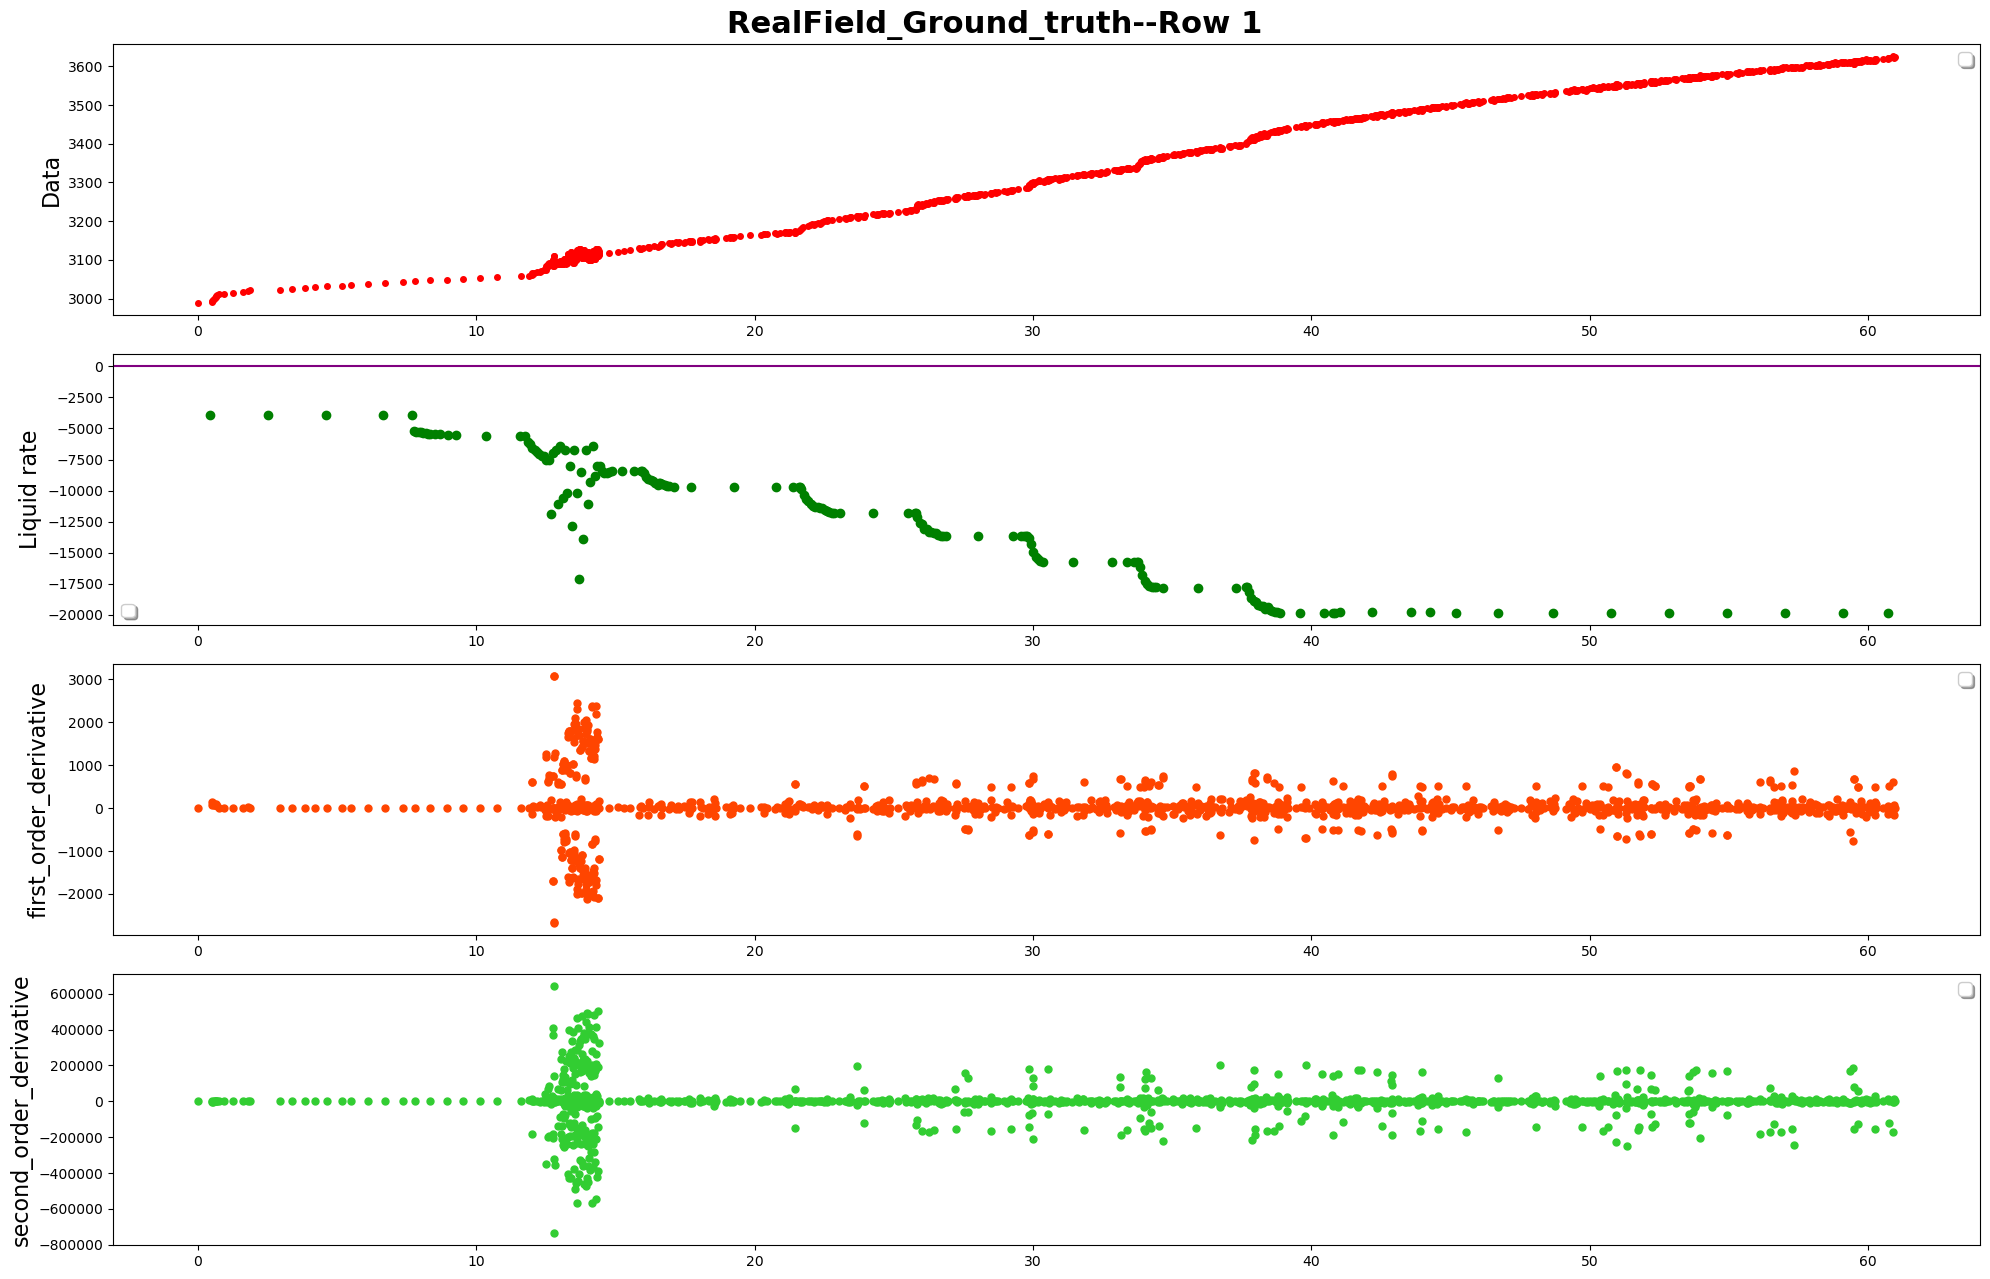

------row 2-----detected points:[2249]


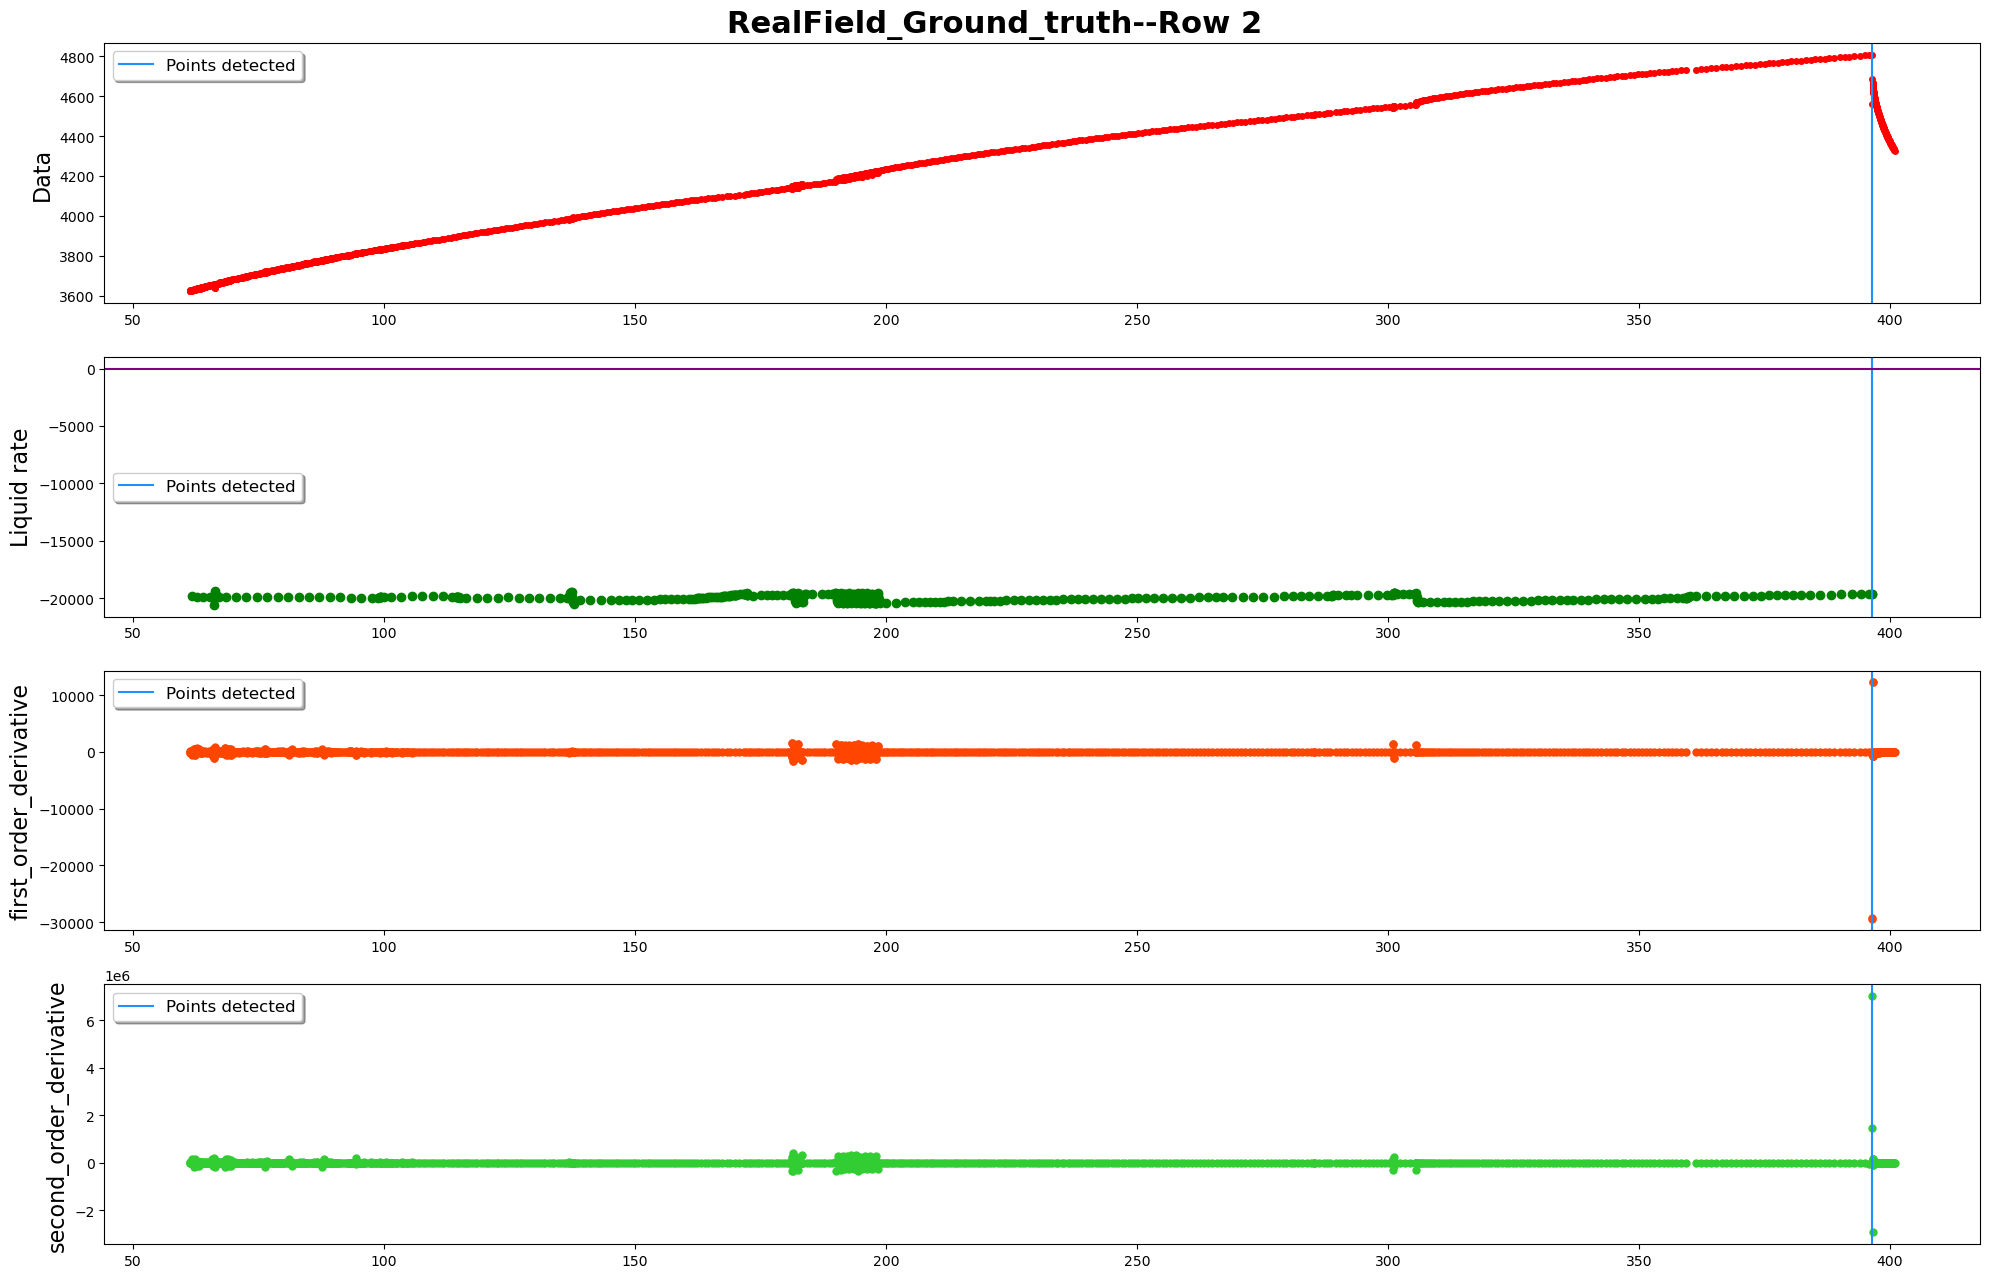

------row 3-----detected points:[2467, 2805, 2876, 3100, 3561]


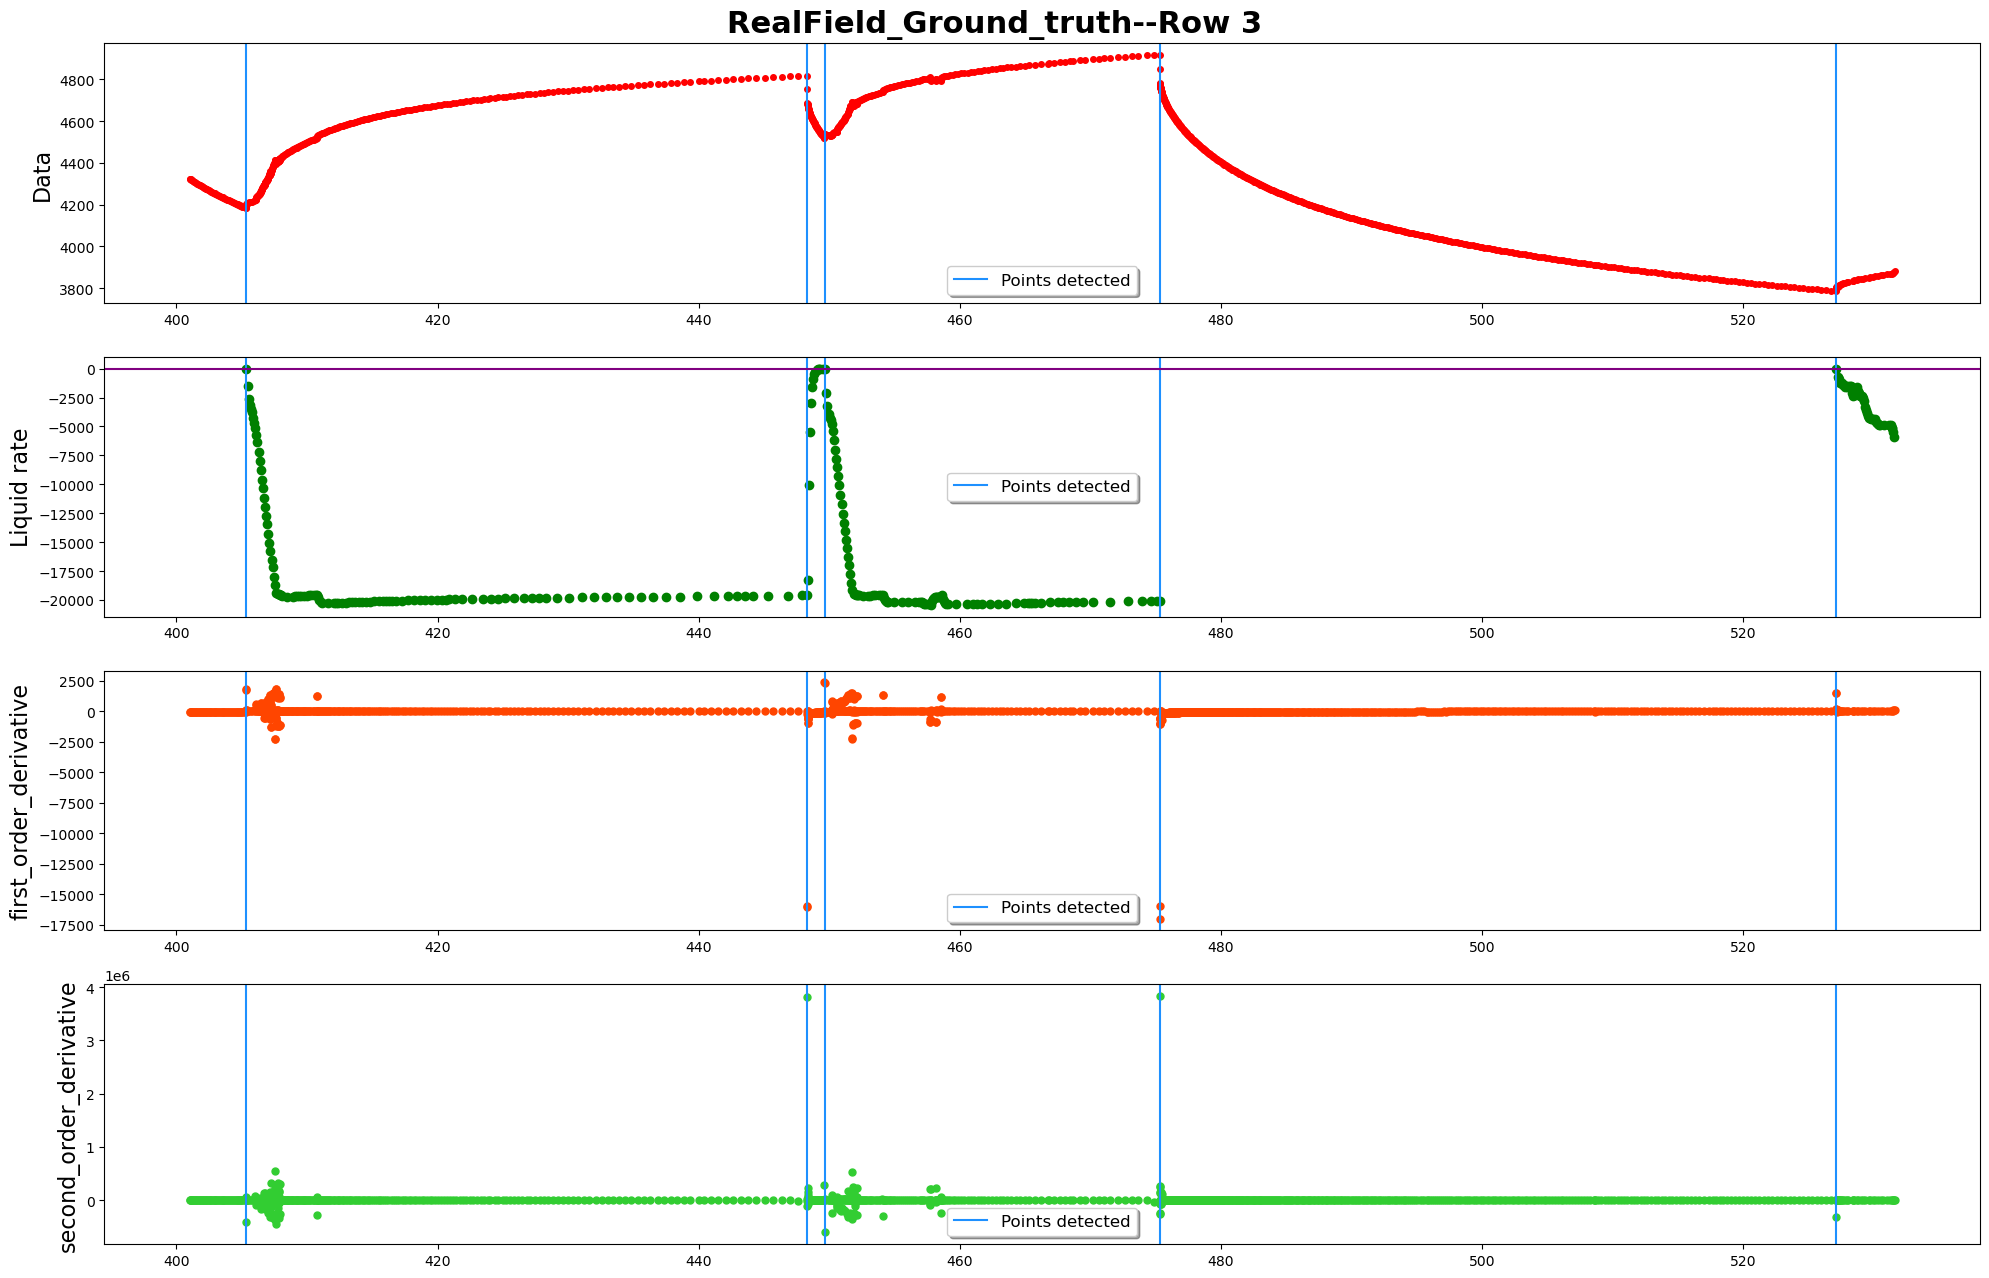

------row 4-----detected points:[3994, 4230, 4753]


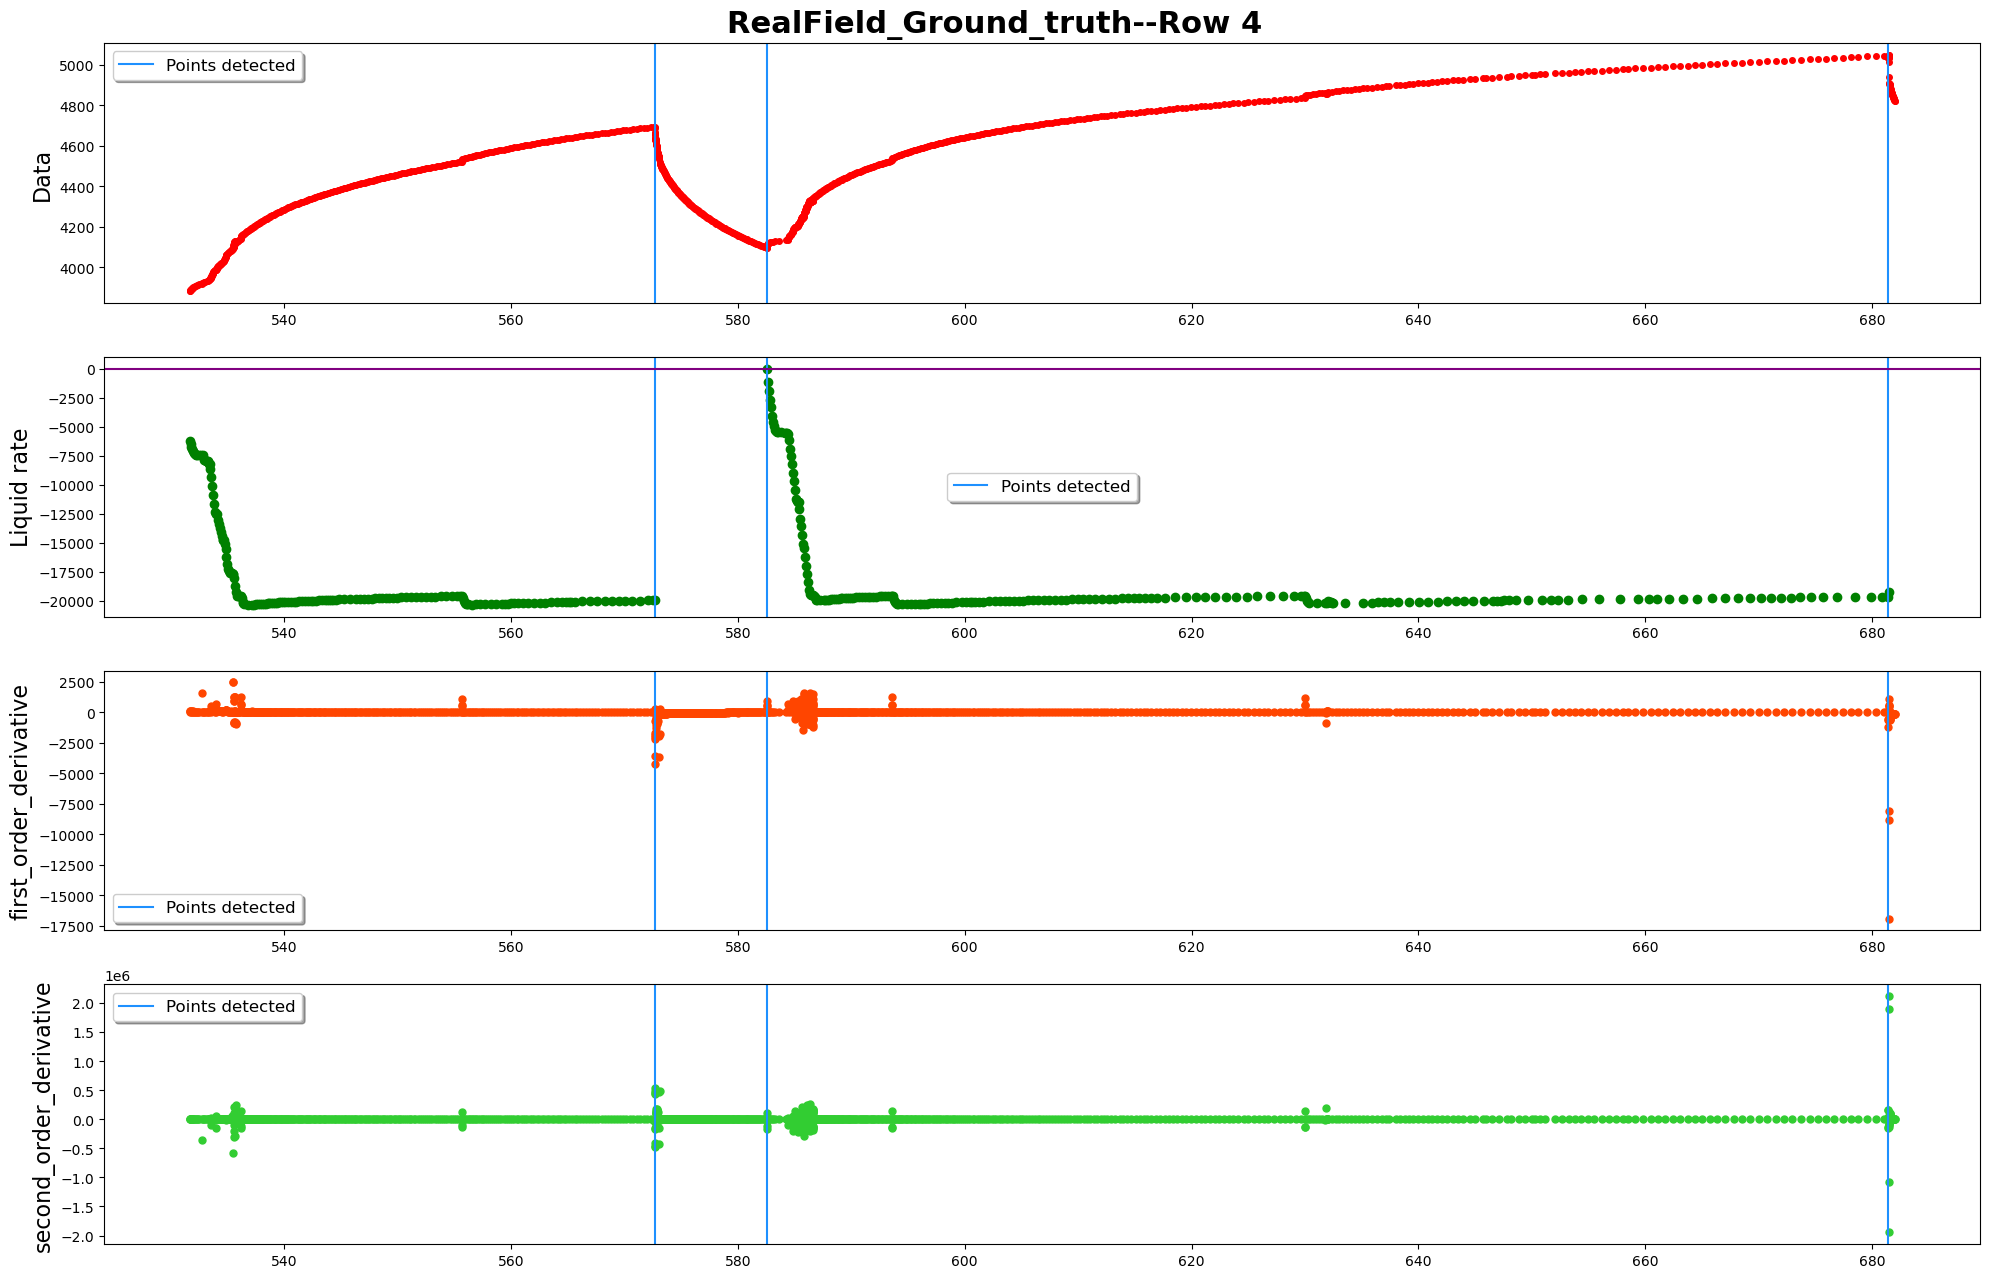

------row 5-----detected points:[4895, 5297, 5436, 5985]


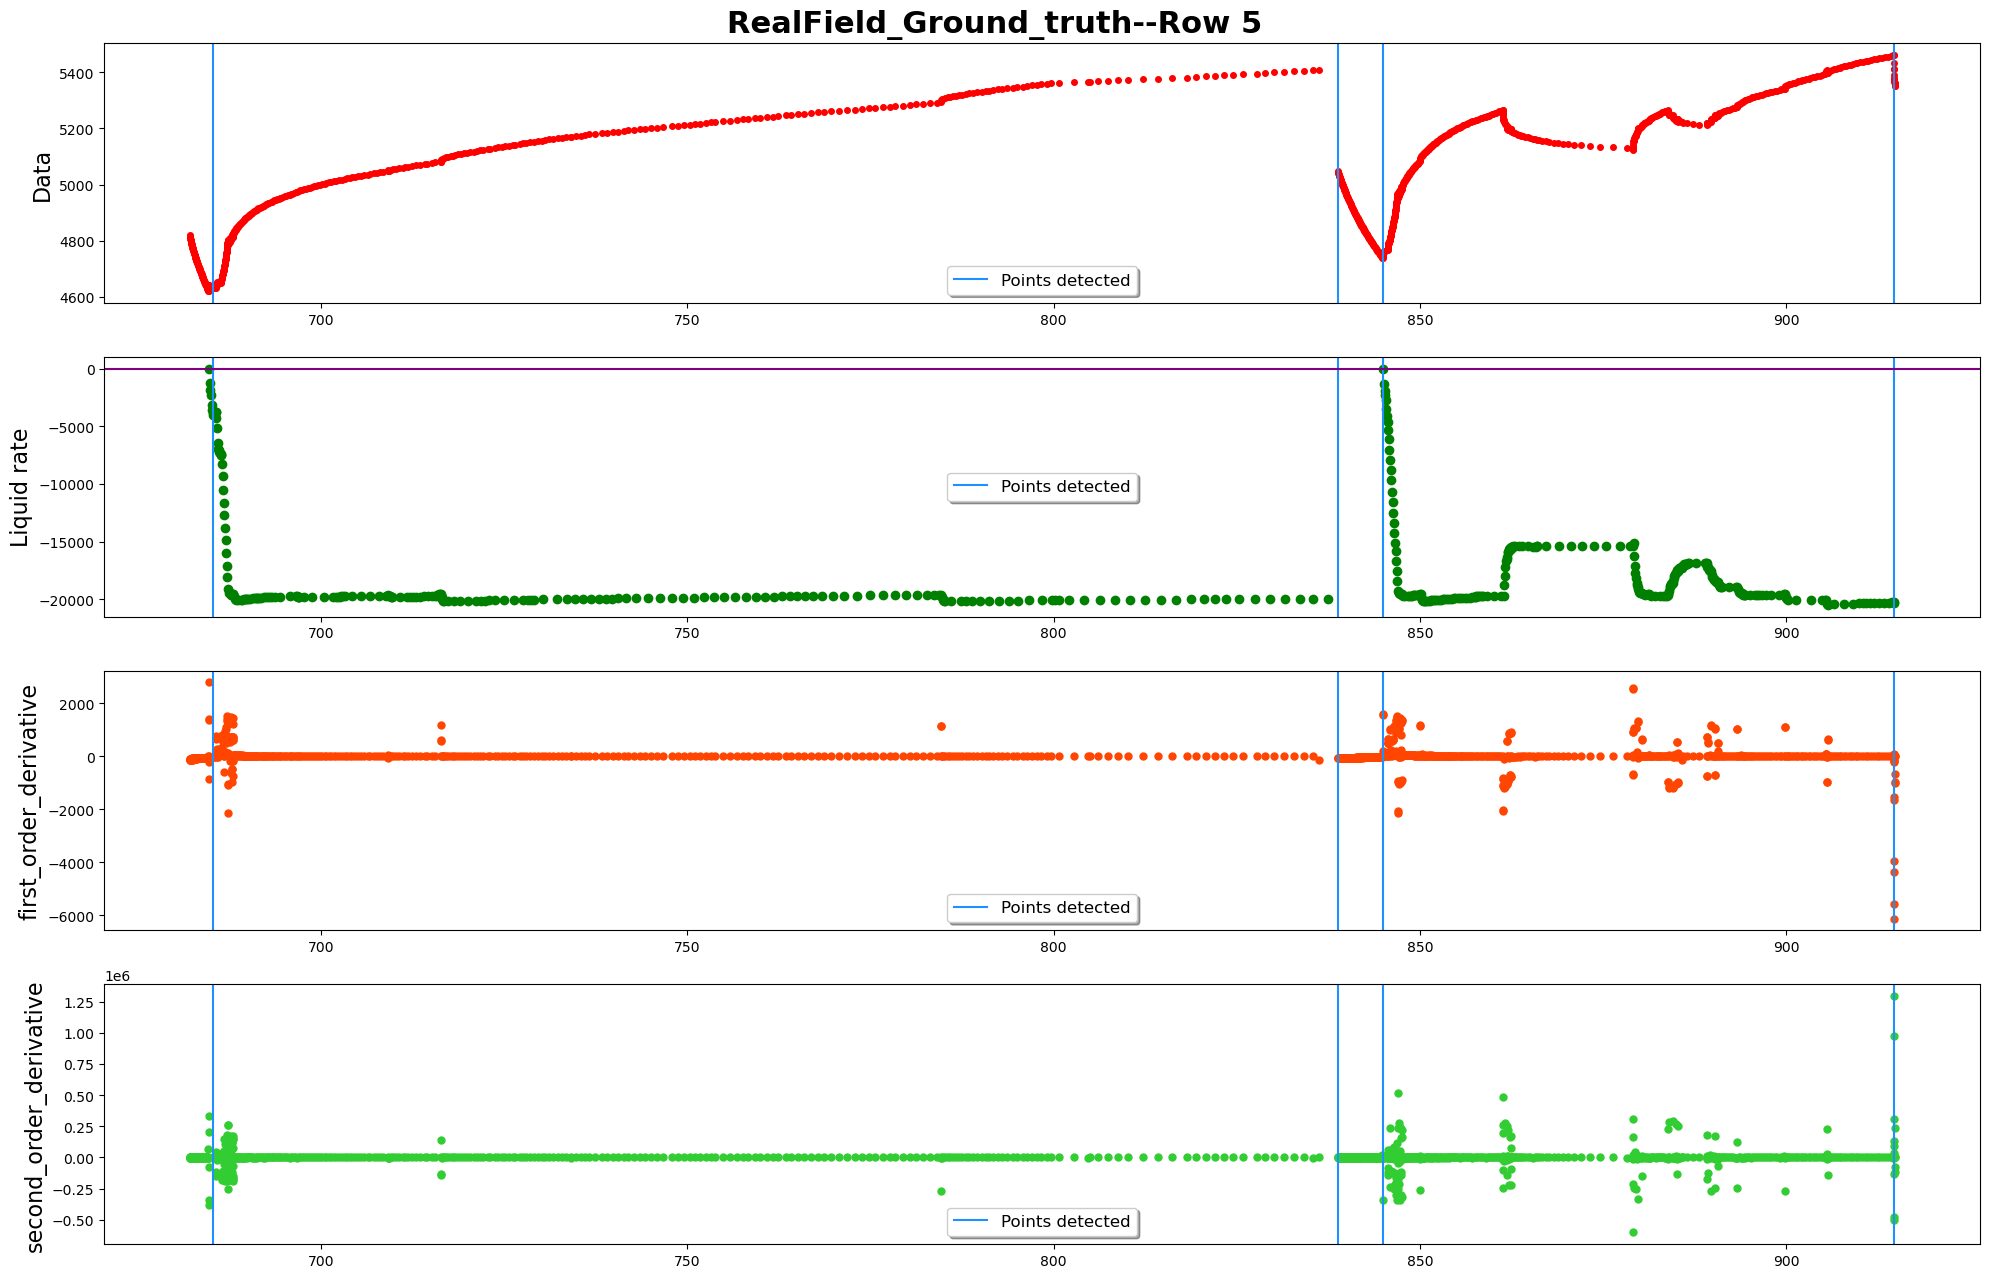

------row 6-----detected points:[6545]


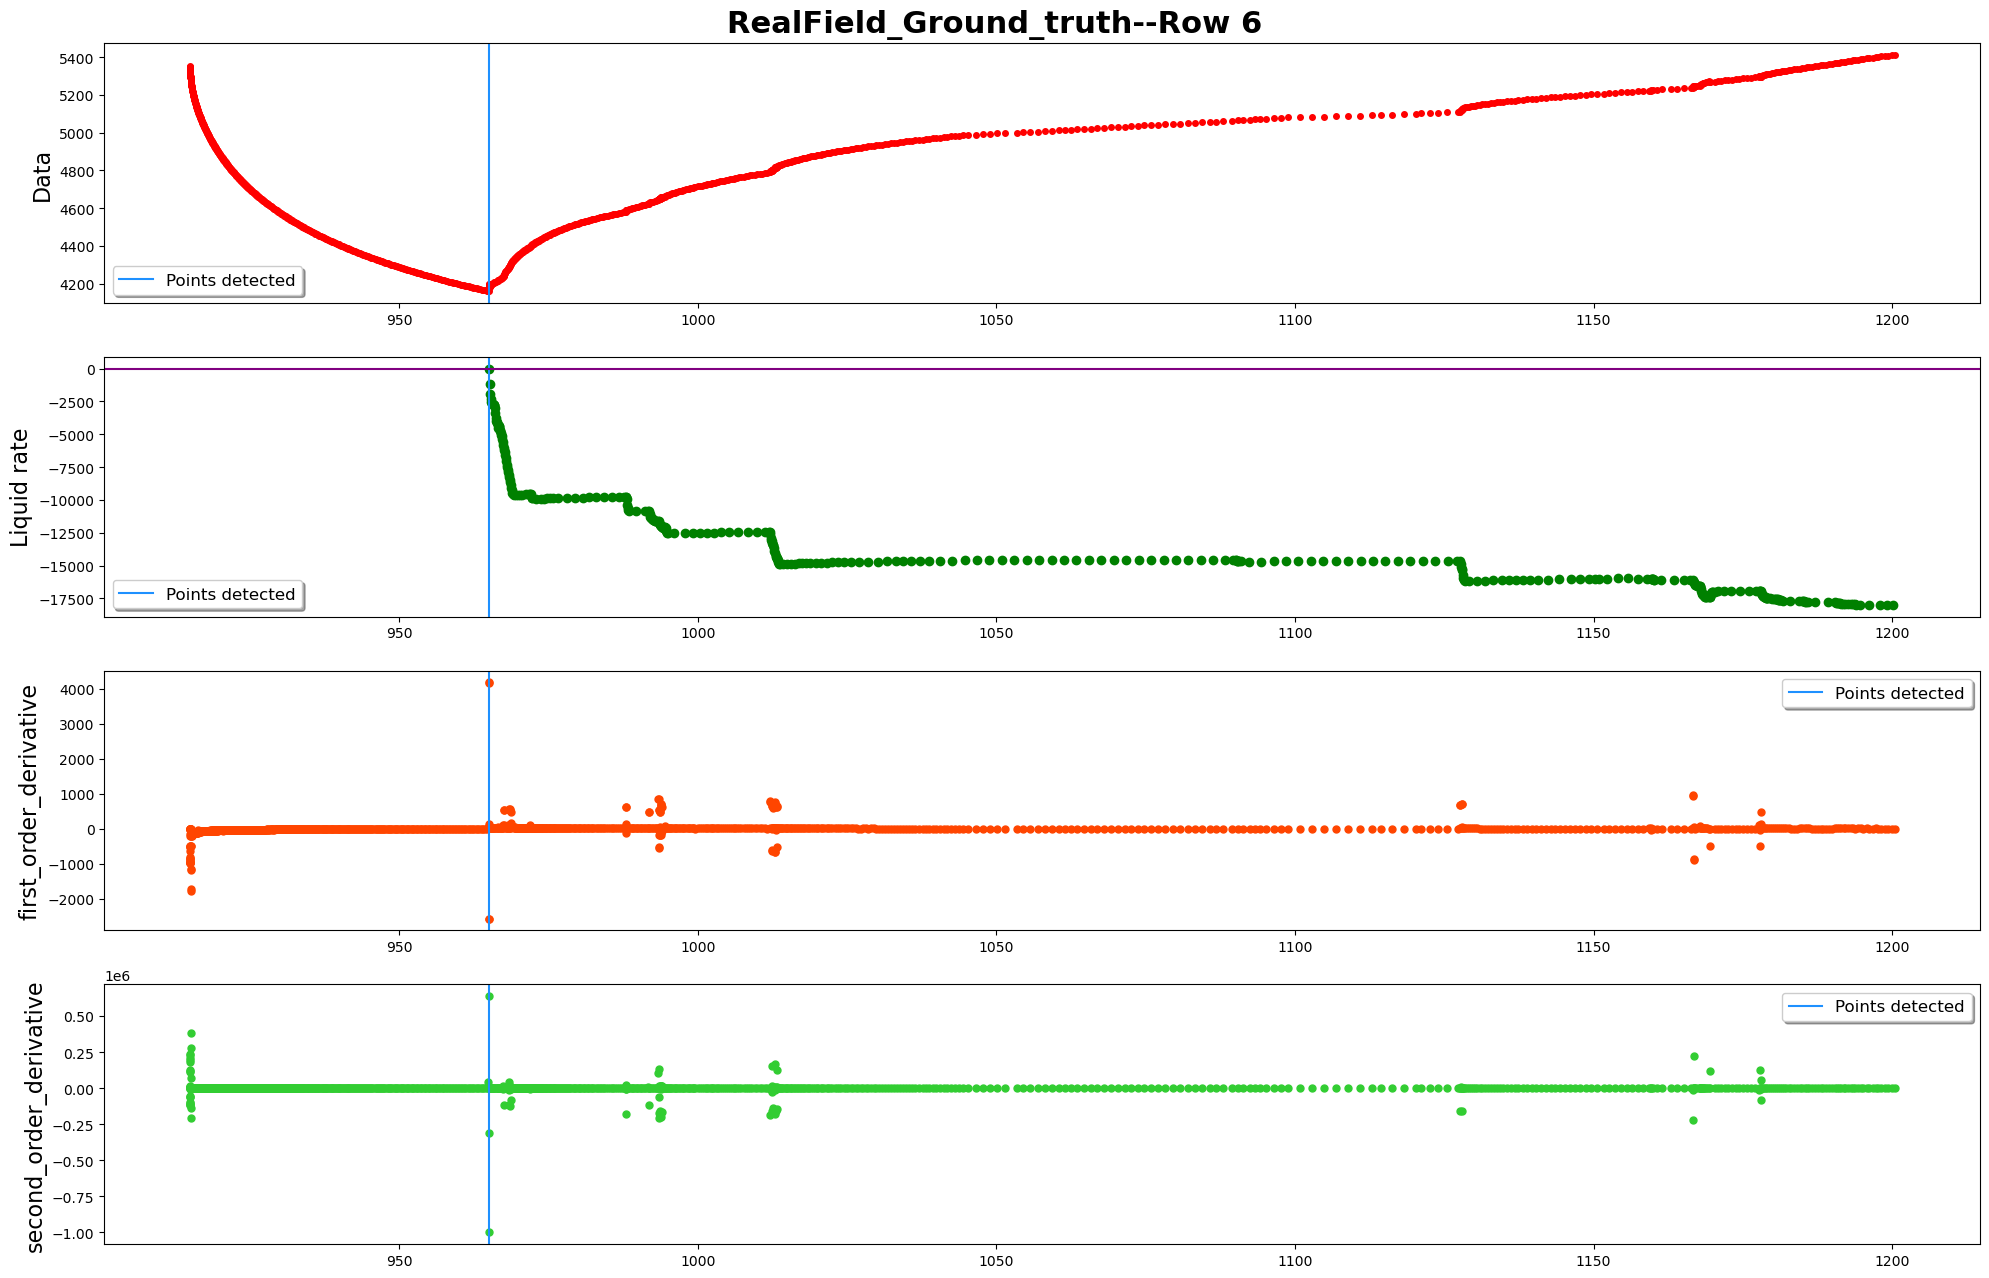

------row 7-----detected points:[7249, 7545, 7946, 8363]


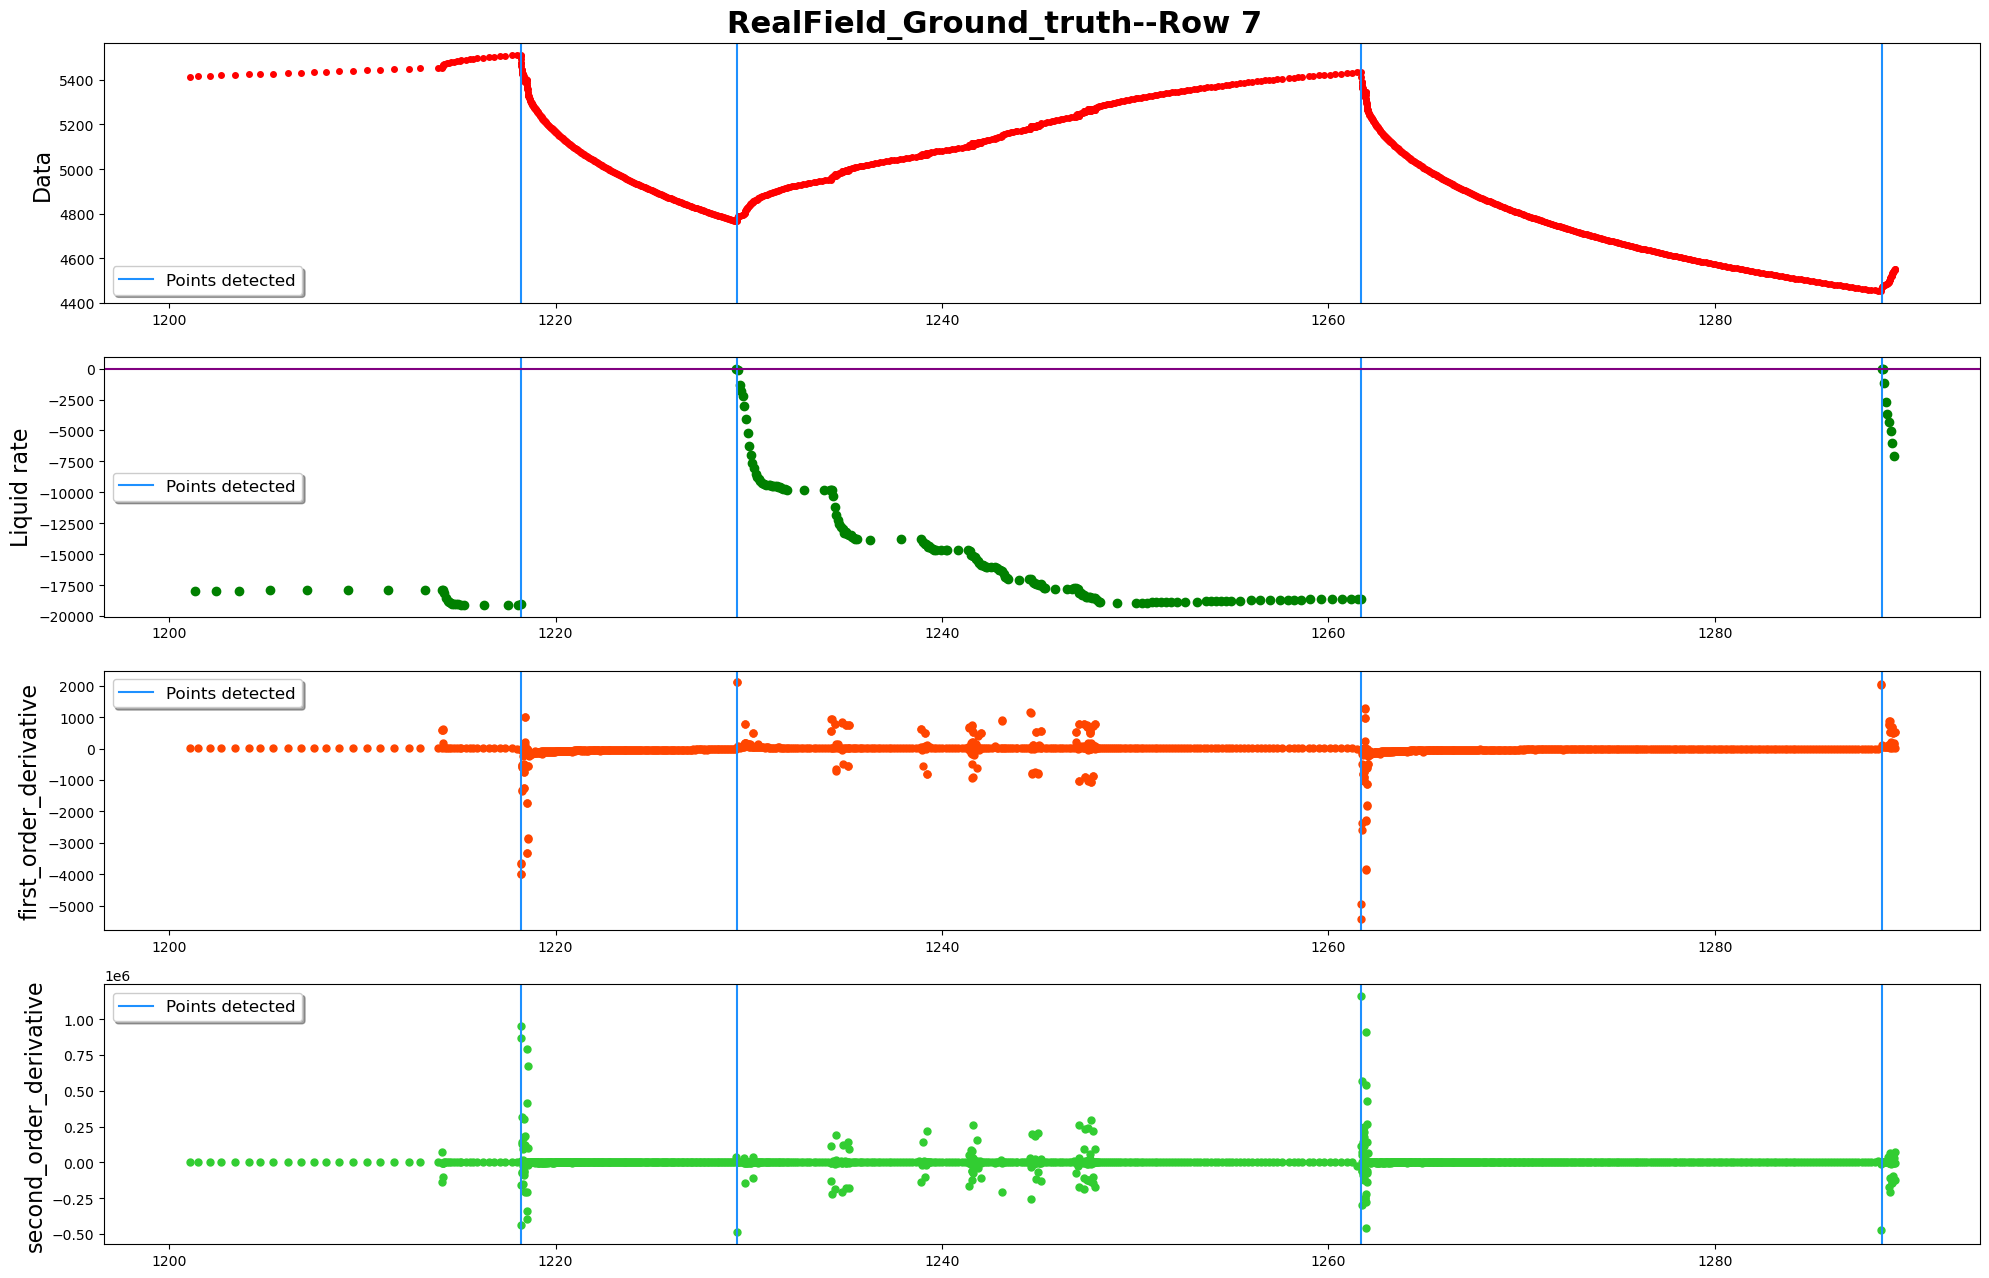

------row 8-----detected points:[9025]


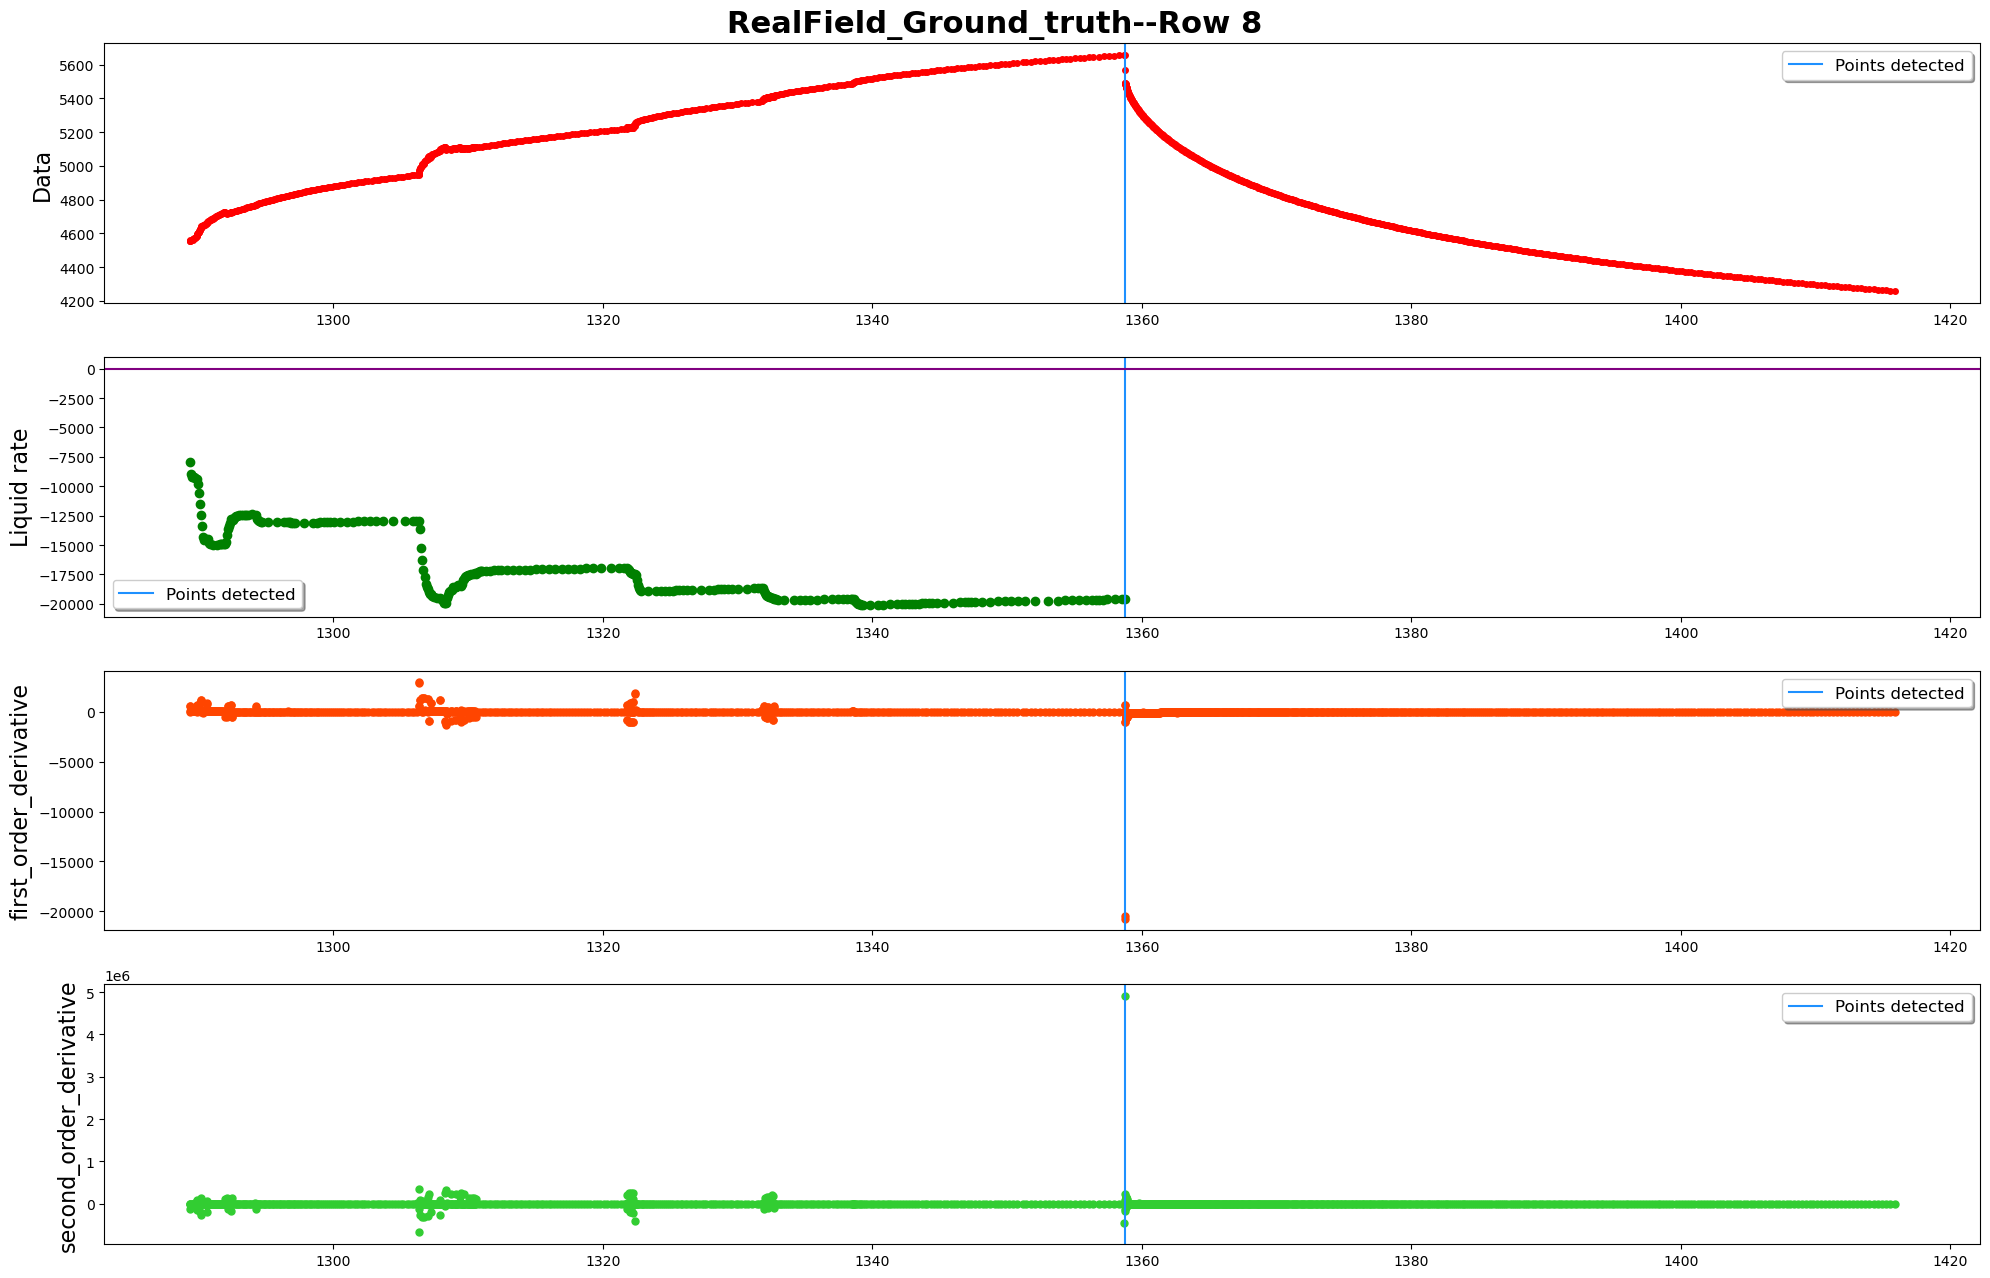

------row 9-----detected points:[9608, 10149, 10216, 10528]


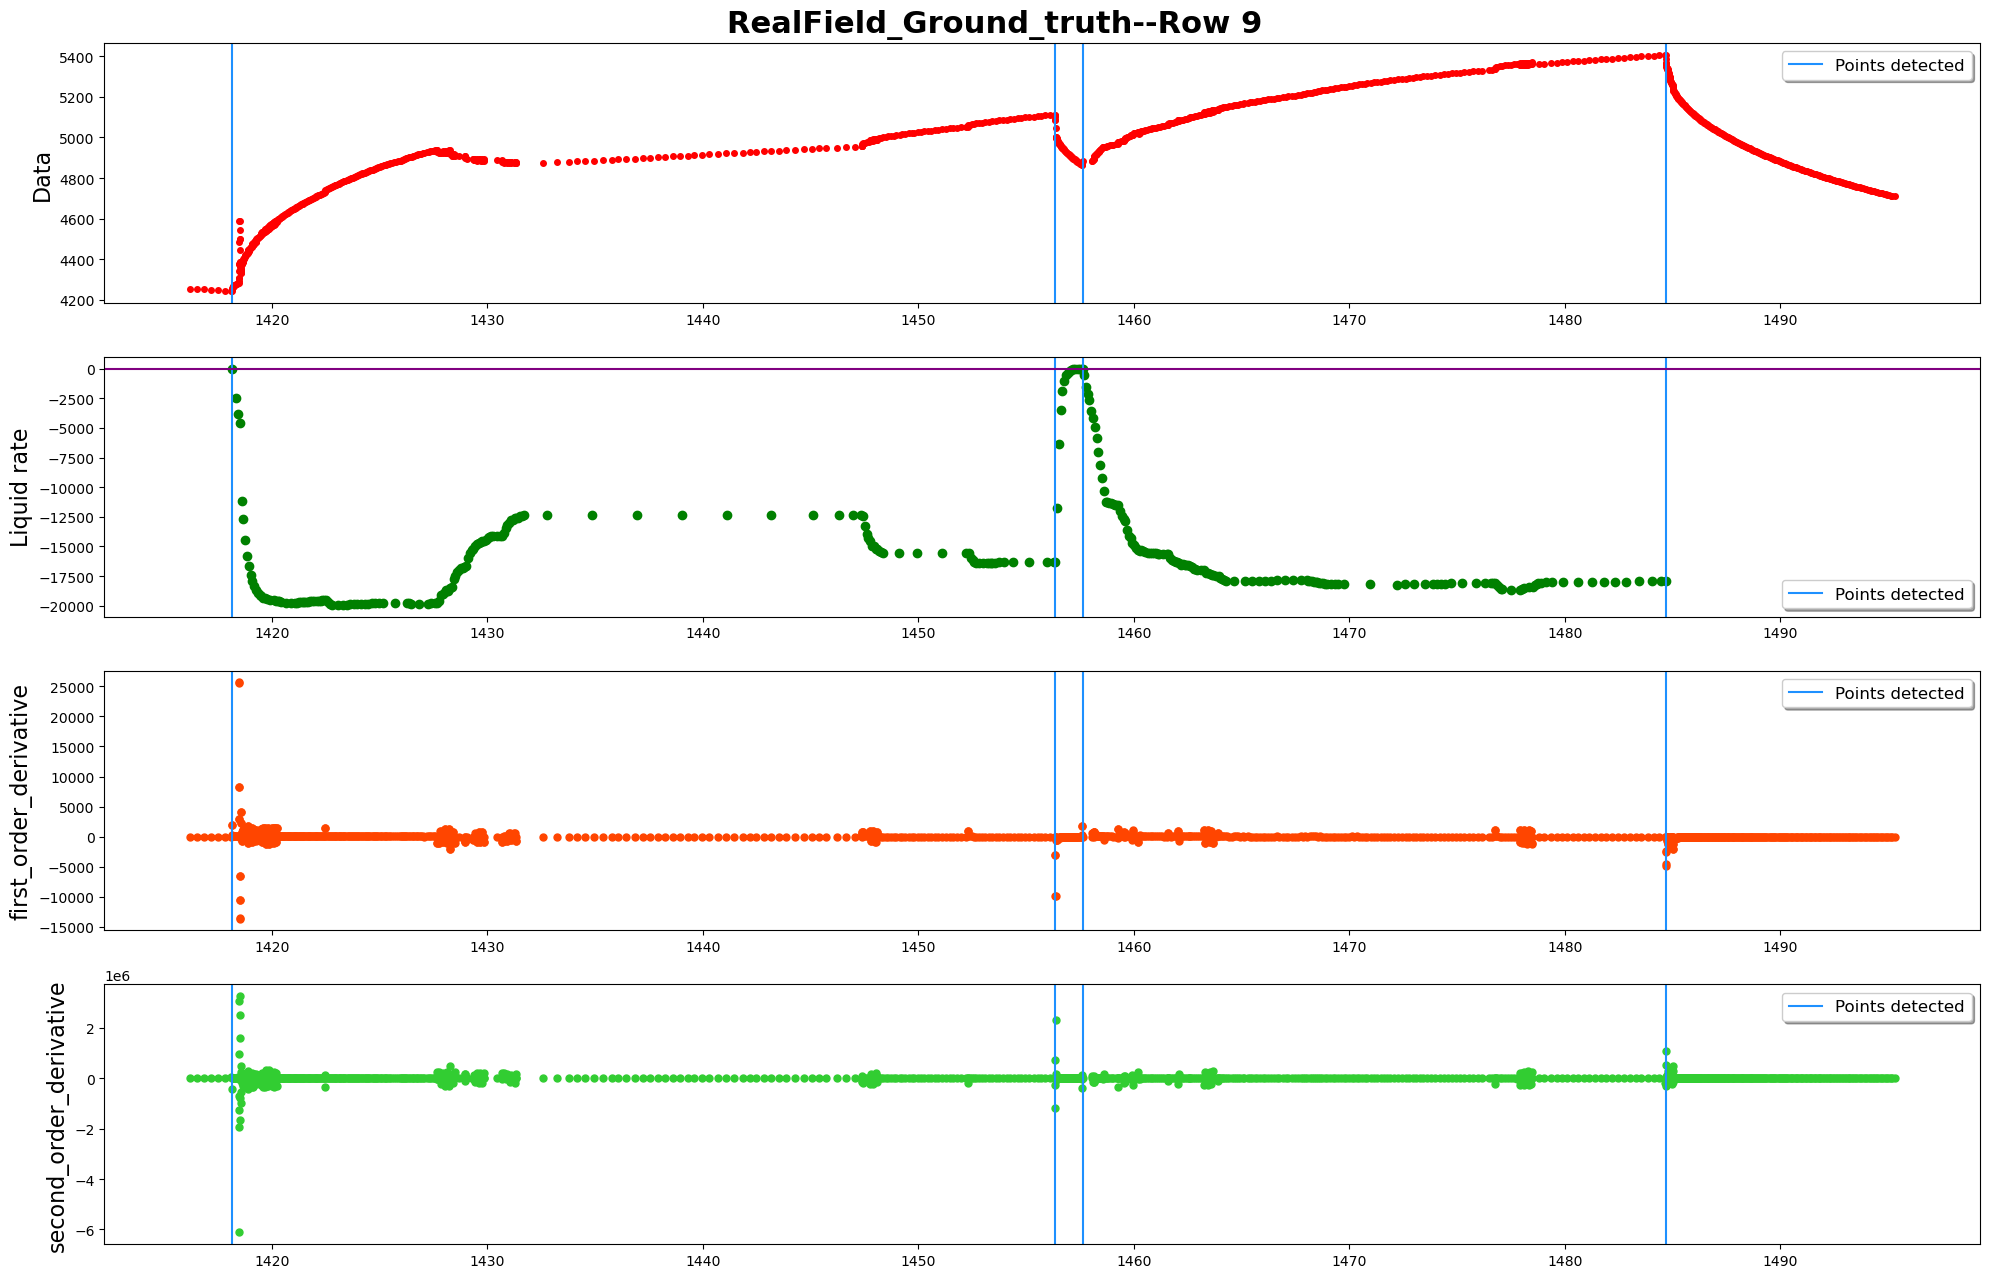

------row 10-----detected points:[10803, 11340, 11479]


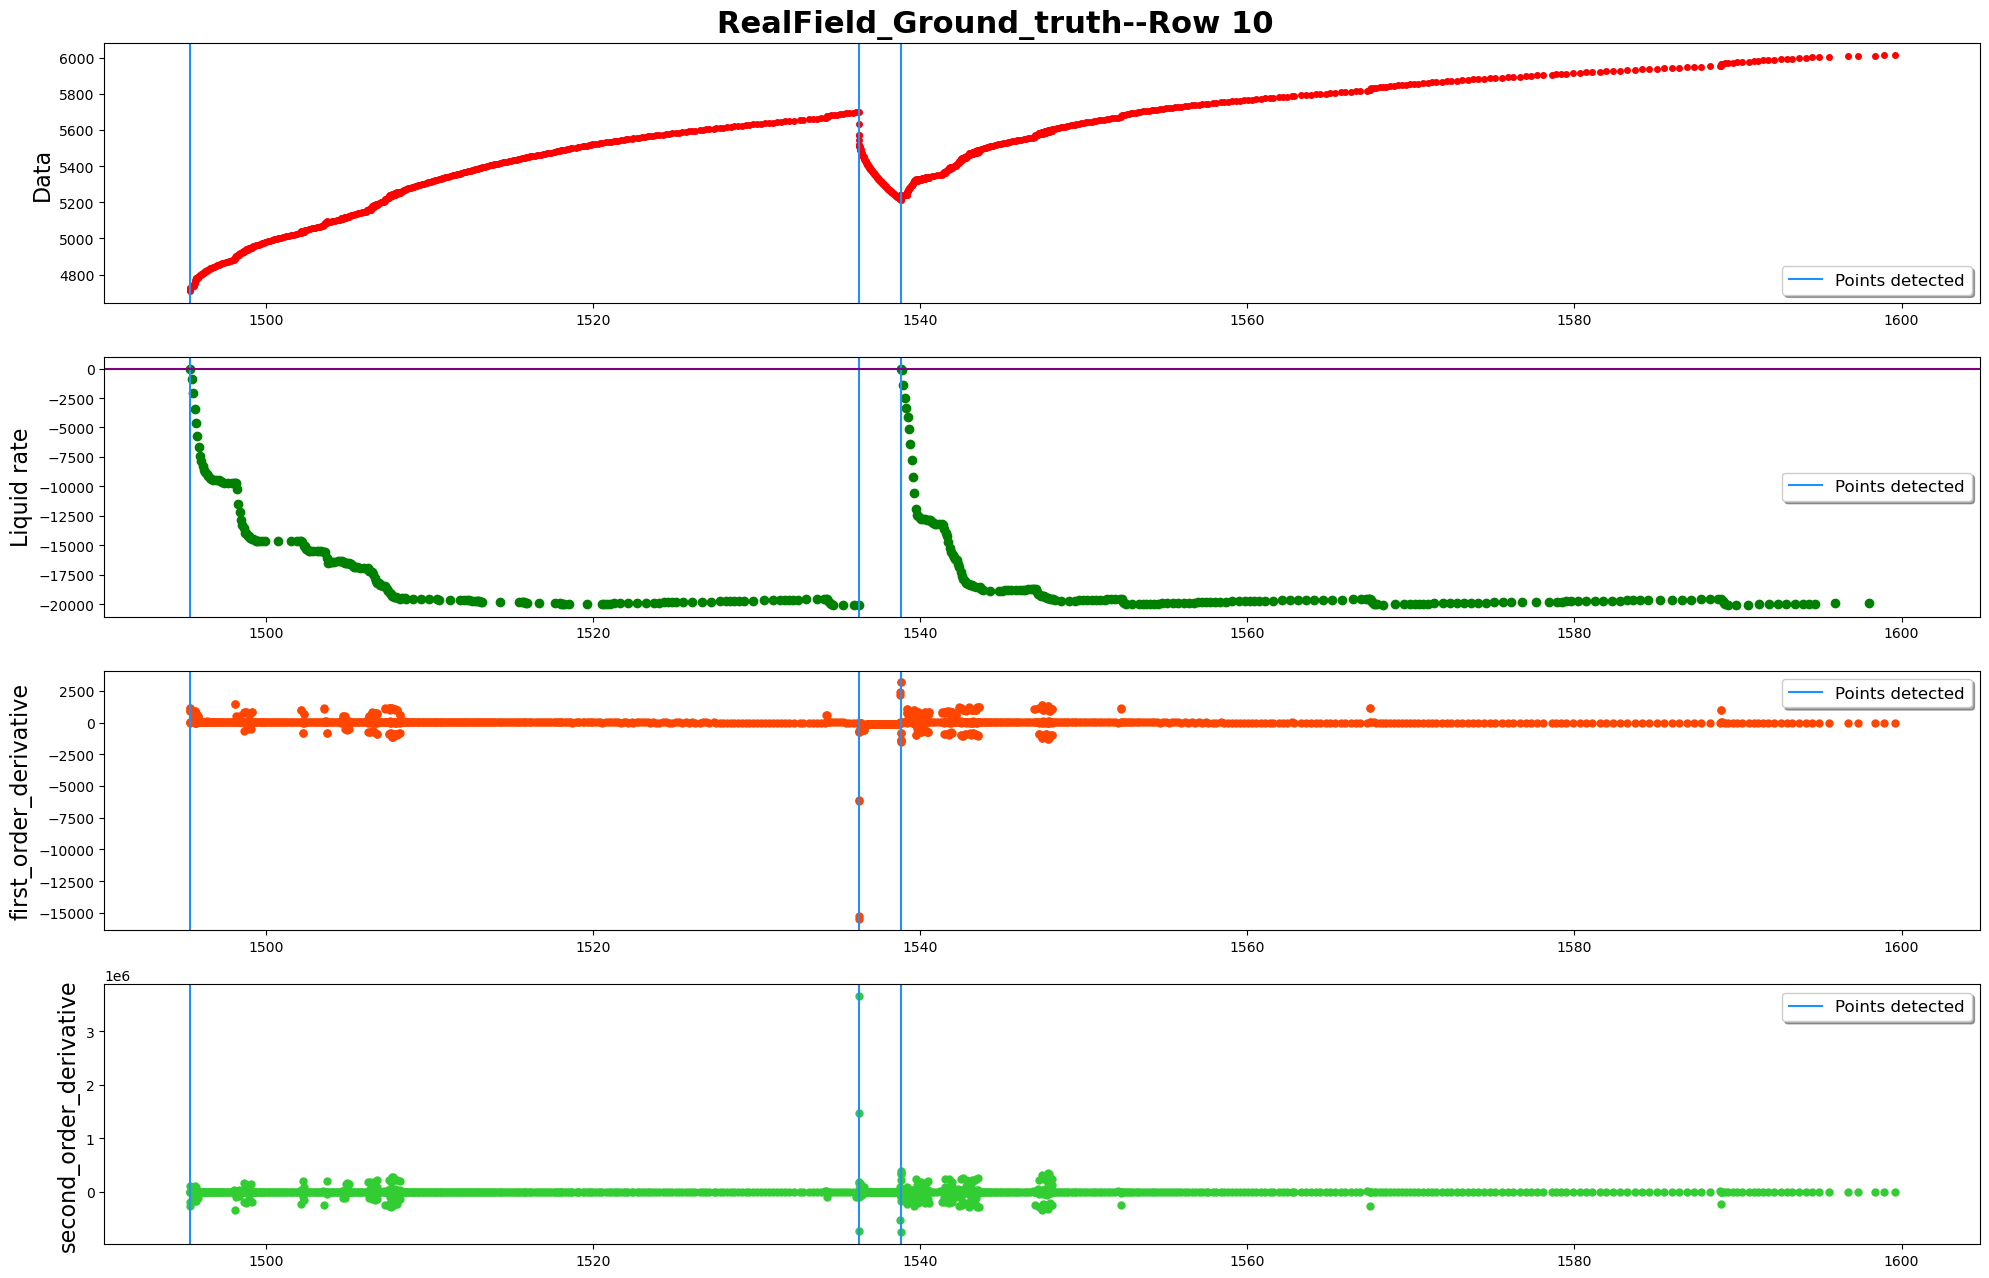

------row 11-----detected points:[12363, 13040]


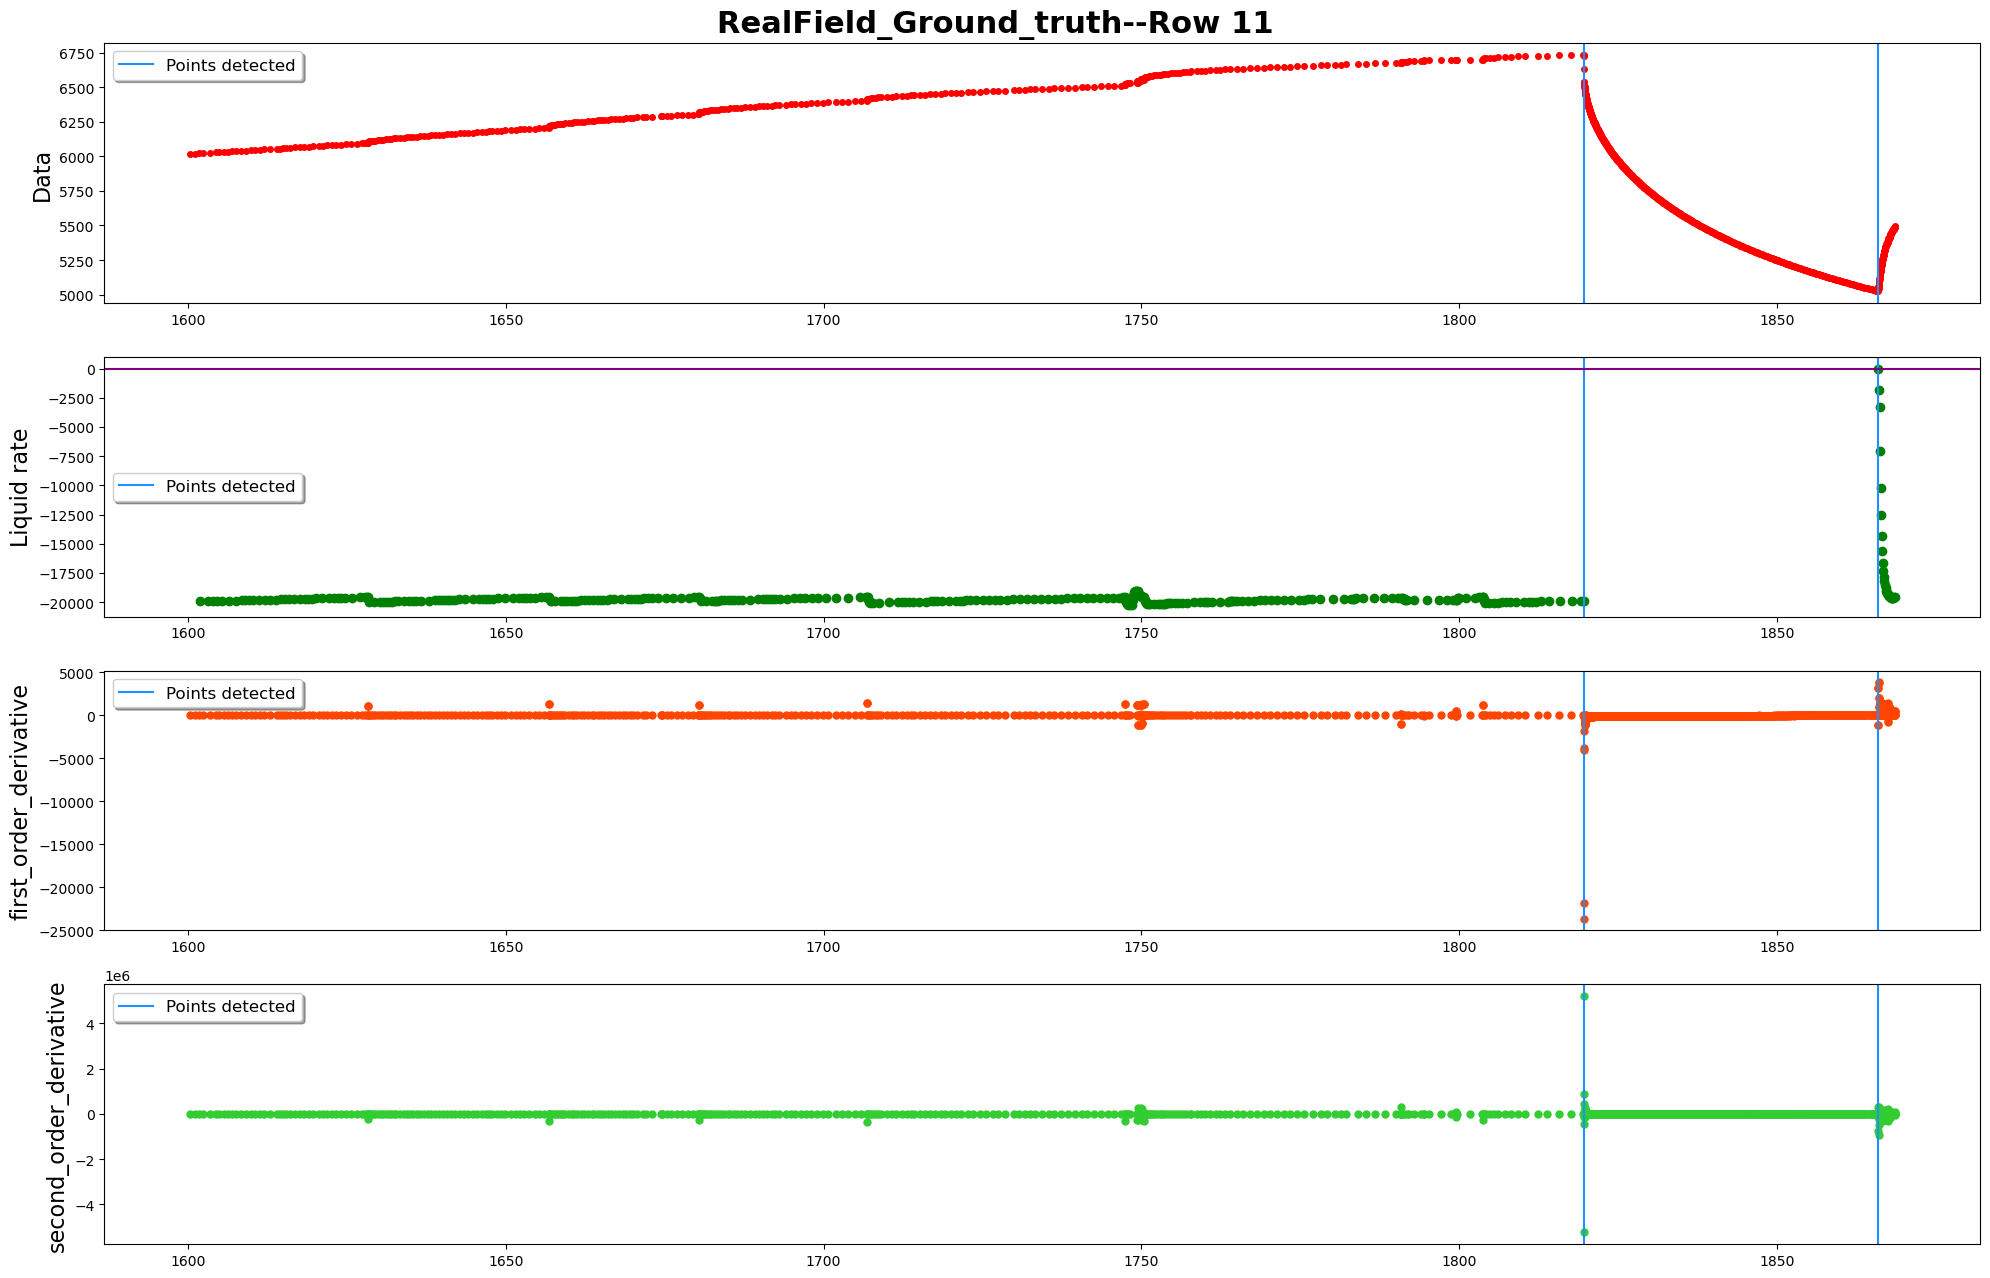

------row 12-----detected points:[13868, 14086]


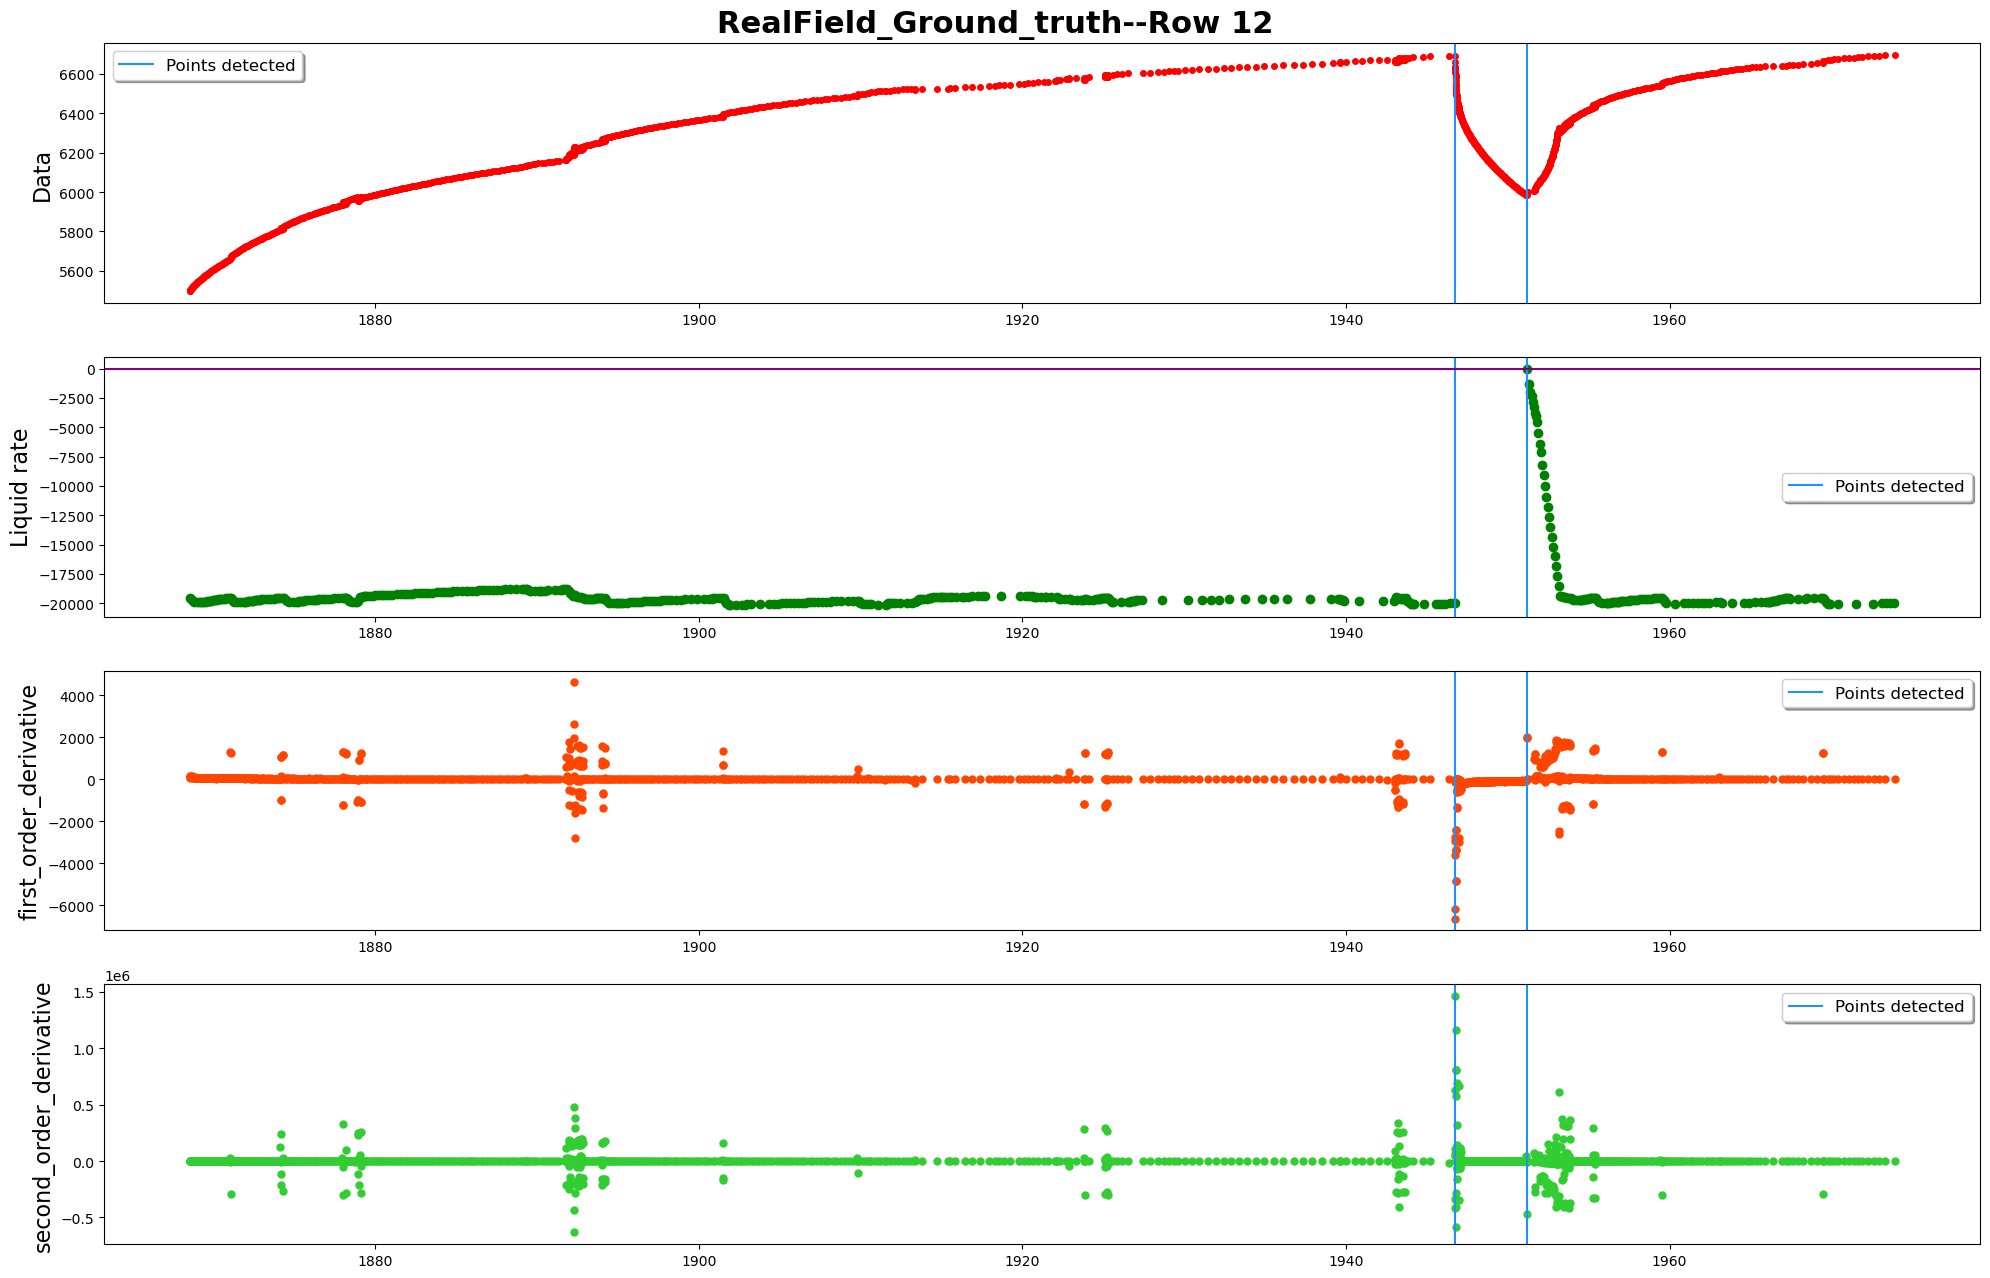

------row 13-----detected points:[14774, 15341]


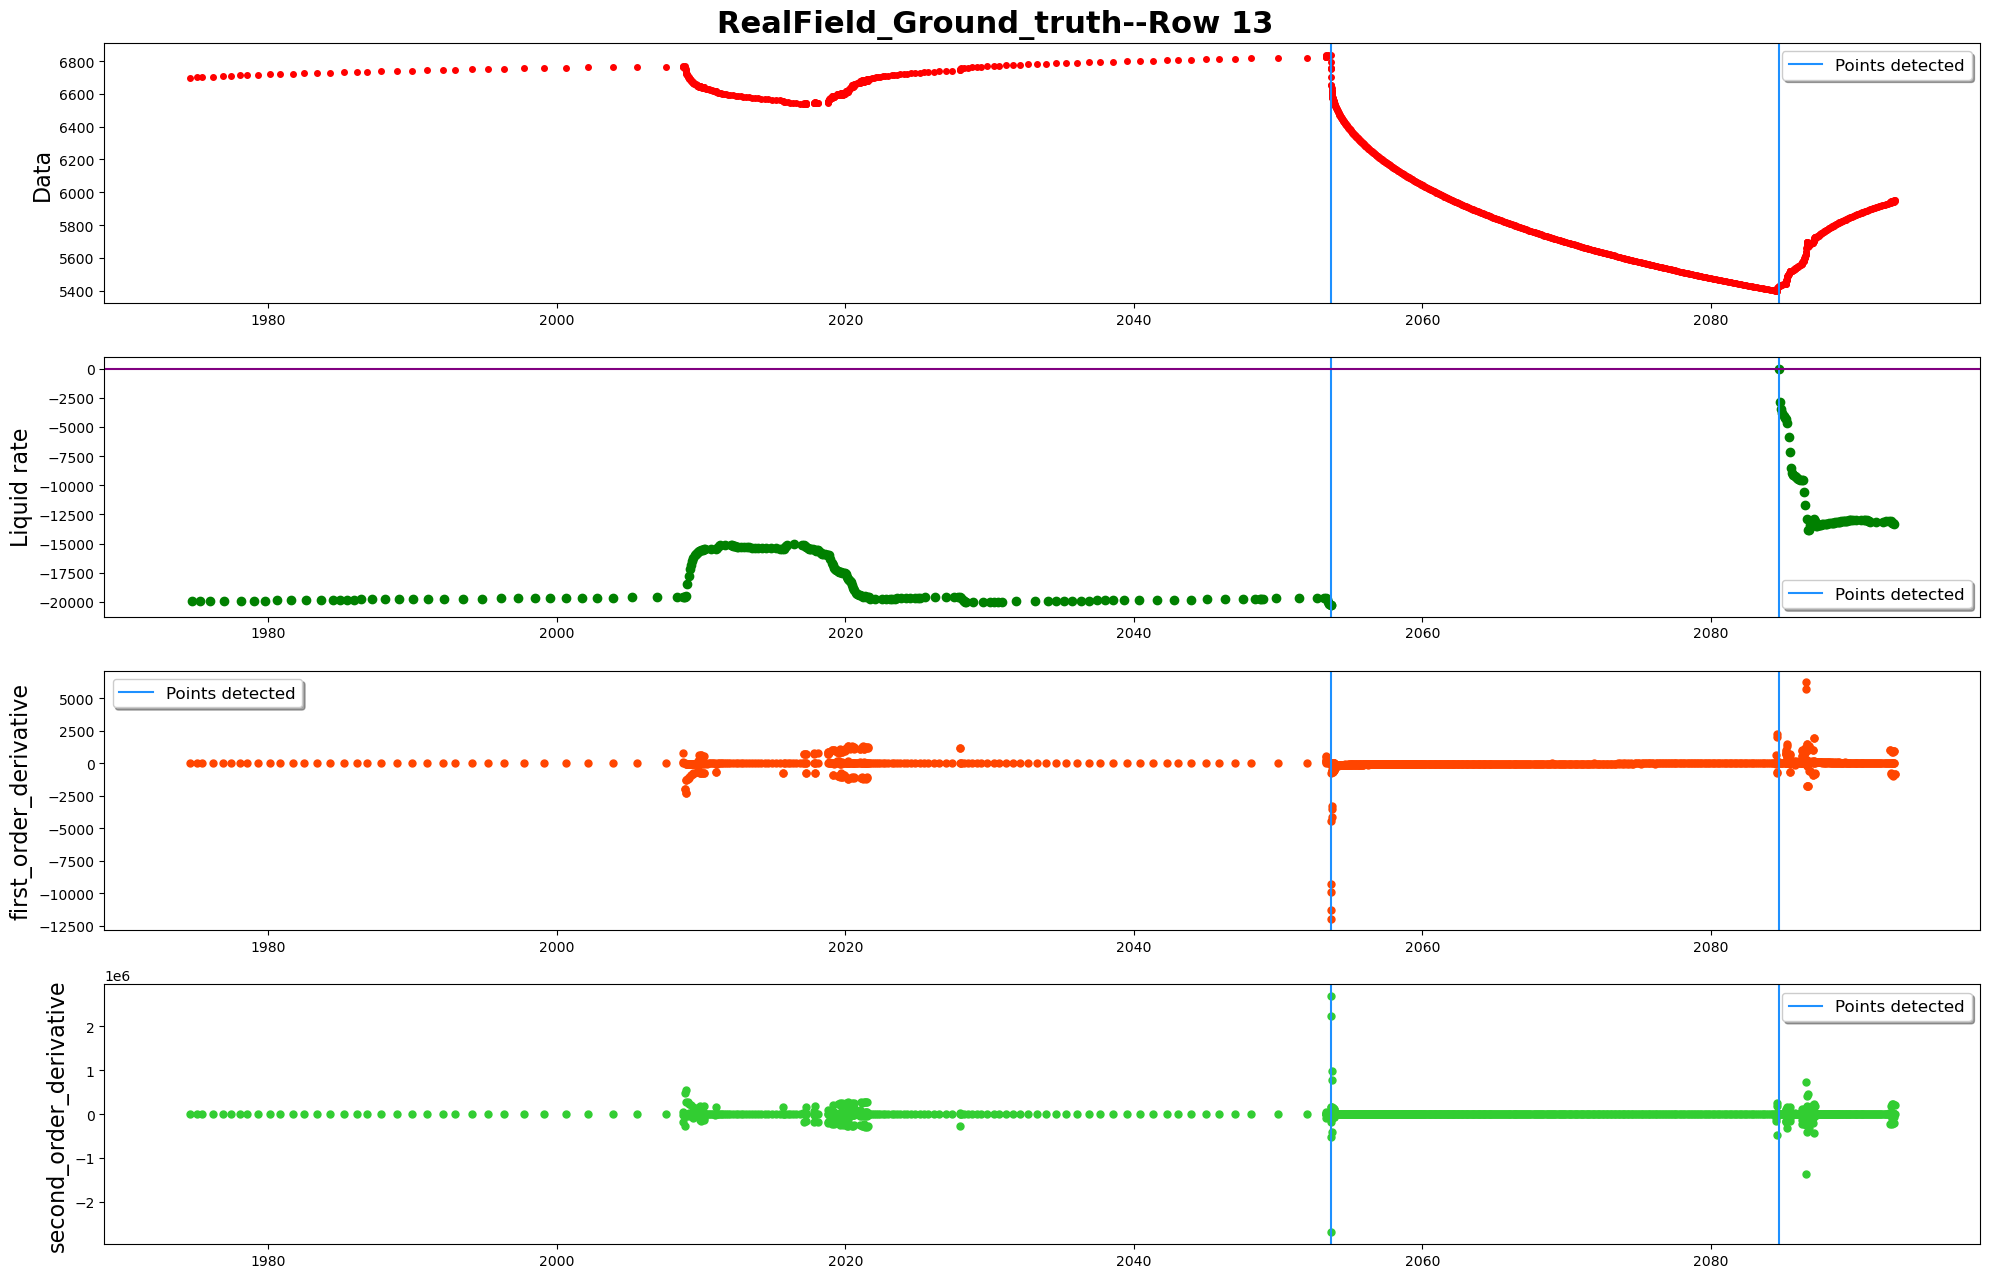

------row 14-----detected points:[16098, 16616]


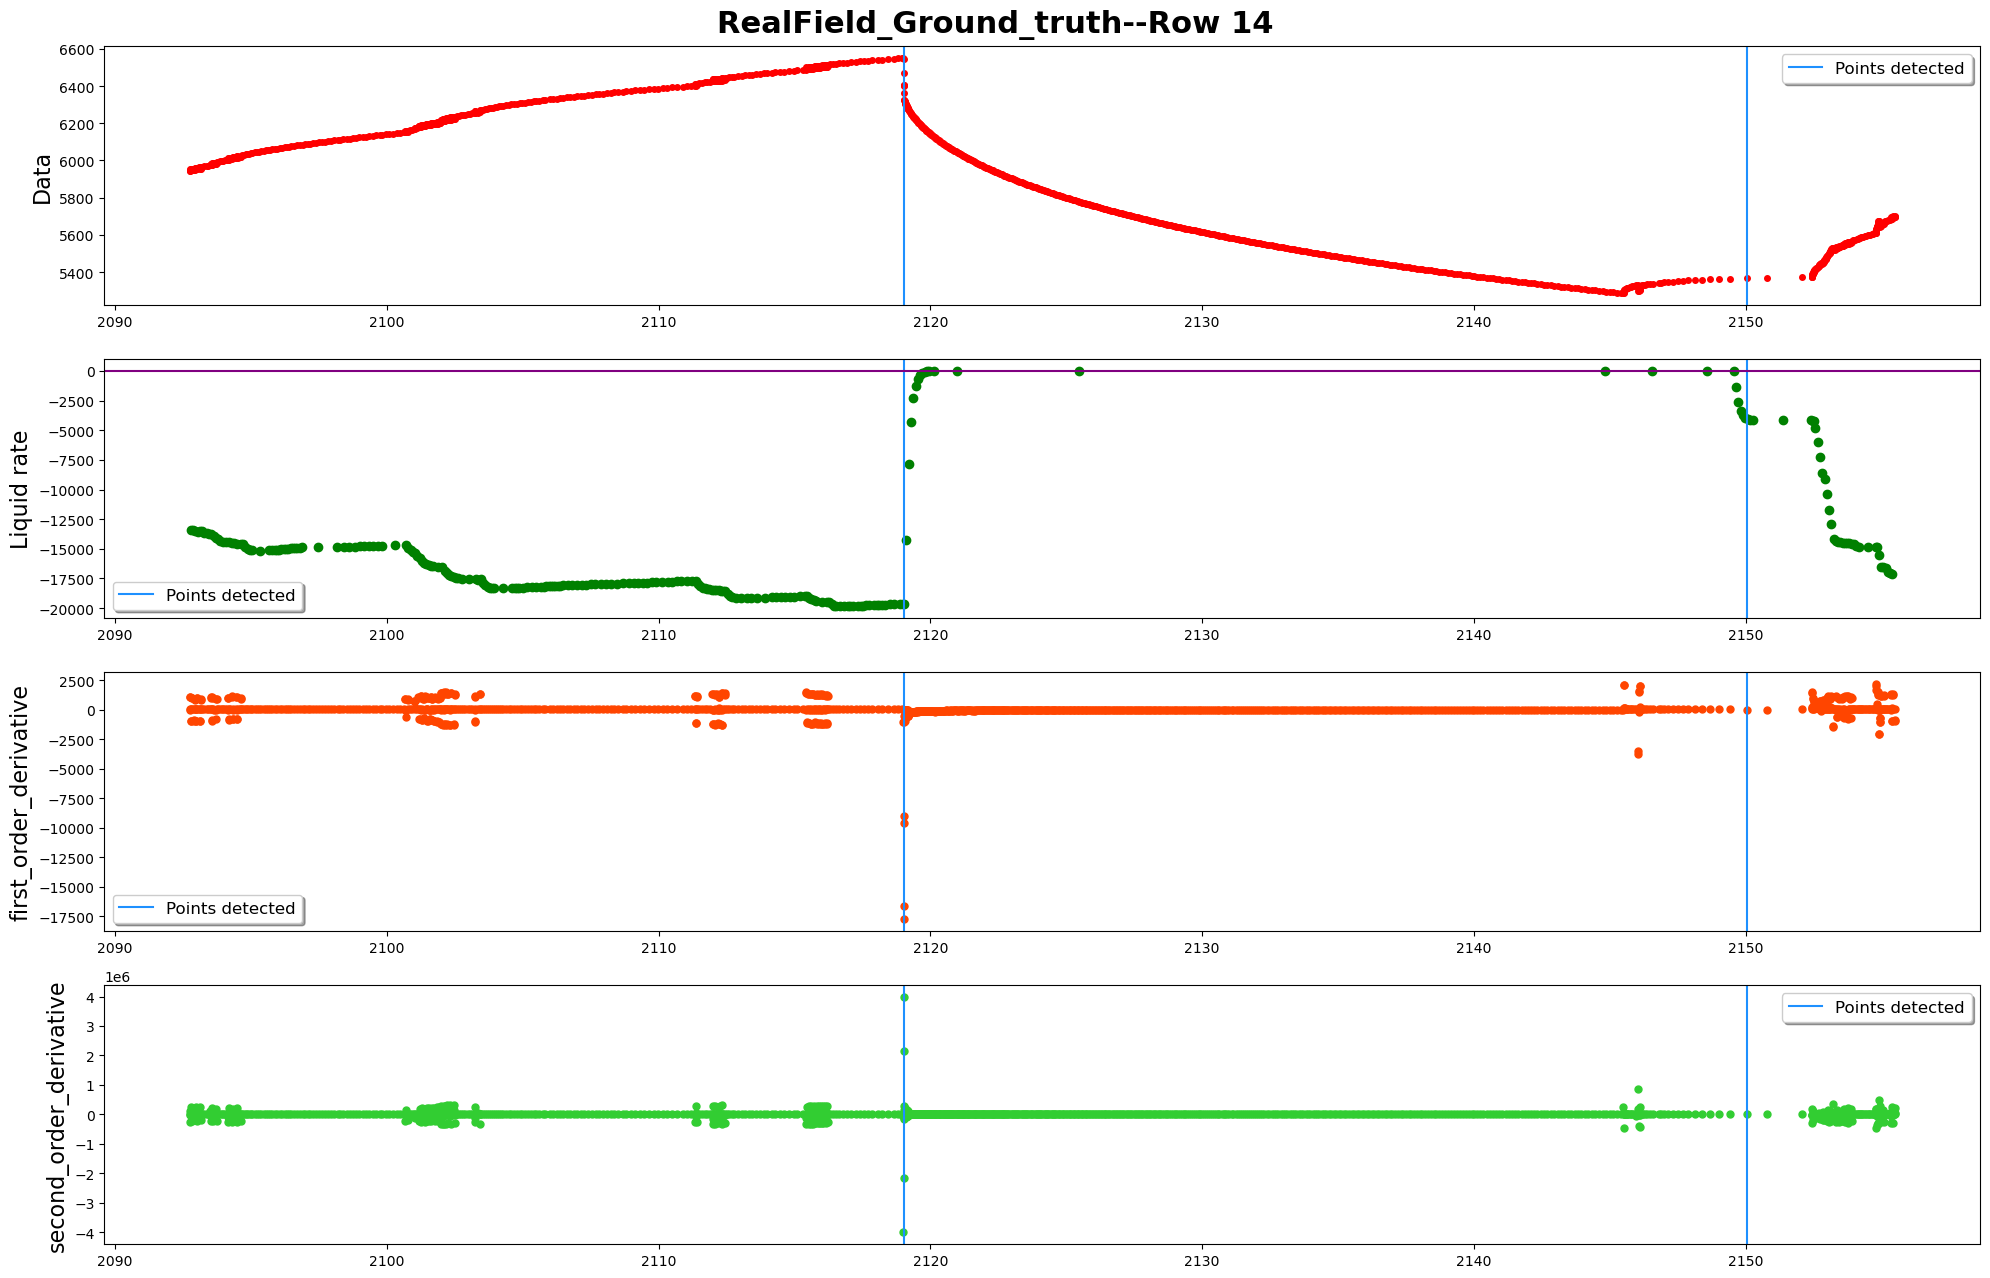

------row 15-----detected points:[17590]


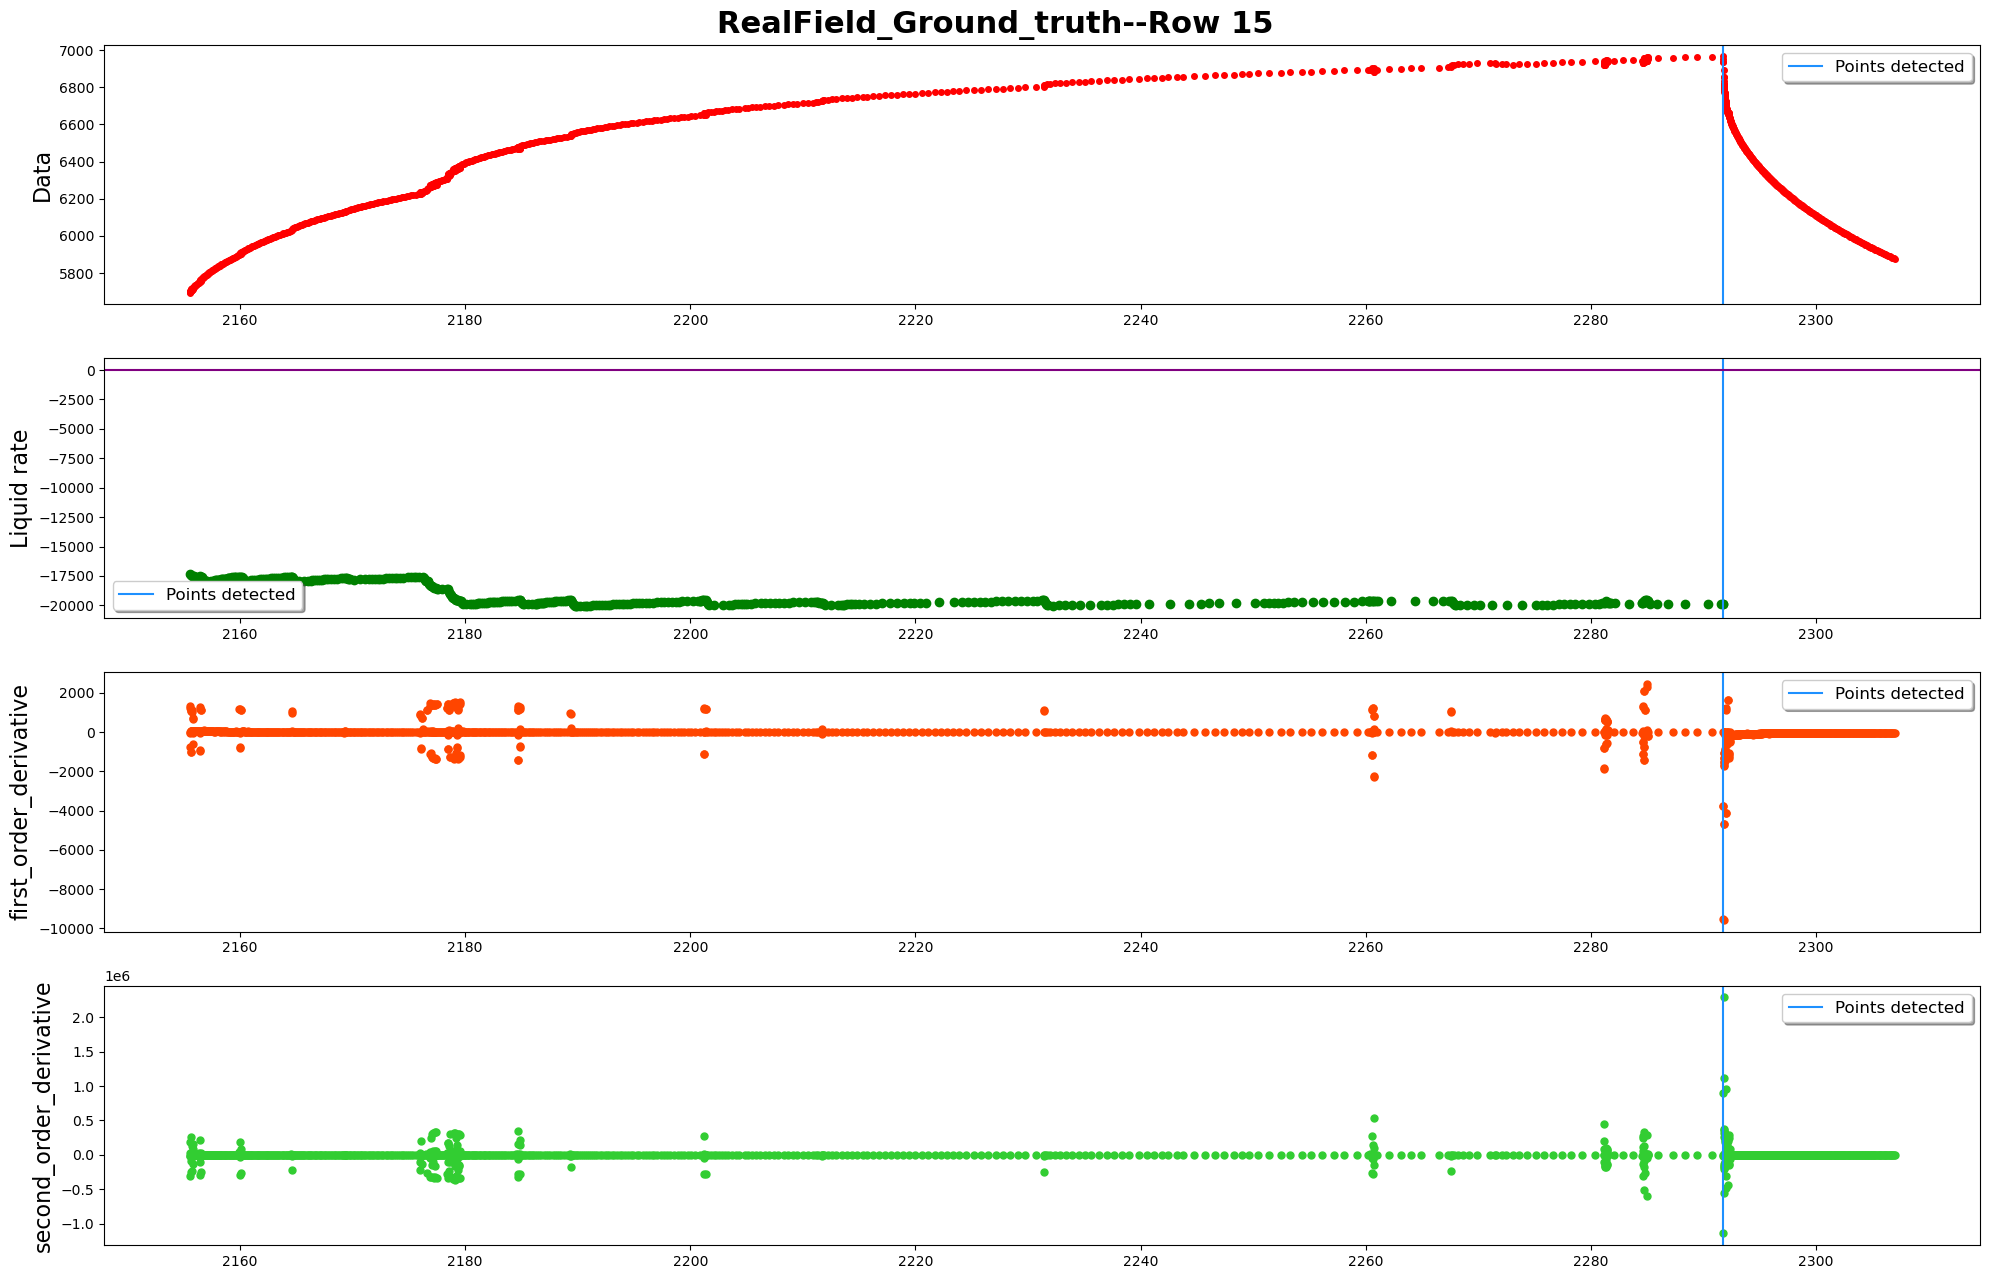

------row 16-----detected points:[18435]


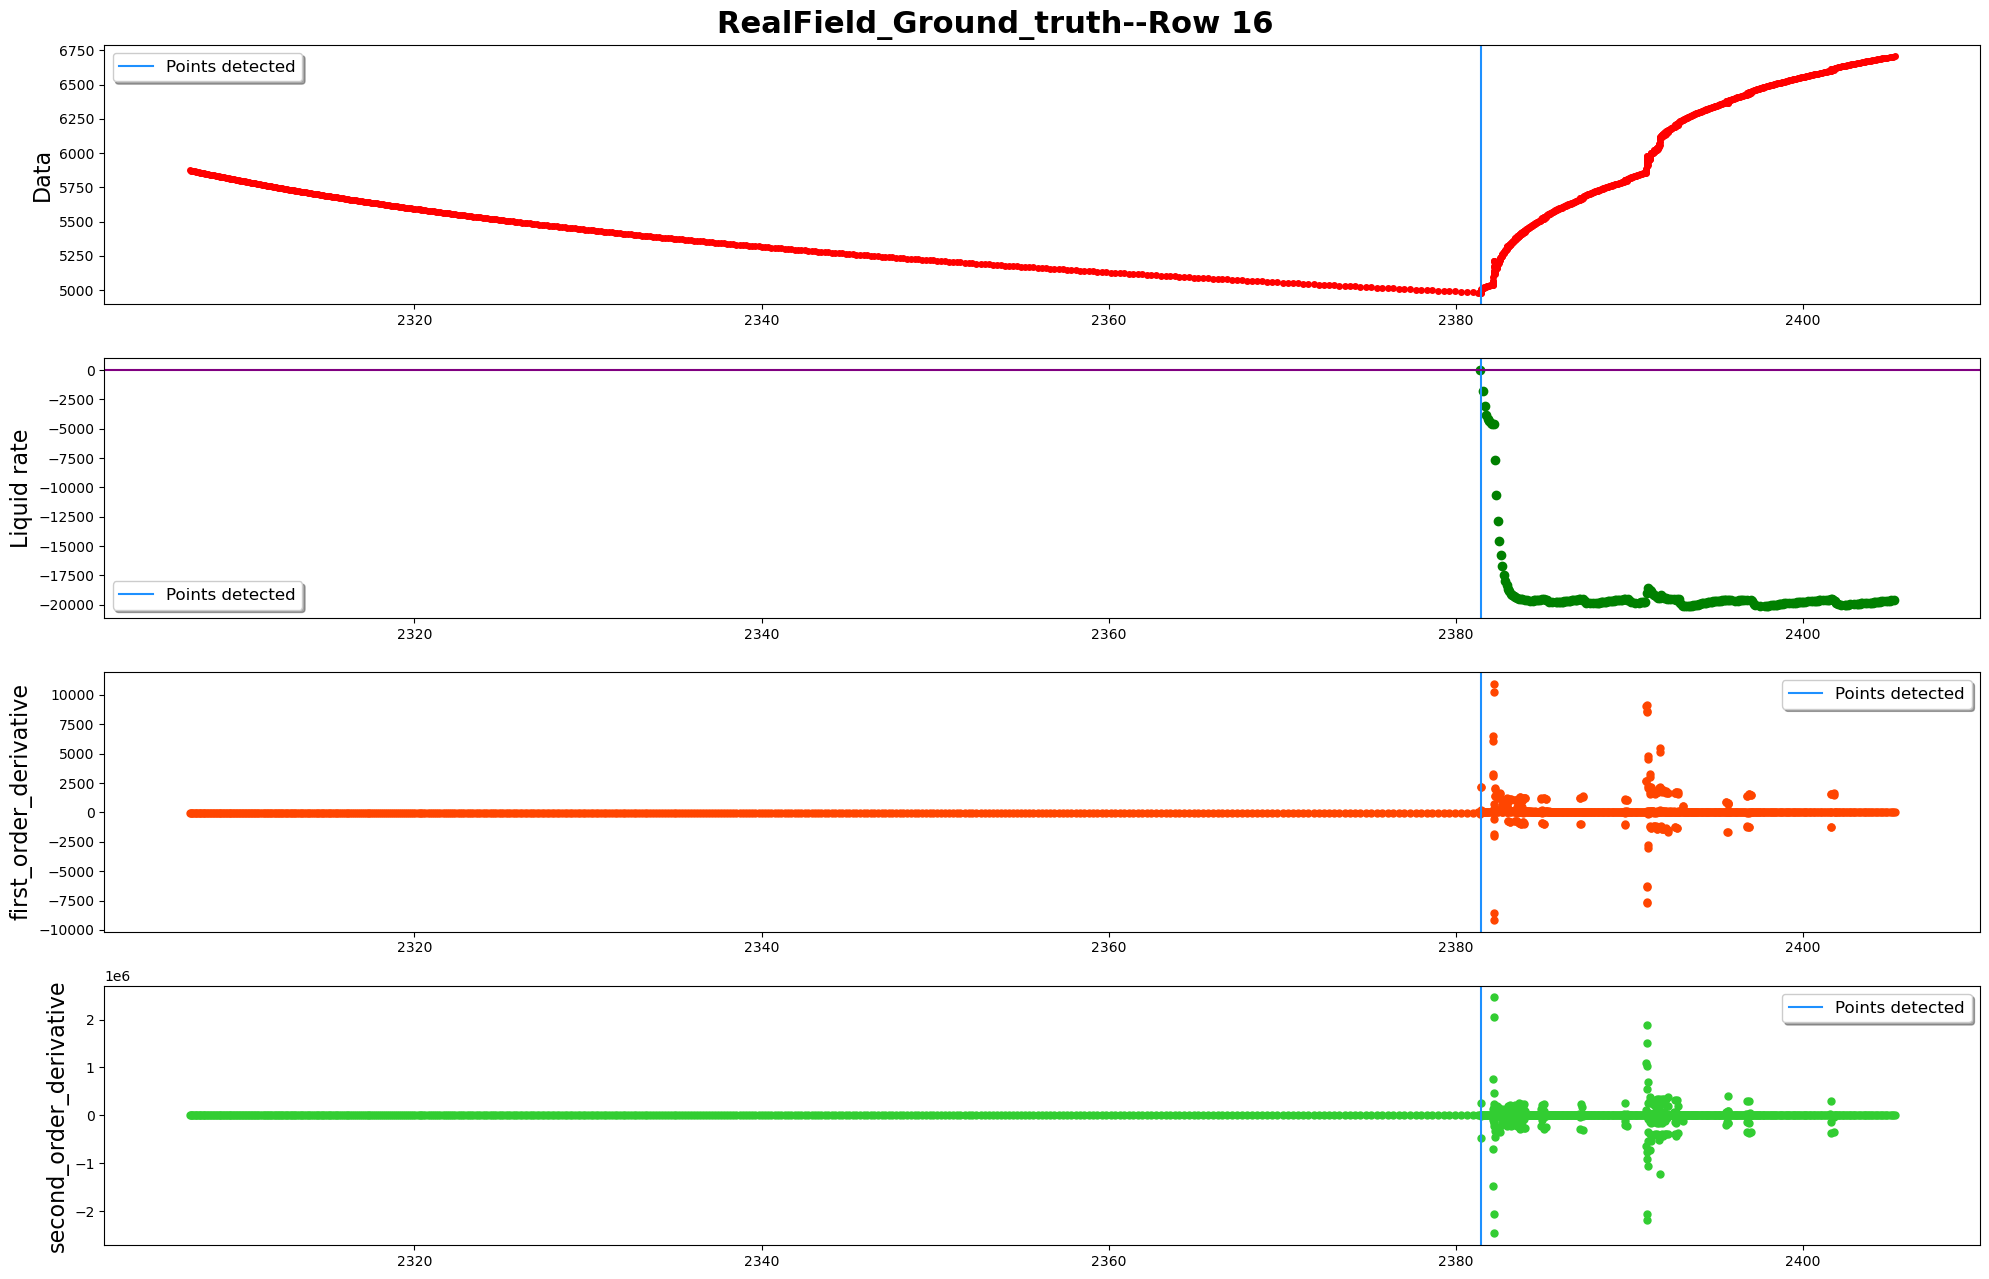

------row 17-----detected points:[19643, 19764, 20021, 20349]


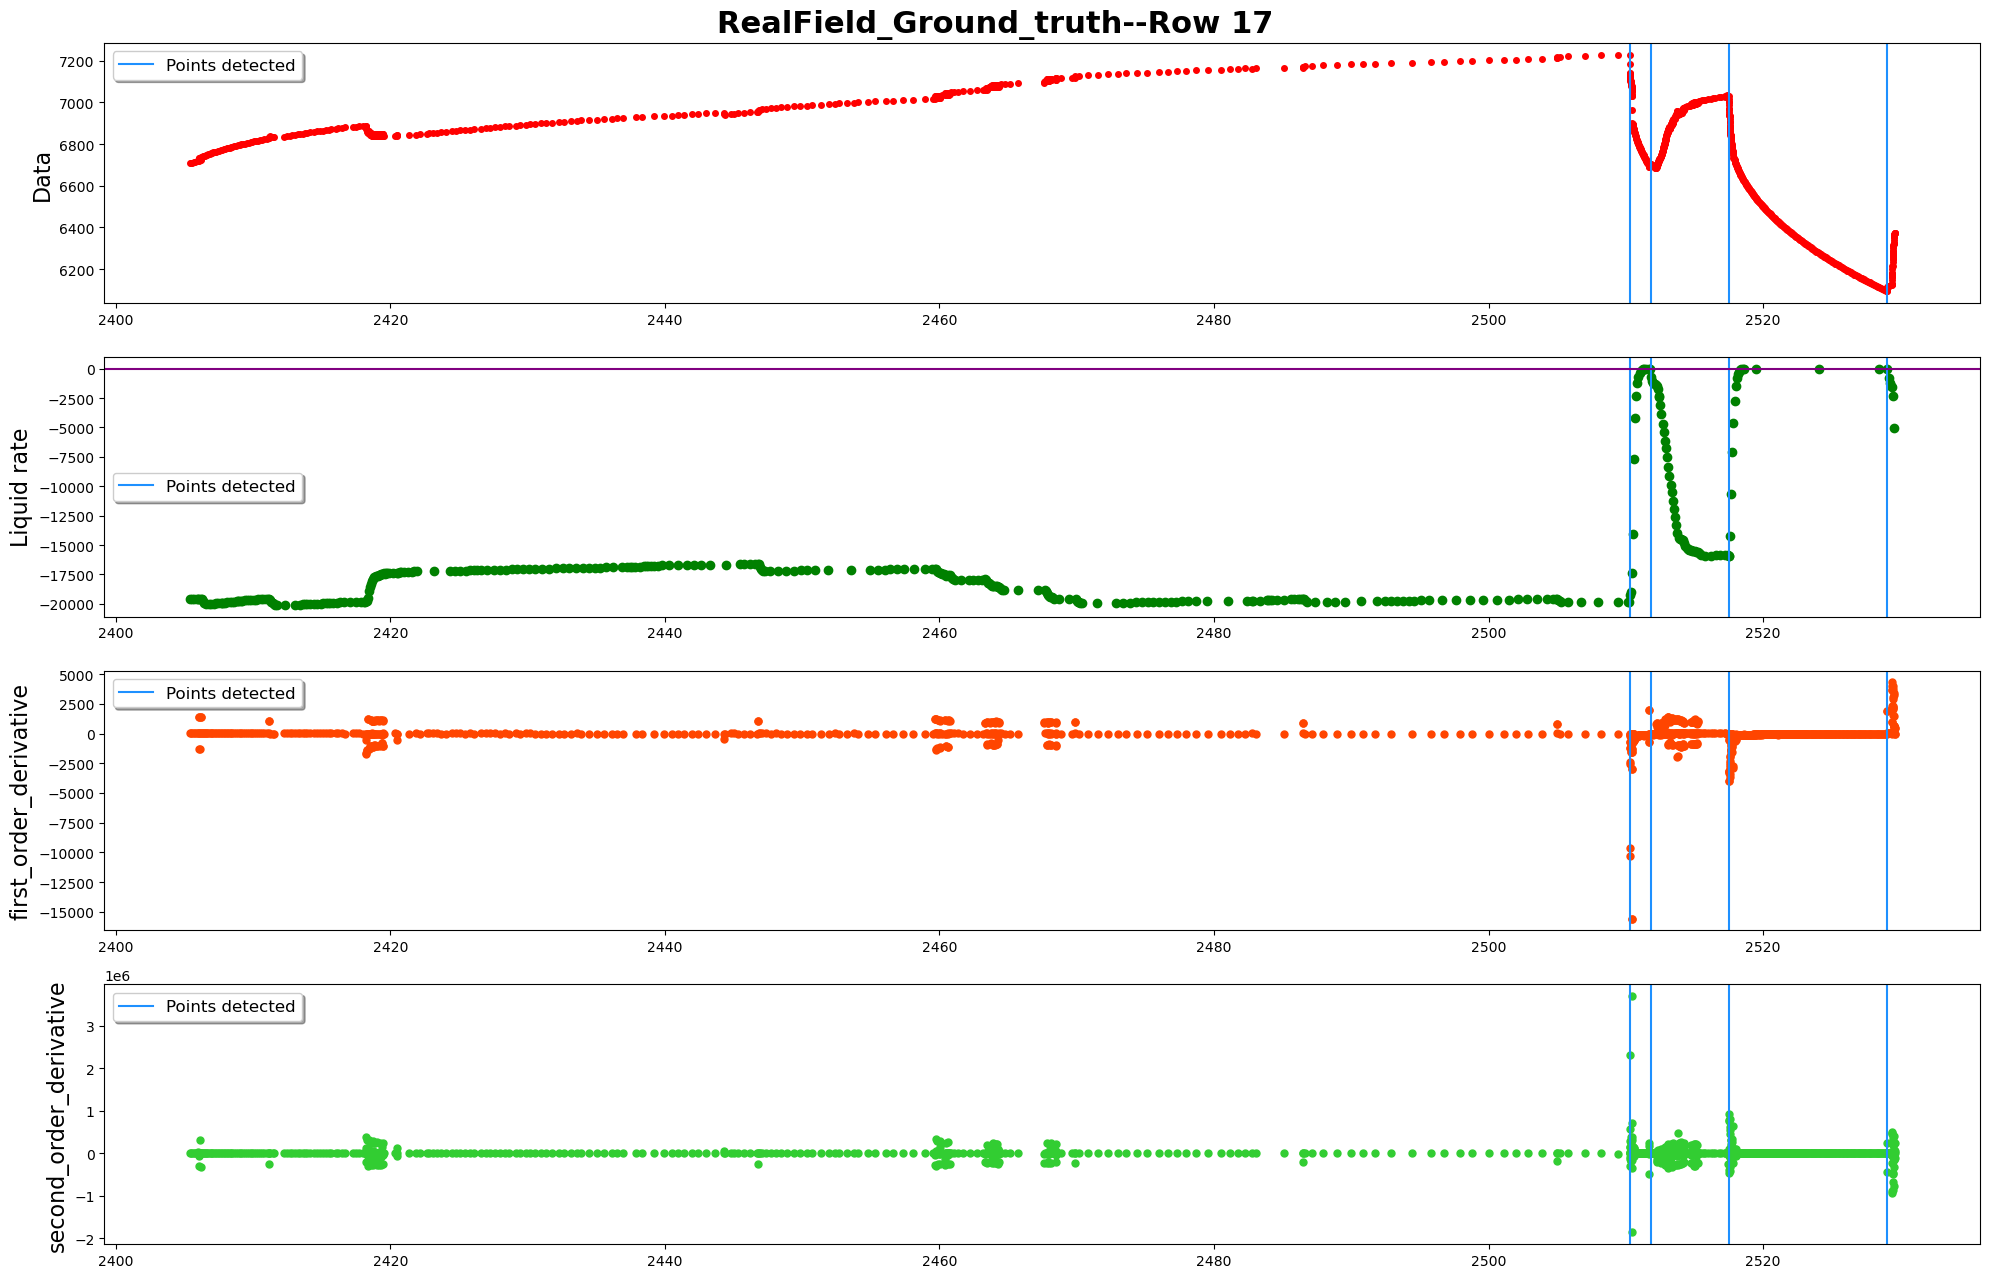

------row 18-----detected points:[20701, 21030]


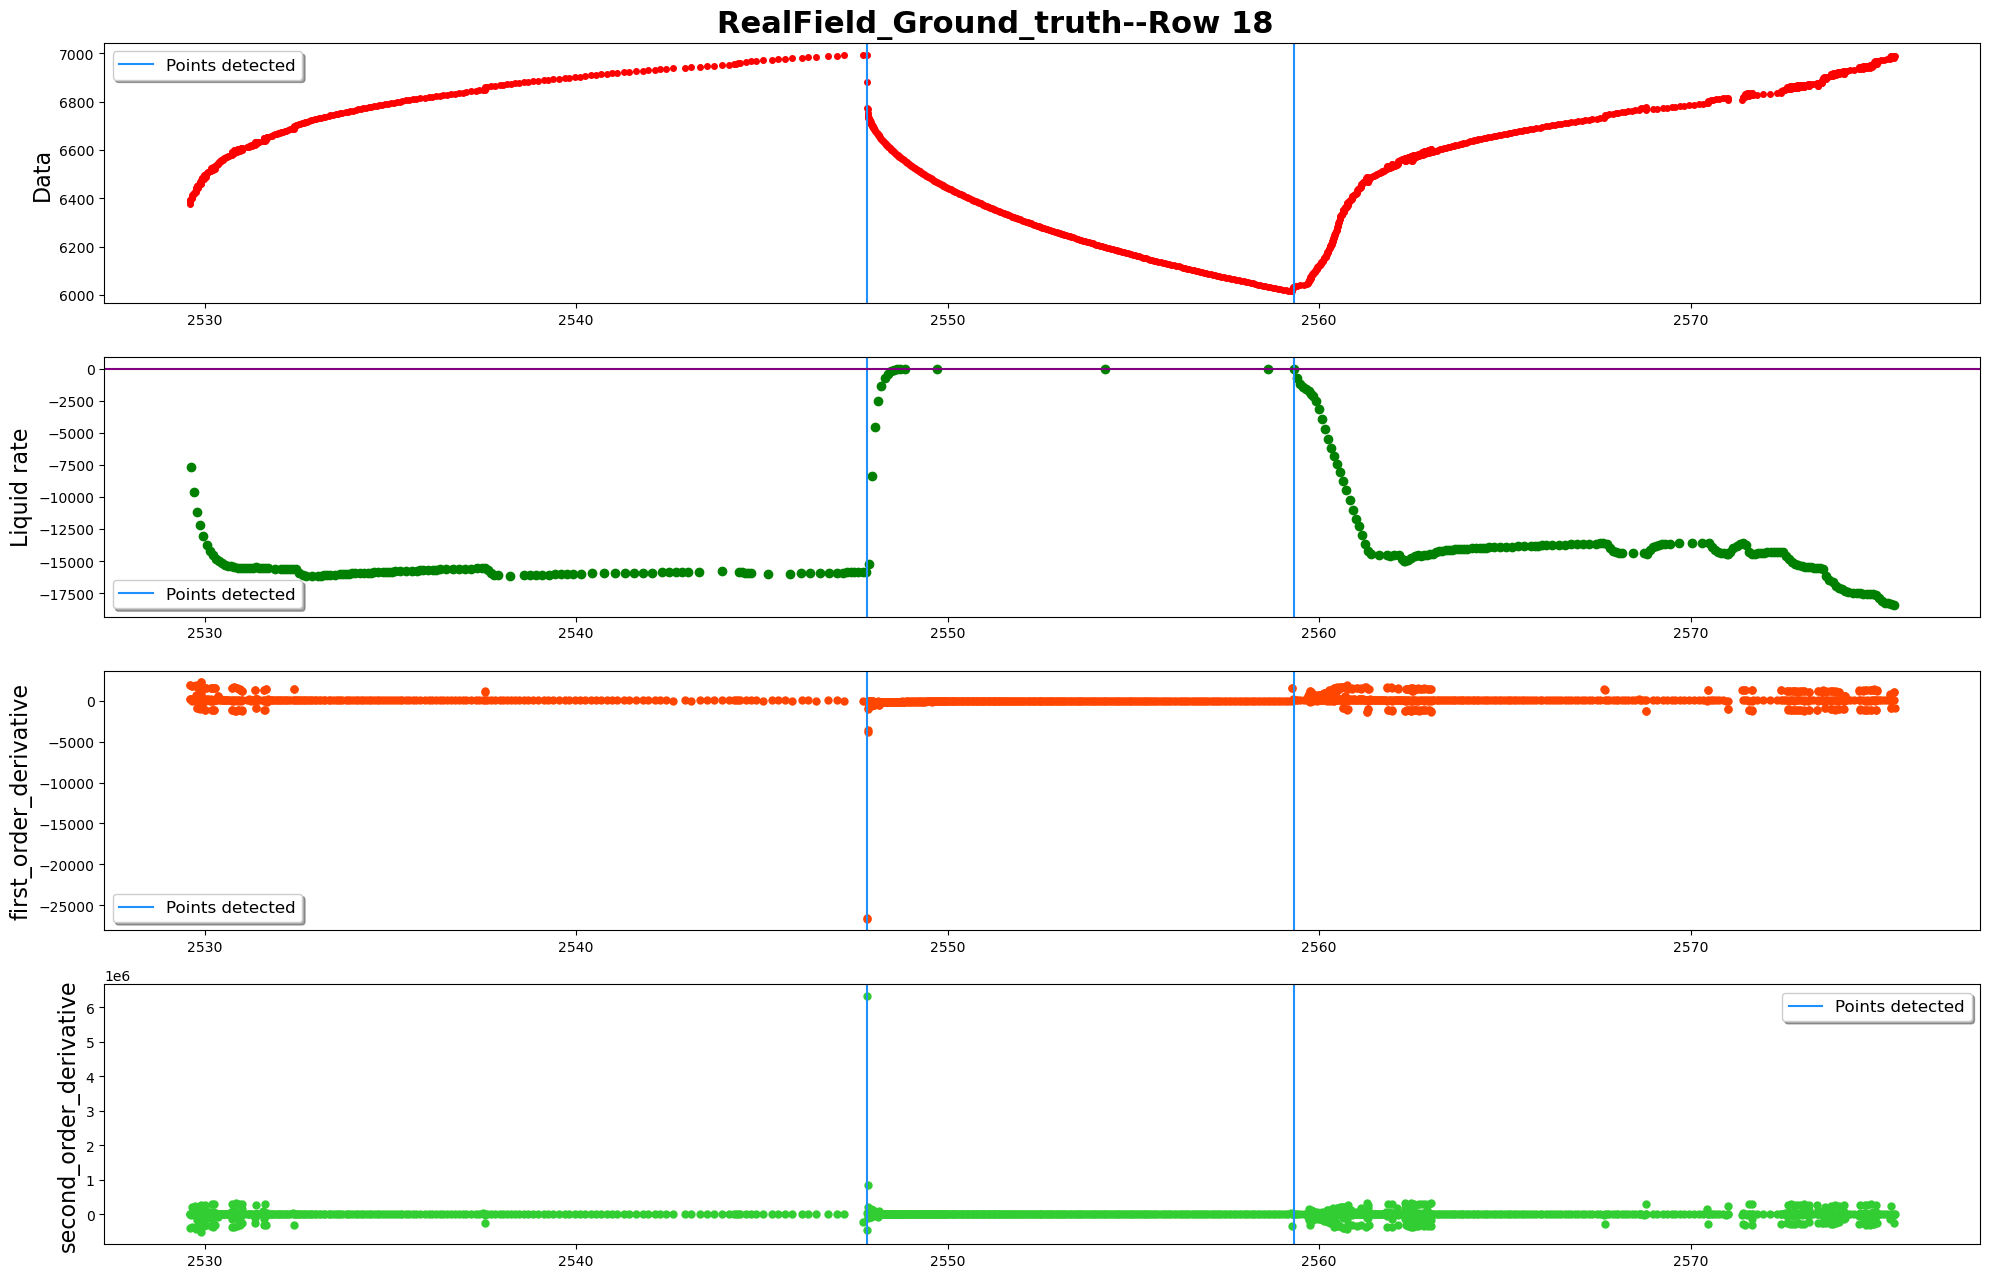

------row 19-----detected points:[21974, 22186, 22710]


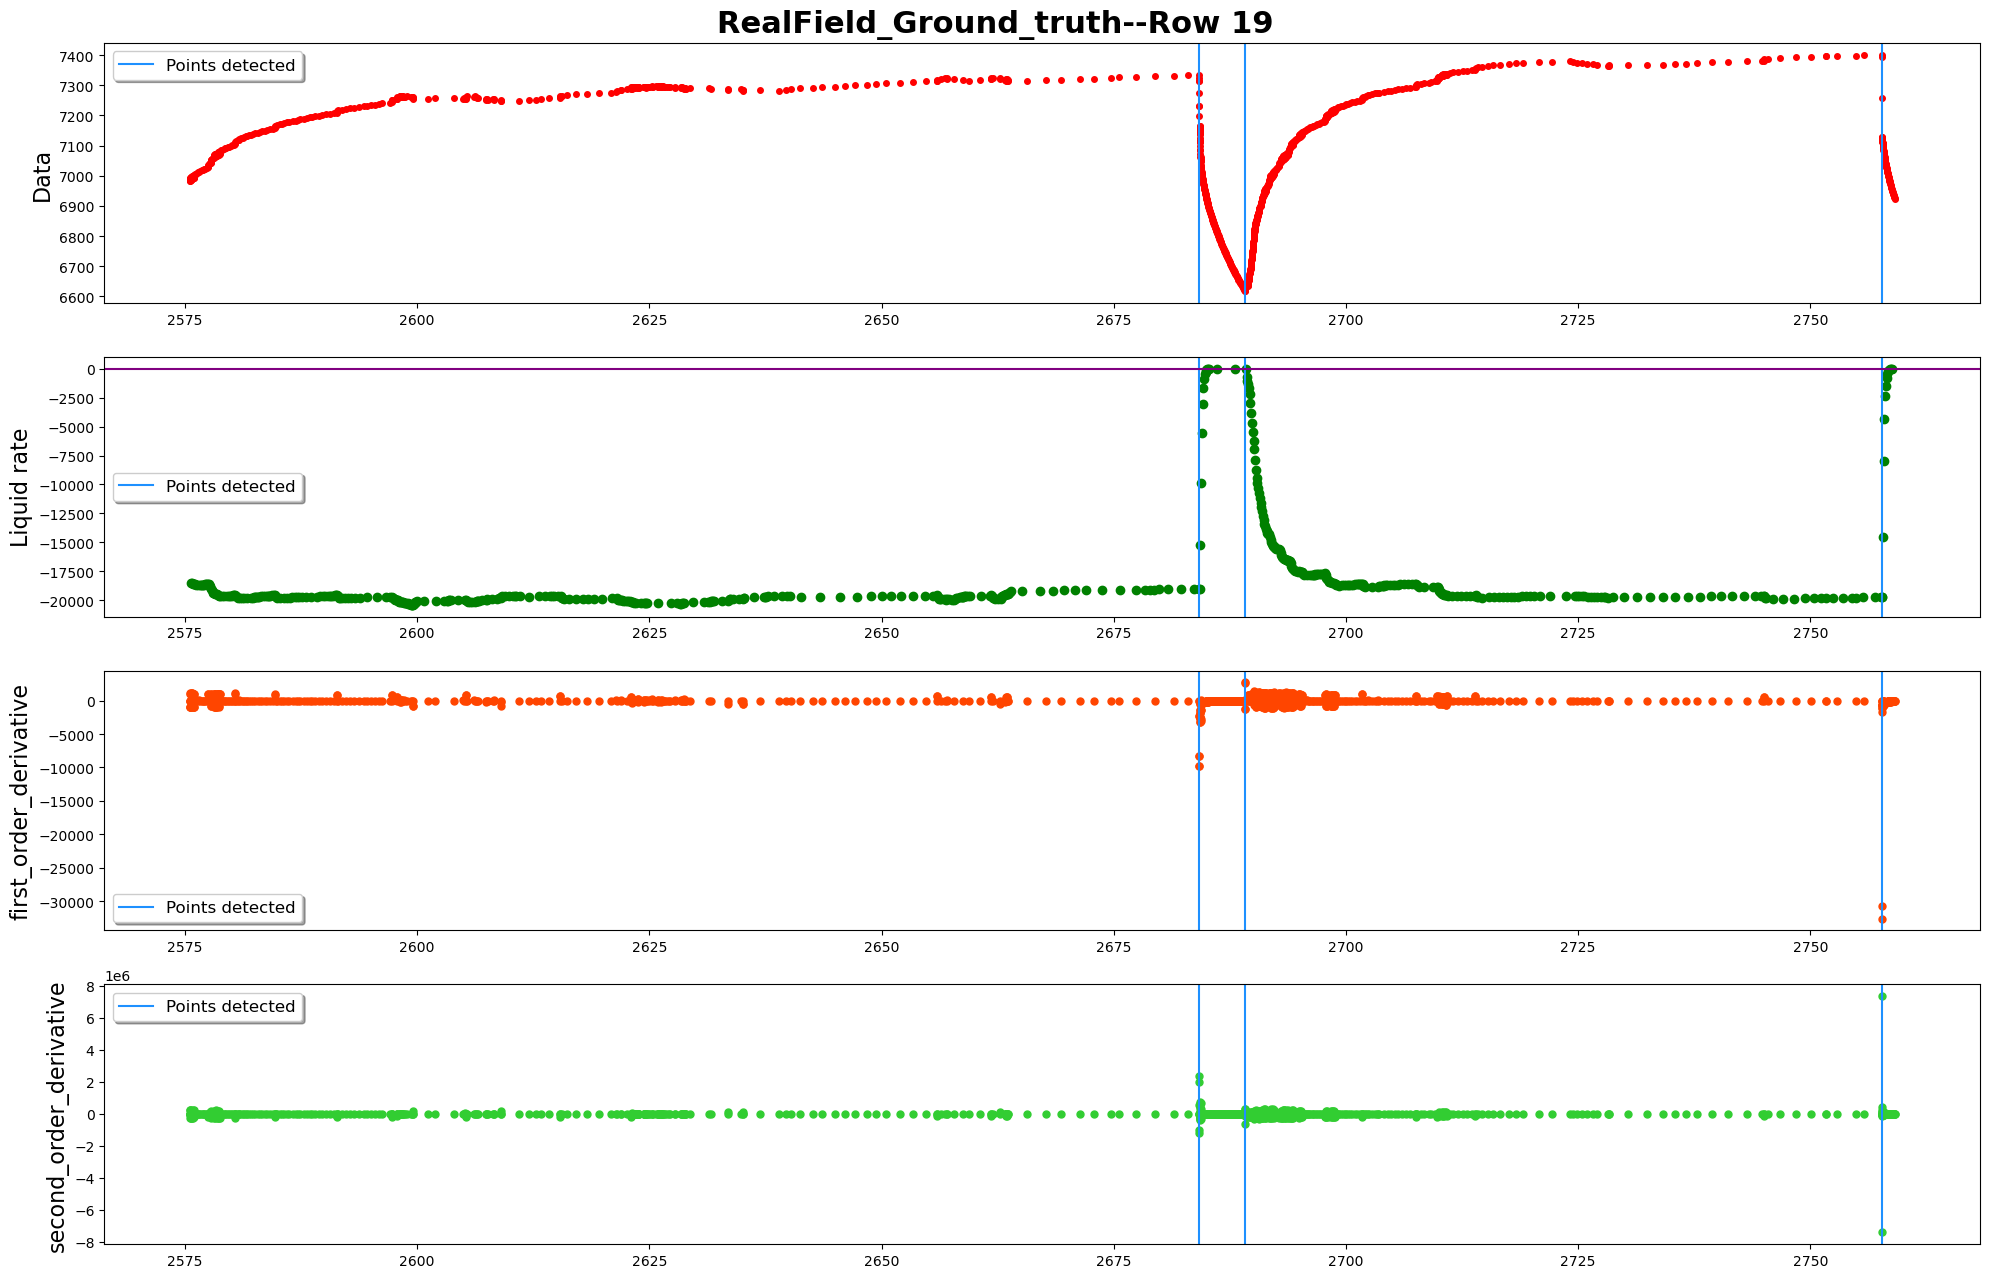

------row 20-----detected points:[23220]


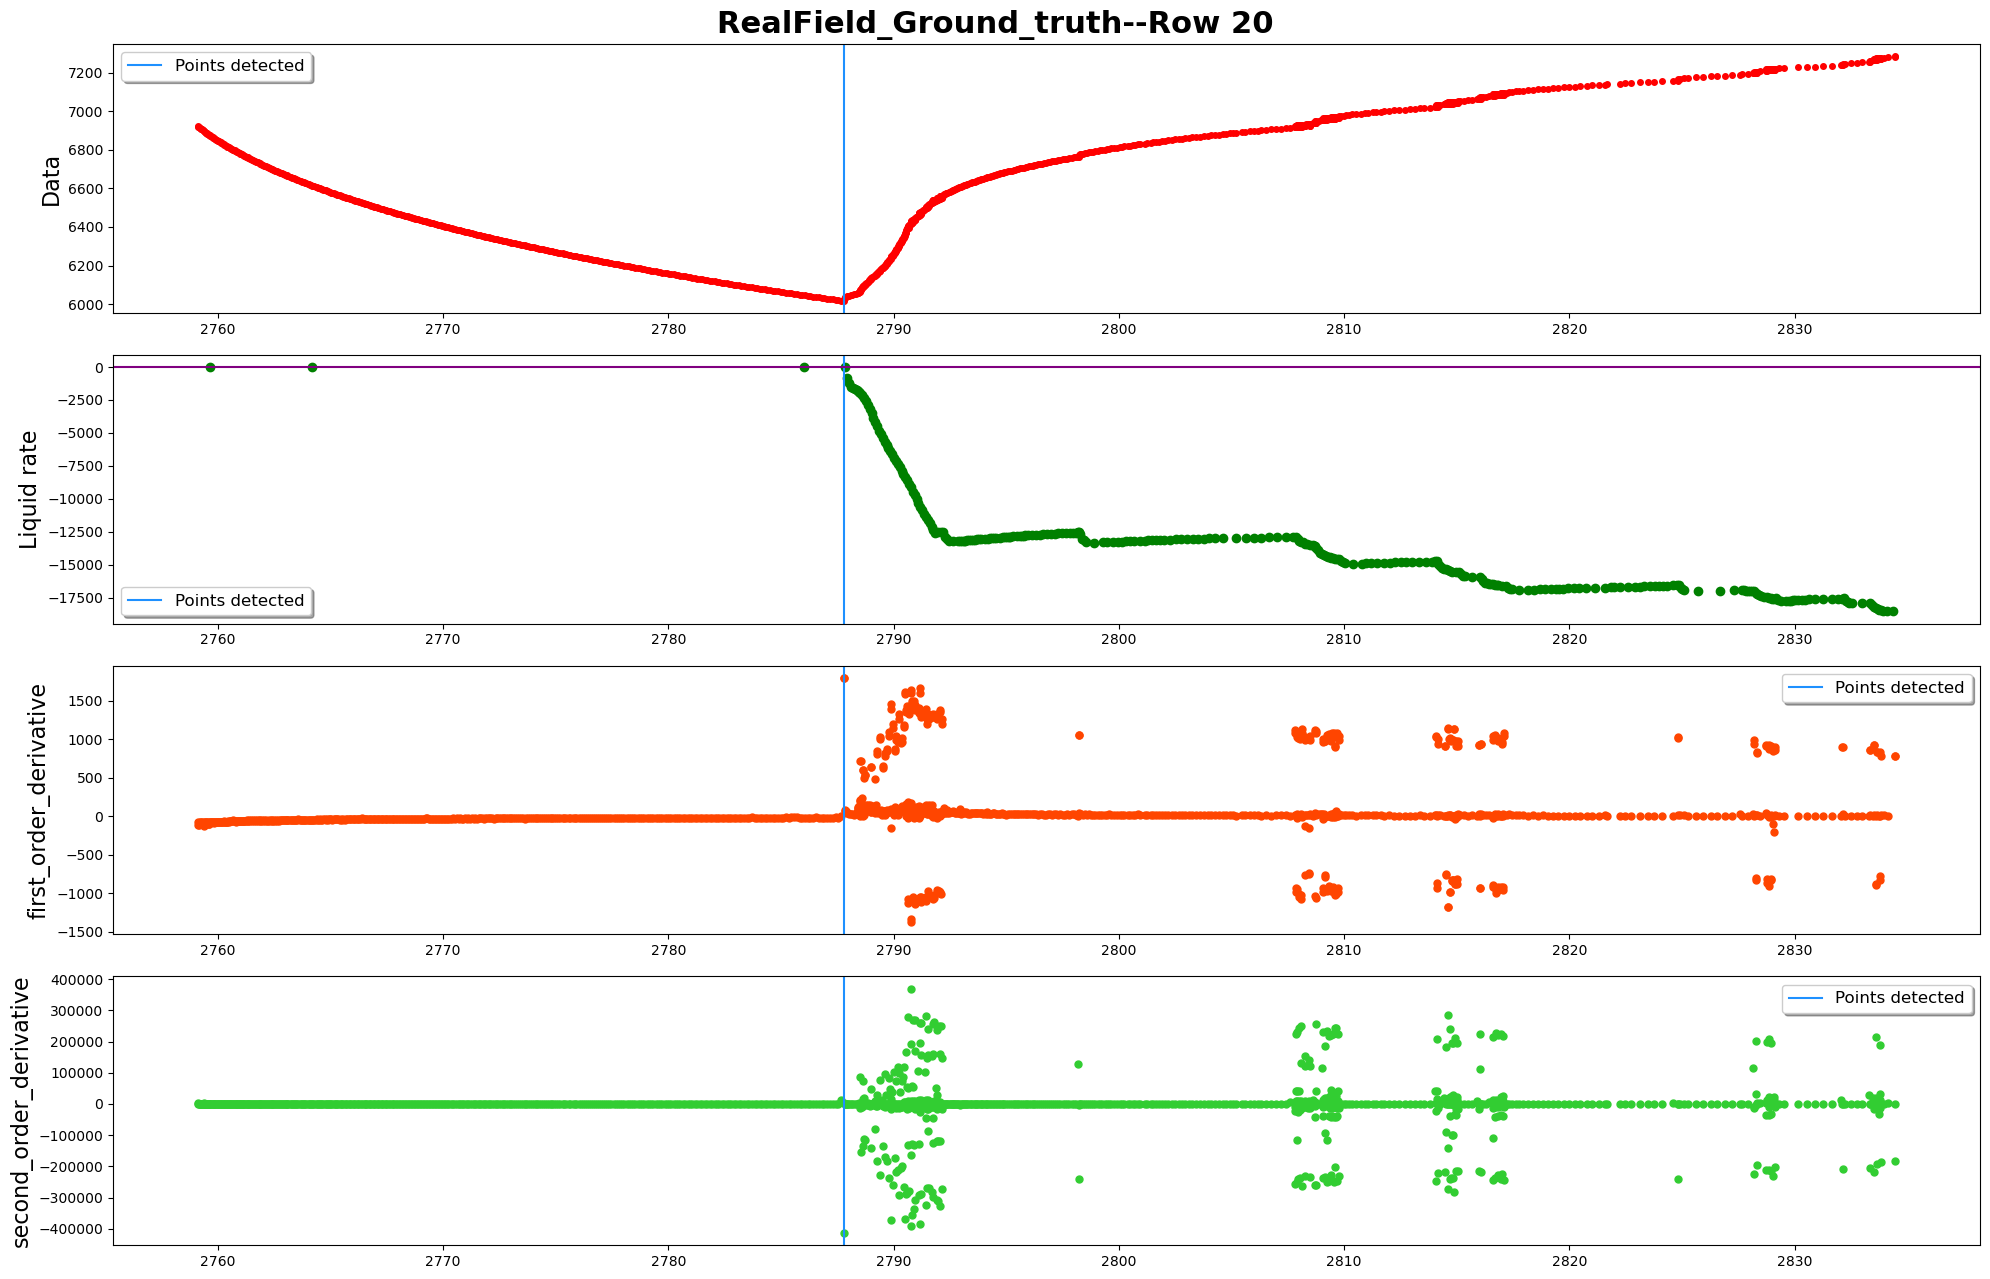

------row 21-----detected points:[24215, 24685]


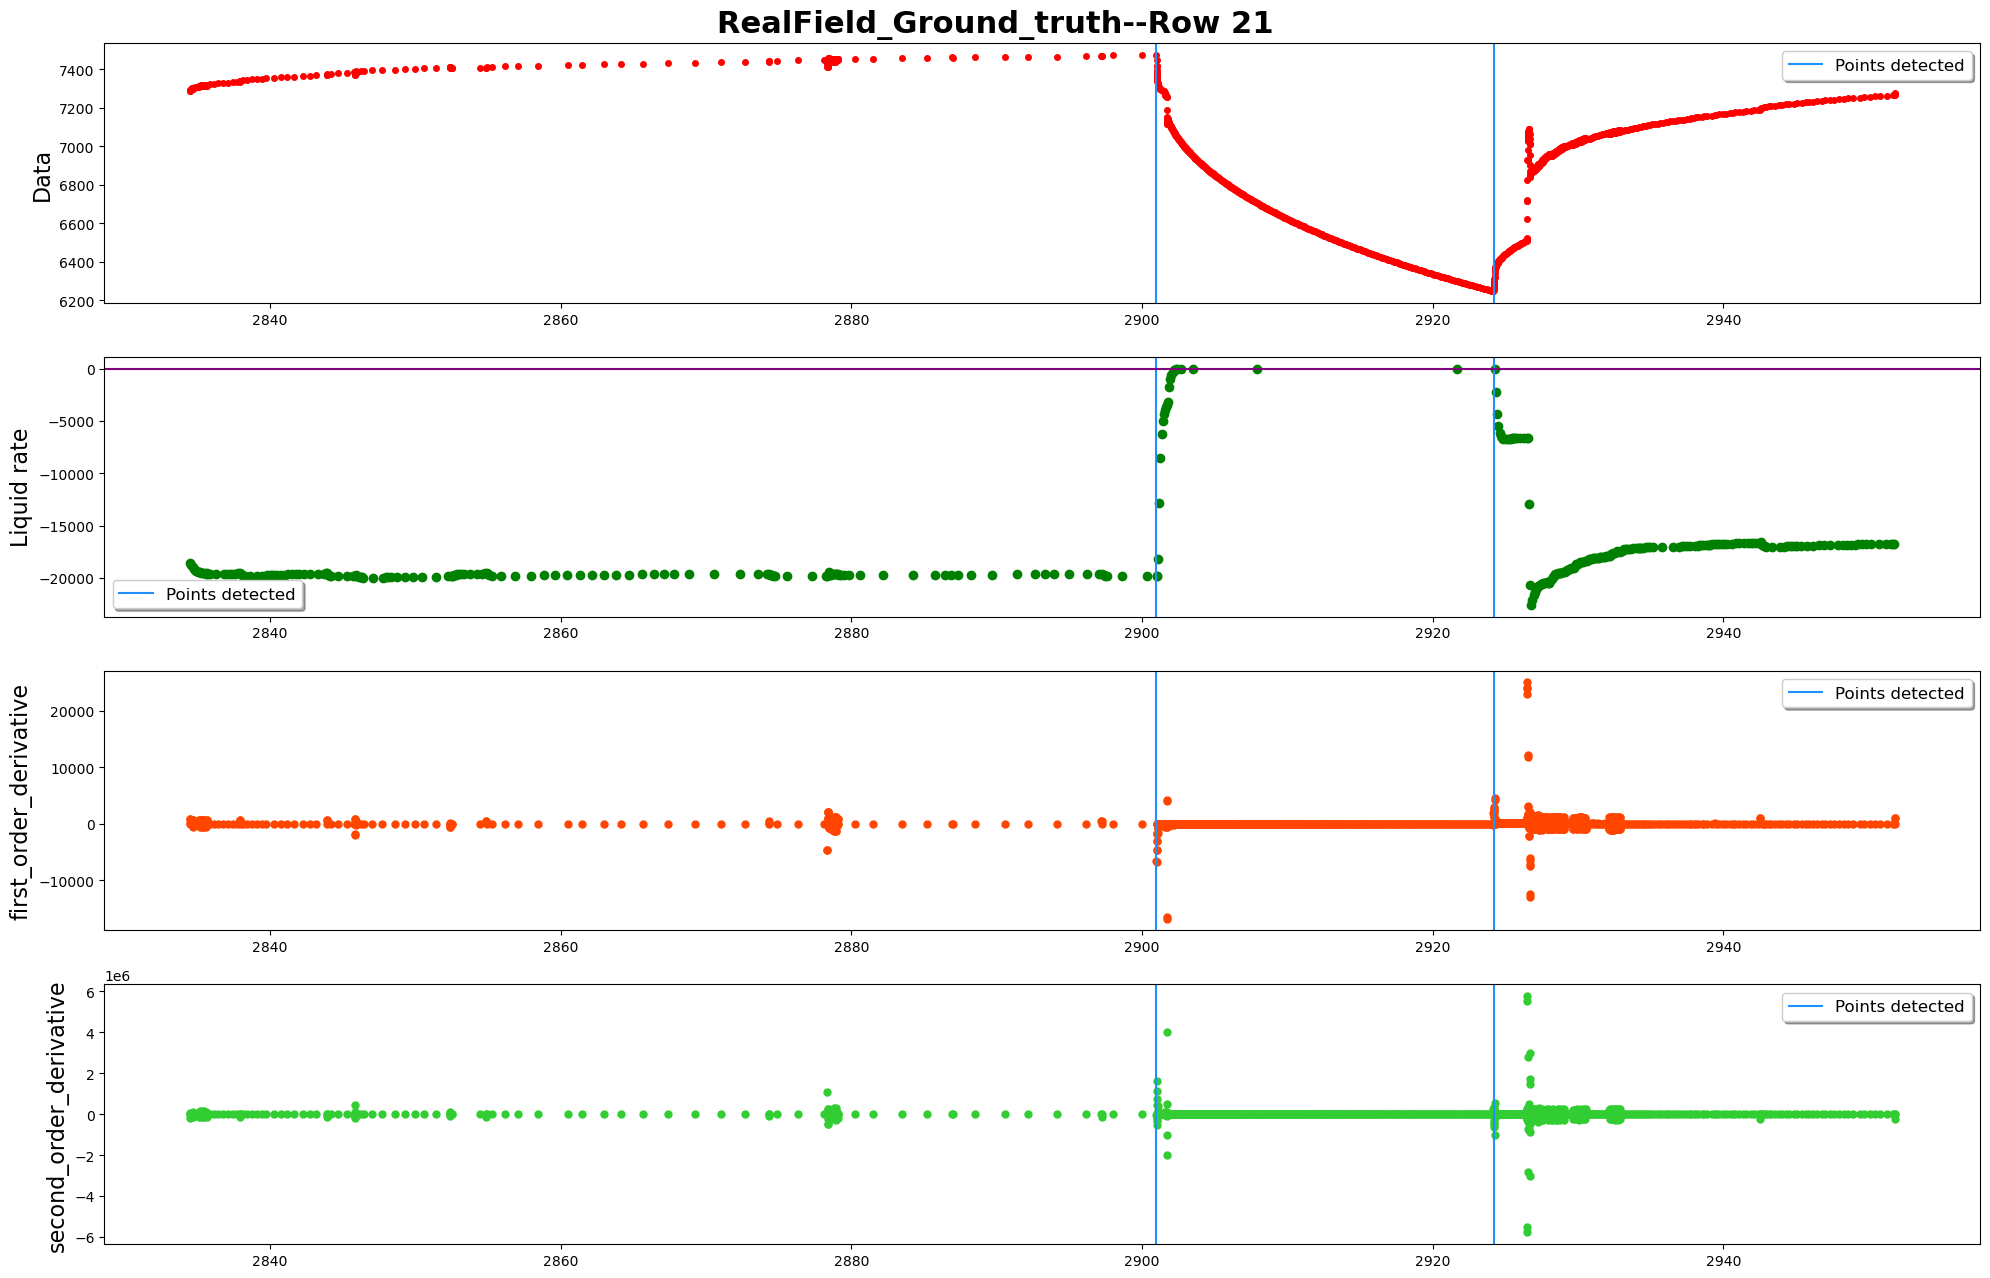

------row 22-----detected points:[25717, 26006]


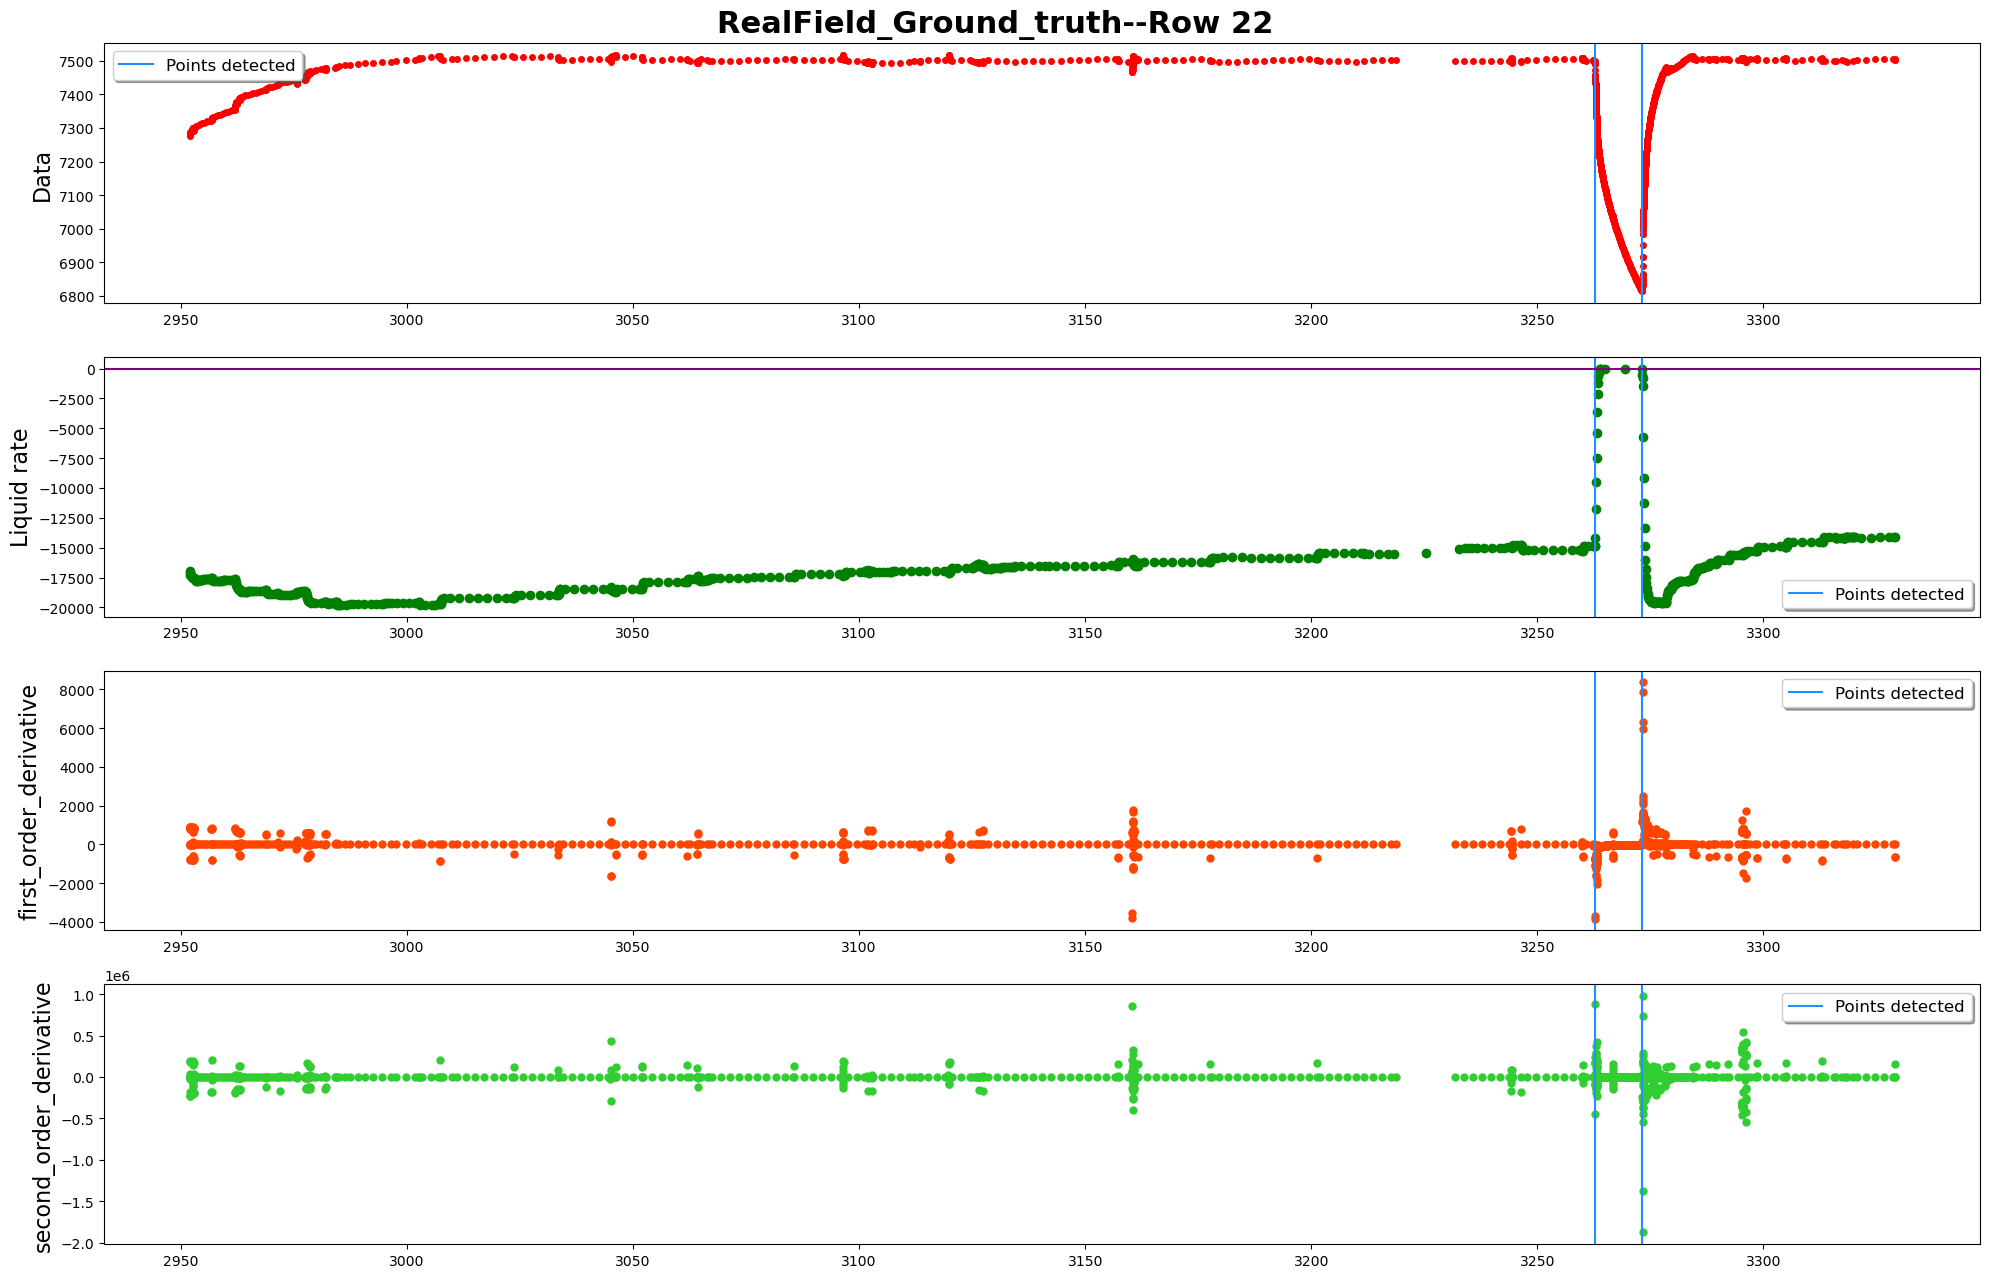

------row 23-----detected points:[26656, 26759, 27023, 27322]


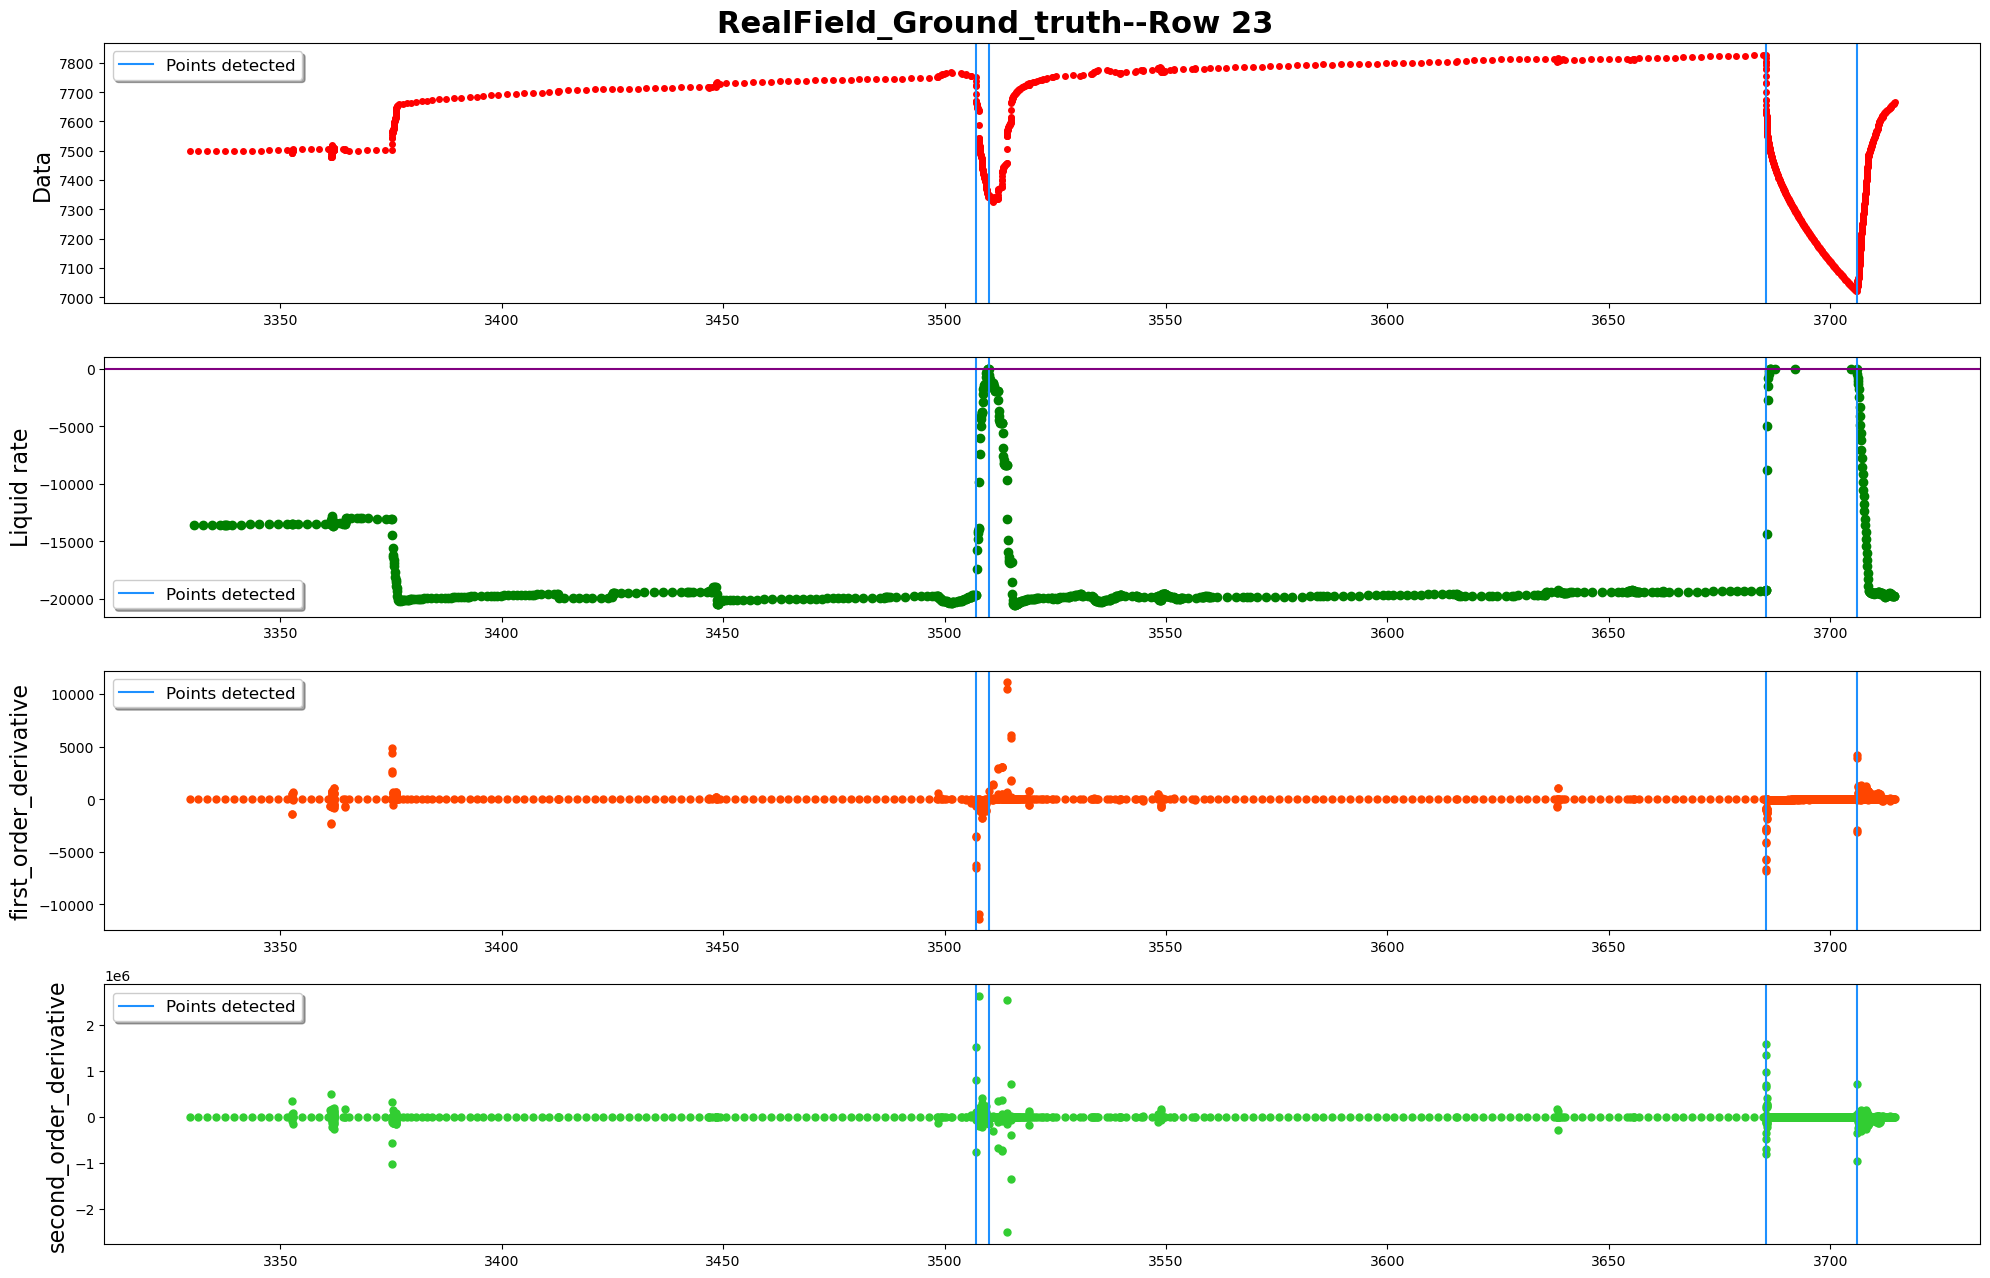

------row 24-----detected points:[27773, 27968, 28322, 28497]


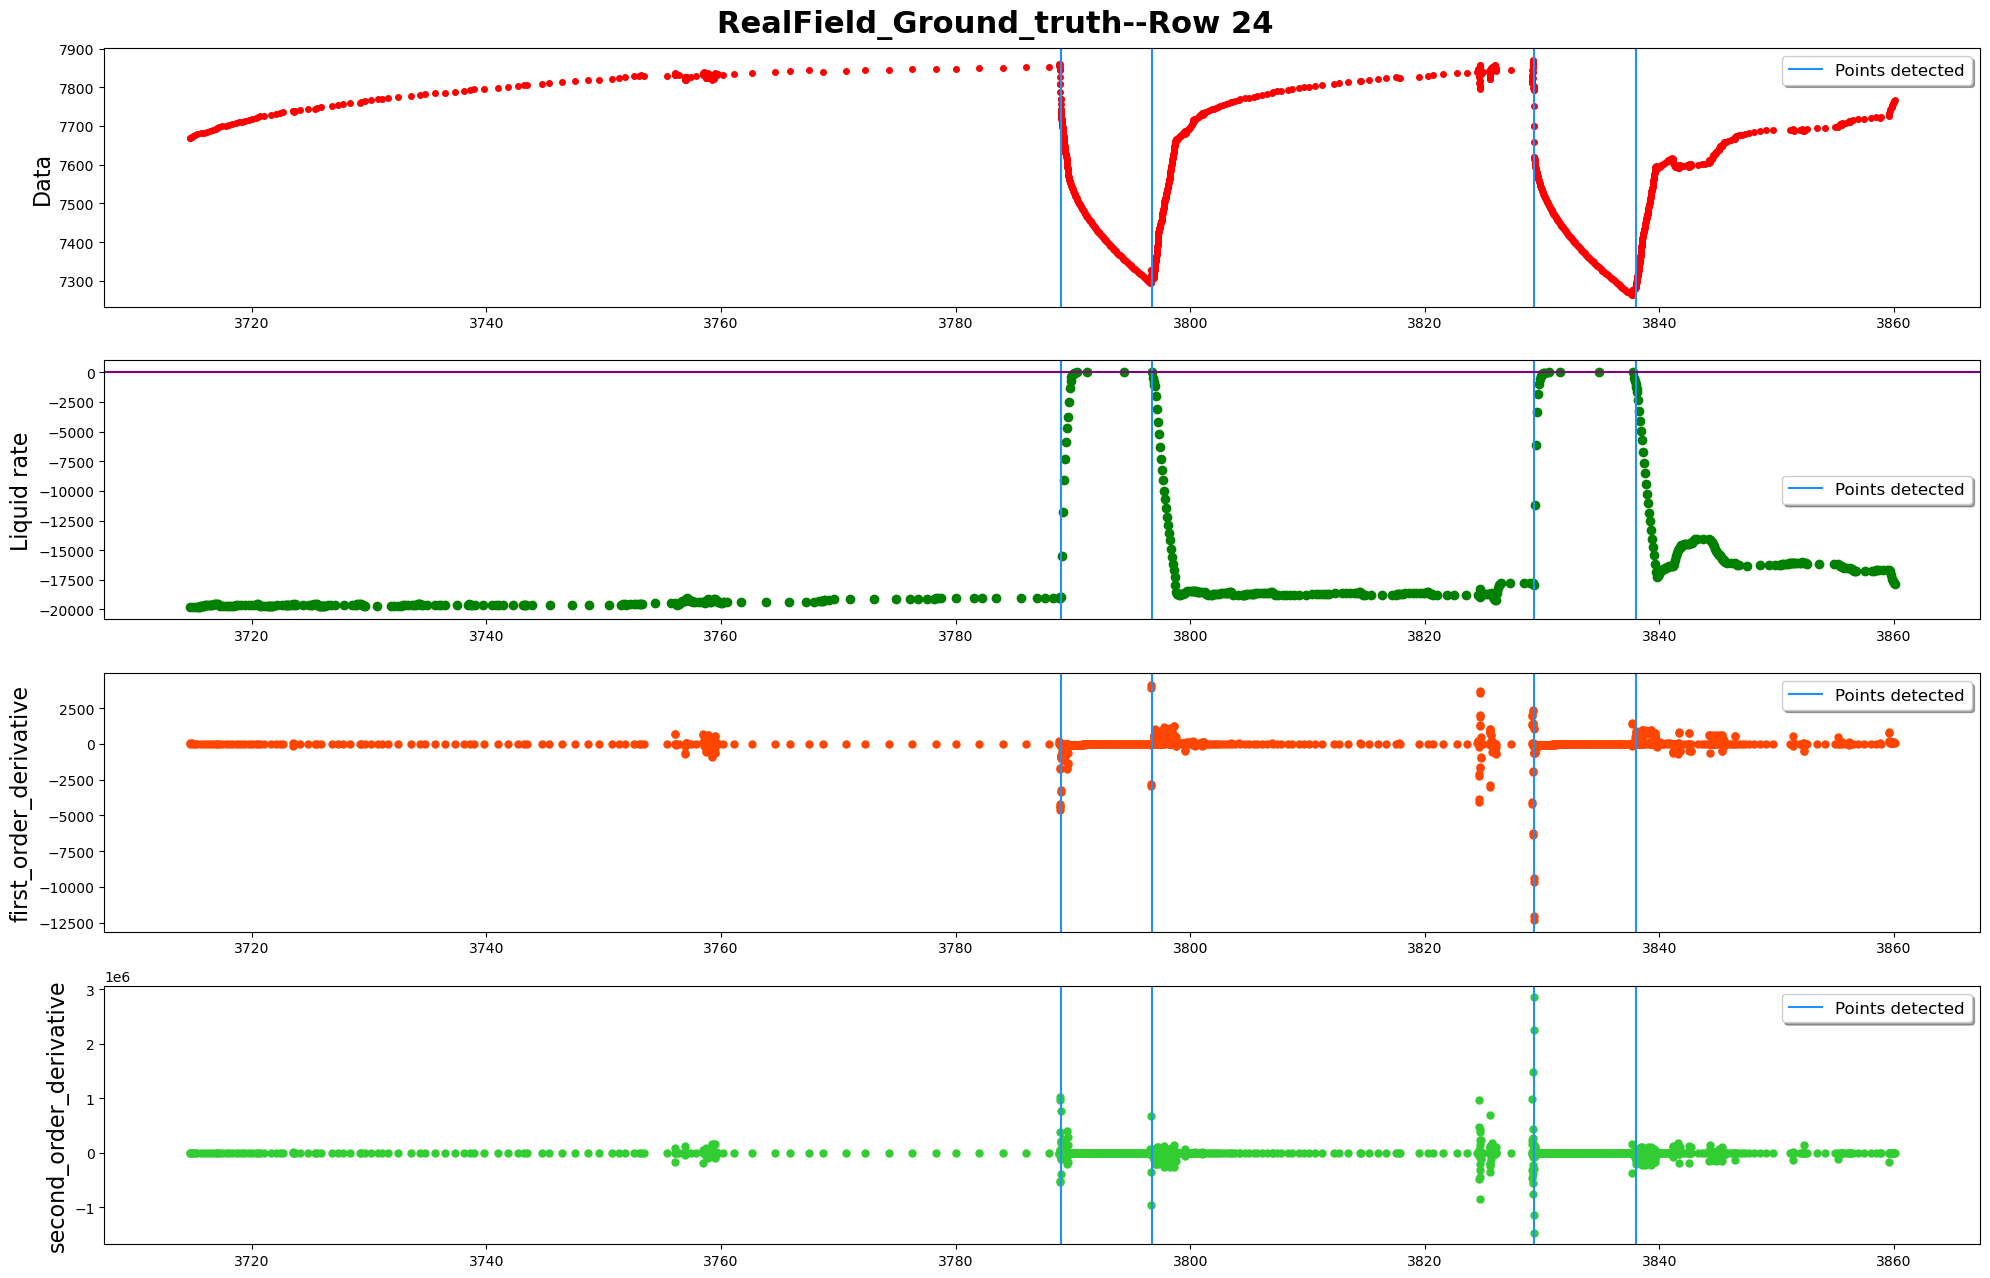

------row 25-----detected points:[28832, 29115]


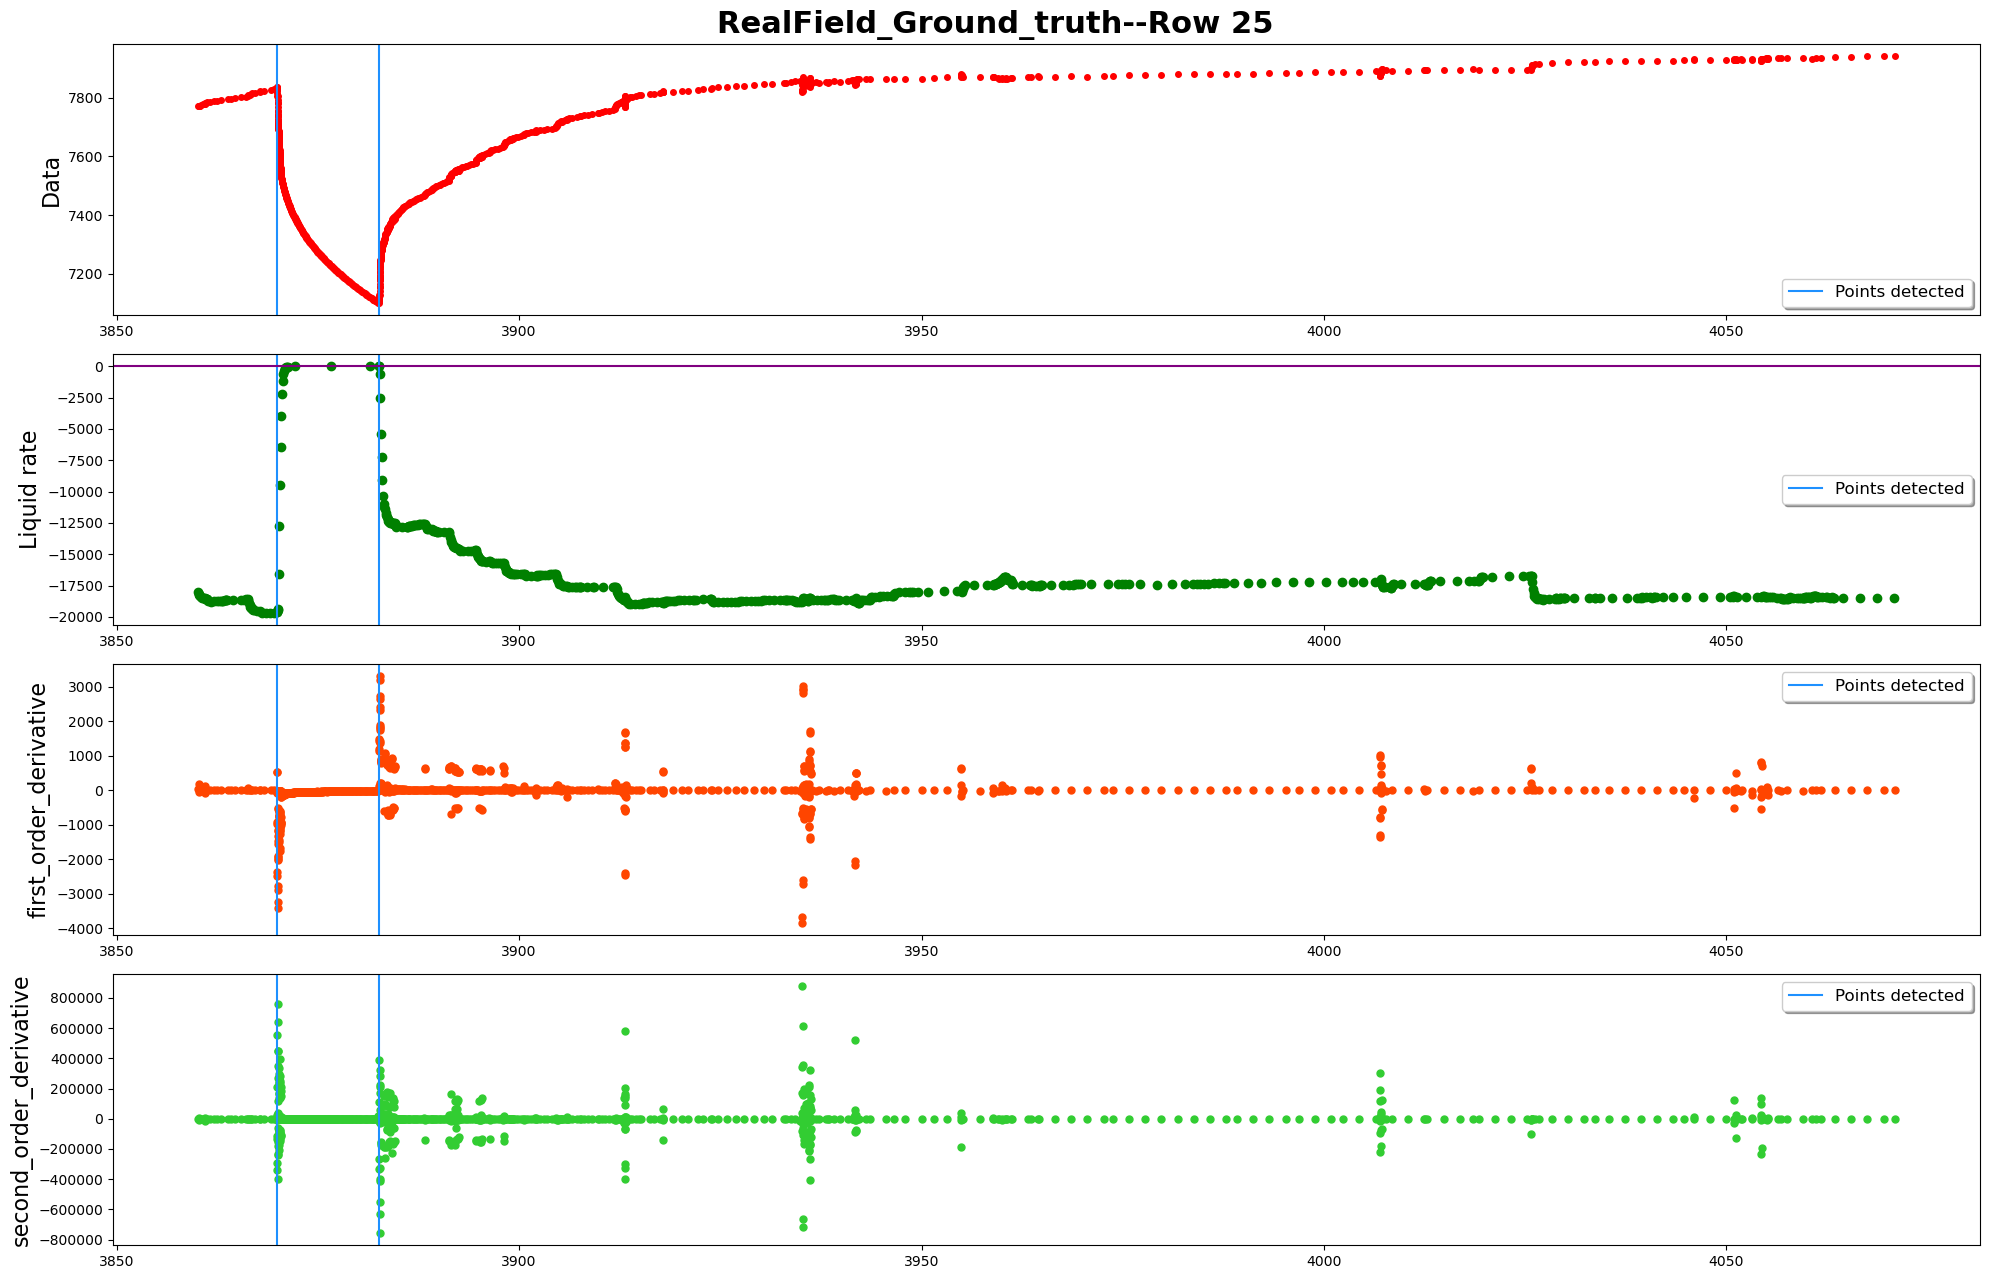

In [18]:
#plot ground truth
#plot & save
data_inOneRow=1200
filename_toSave="../data_output/RealField_Ground_truth.pdf"
plot_name="RealField_Ground_truth"
plot_whole=False
plot_details=True
plot_statistics=False
PlotNSave(pressure_df,
          rate_df,
          ground_truth,
          [],
          data_inOneRow,
          plot_name,
          filename_toSave,
          plot_statistics,
          plot_whole,
          plot_details,
          colum_names)

In [ ]:
# breakpoints_detected=detect_breakpoints_2(first_order_derivative,second_order_derivative)
# print(len(breakpoints_detected))
# # print(breakpoints_detected)

## Baseline method

In [ ]:
#baseline method
noise_threshold=1.7
breakpoints_detected_3=detect_breakpoints_3(first_order_derivative,second_order_derivative,noise_threshold)
print(len(breakpoints_detected_3))
# print(breakpoints_detected)

In [ ]:
#plot & save
ground_truth=[]
filename_toSave="../data_output/RealField_baseline_method_RawData.pdf"
plot_name="RealField_baseline_method_RawData"
plot_whole=True
plot_details=True
plot_statistics=True
PlotNSave(pressure_df,
          rate_df,
          breakpoints_detected_3,
          ground_truth,
          data_inOneRow,
          plot_name,
          filename_toSave,
          plot_statistics,
          plot_whole,
          plot_details,
          colum_names)

# S-G smoothing

---load data from 'txt' or 'xlsx' files...
check the time type
---denoising data using S-G smoothing...
---The first & second order derivative has been calculated and appended to pressure dataframe
std_1:217.076859984311,std_2:26067.263415502584


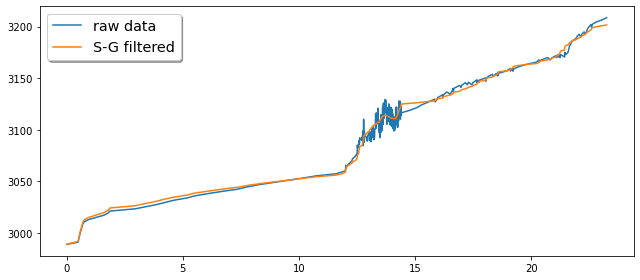

In [19]:
processed_data_denoised=LoadNPreprocessData(pressure_filePath=pressure_filePath, 
                 rate_filePath=rate_filePath, 
                 colum_names=colum_names, 
                 use_SG_smoothing=True)
pressure_df_denoised=processed_data_denoised.pressure_df
rate_df_denoised=processed_data_denoised.rate_df

# display(pressure_df_denoised)
# display(rate_df_denoised)
# display(processed_data_denoised.pressureNrate_df)

first_order_derivative_denoised=pressure_df_denoised["first_order_derivative"]
second_order_derivative_denoised=pressure_df_denoised["second_order_derivative"]
std_1_denoised=statistics.stdev(first_order_derivative_denoised)
std_2_denoised=statistics.stdev(second_order_derivative_denoised)
print(f"std_1:{std_1_denoised},std_2:{std_2_denoised}")
plot_nonDenoised_VS_Denoised(pressure_df.iloc[0:400,:],pressure_df_denoised.iloc[0:400,:],colum_names)

In [ ]:


calculate_points_interval(0,10,pressure_df_denoised,colum_names)

In [ ]:
# #S-G filter startPoint
# noise_threshold=3
# breakpoints_detected_startPoint=detect_breakpoints_startPoint(first_order_derivative,noise_threshold)
# print("len(breakpoints_detected)",len(breakpoints_detected_startPoint))

## Start point method

len(breakpoints_detected) 404
---initializing...
---plotting...
No ground truth defined


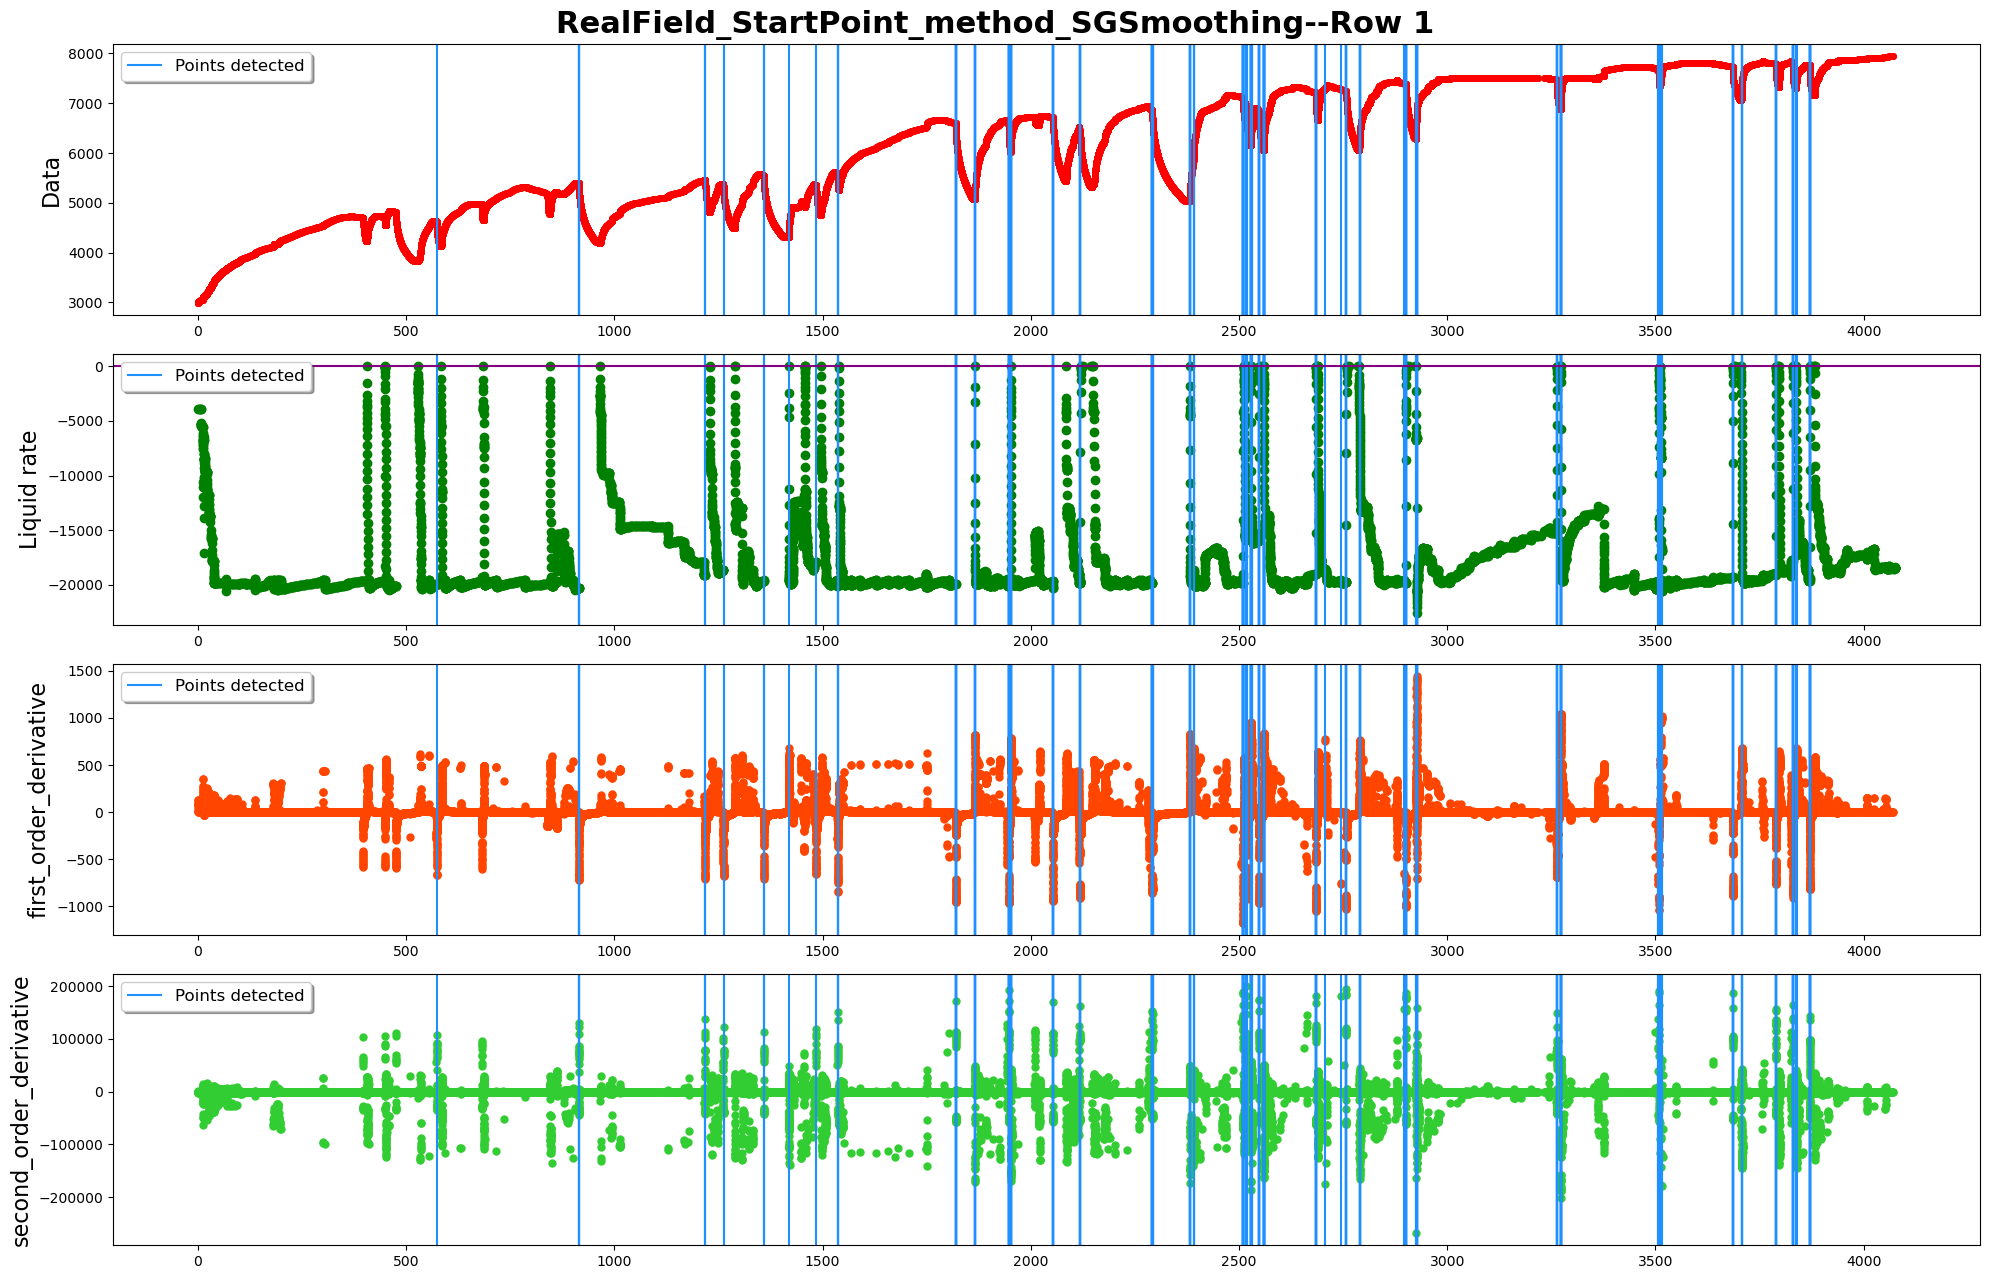

detected 404 points as breakpoints
The plot is devided into 25 rows
------row 1-----detected points:[]


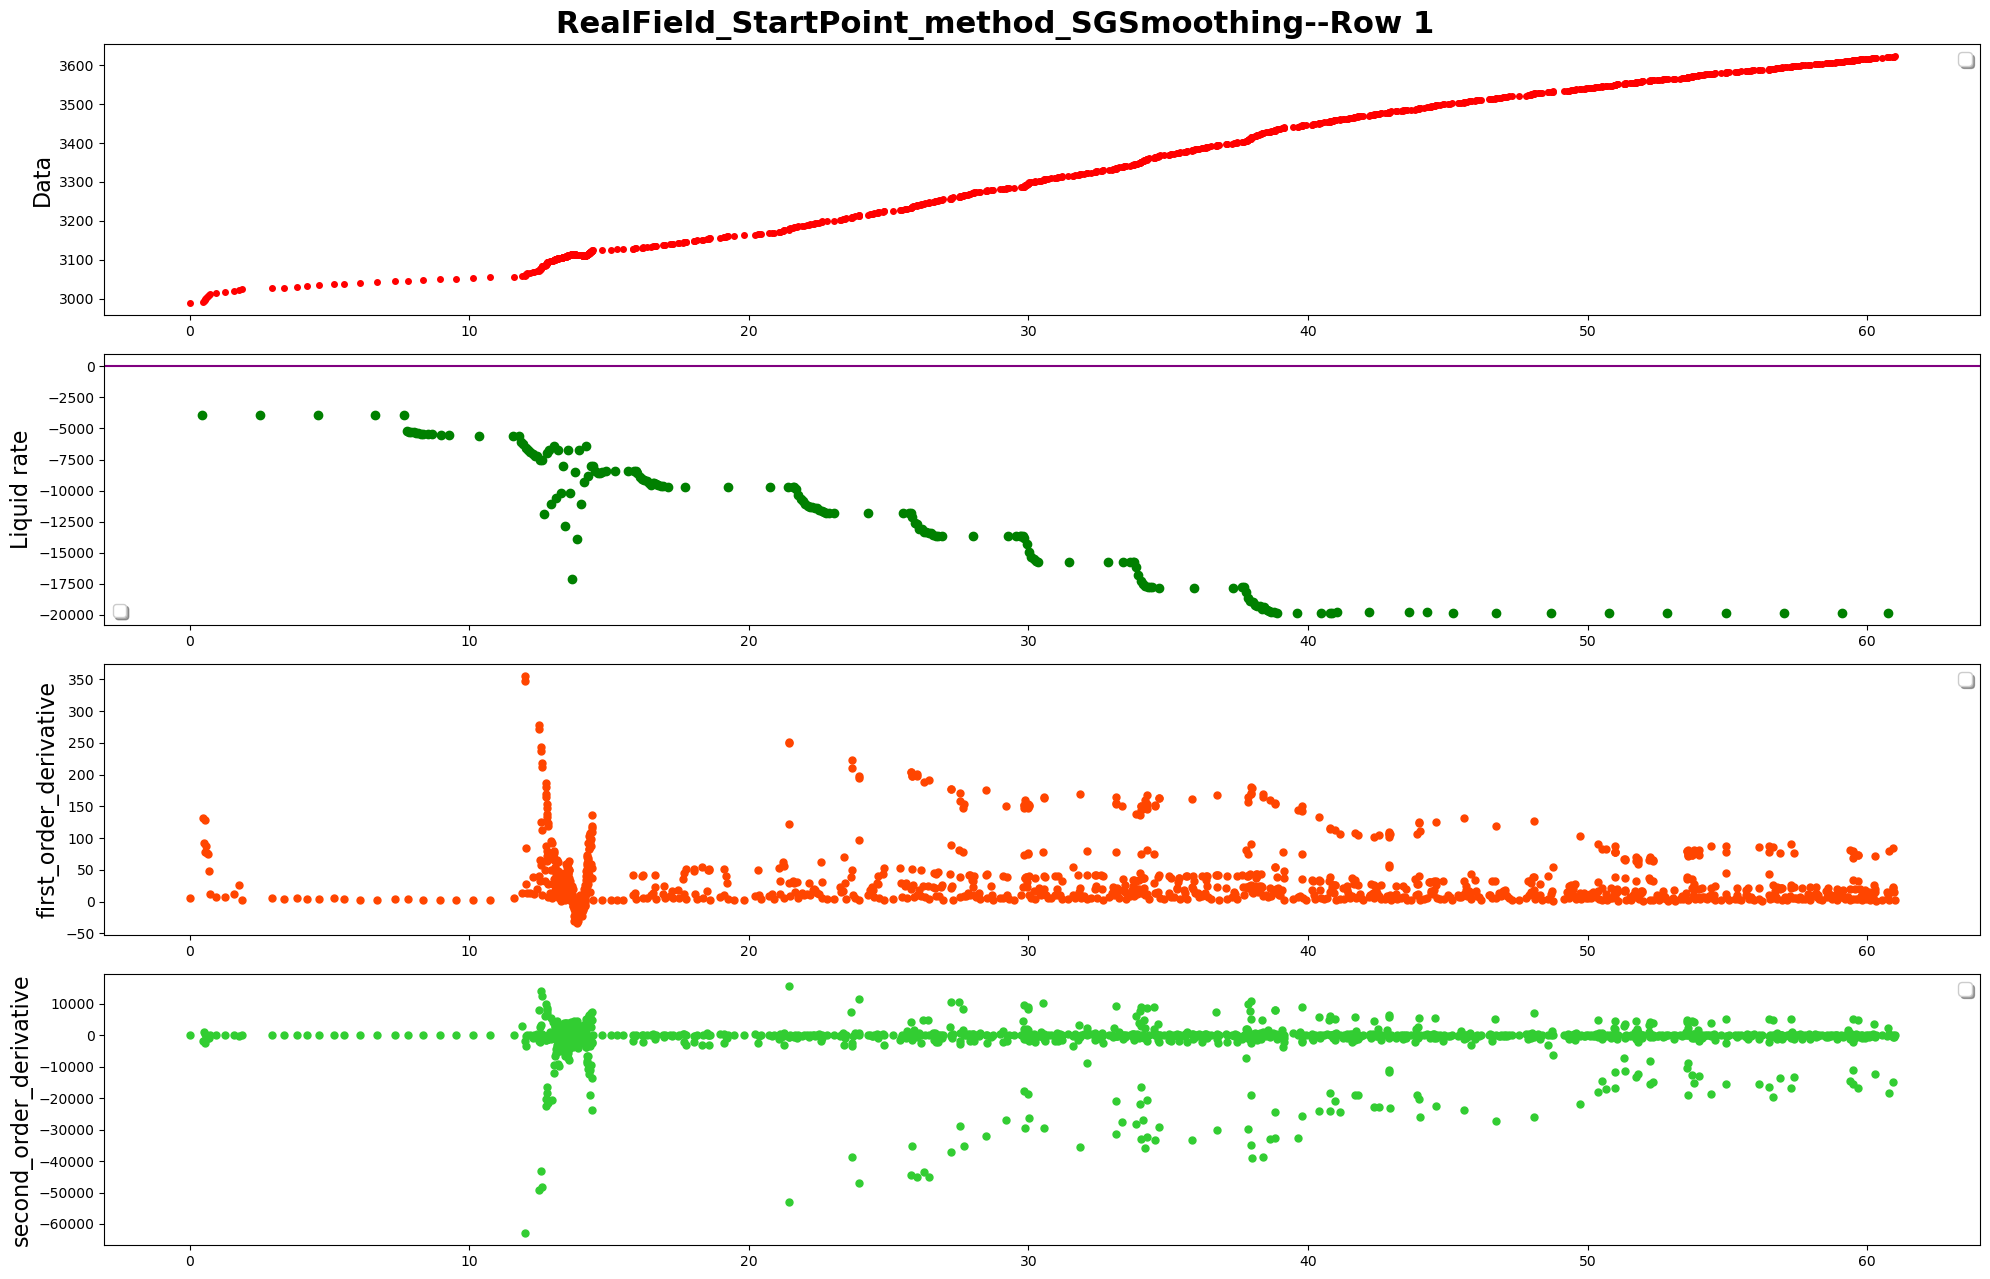

------row 2-----detected points:[]


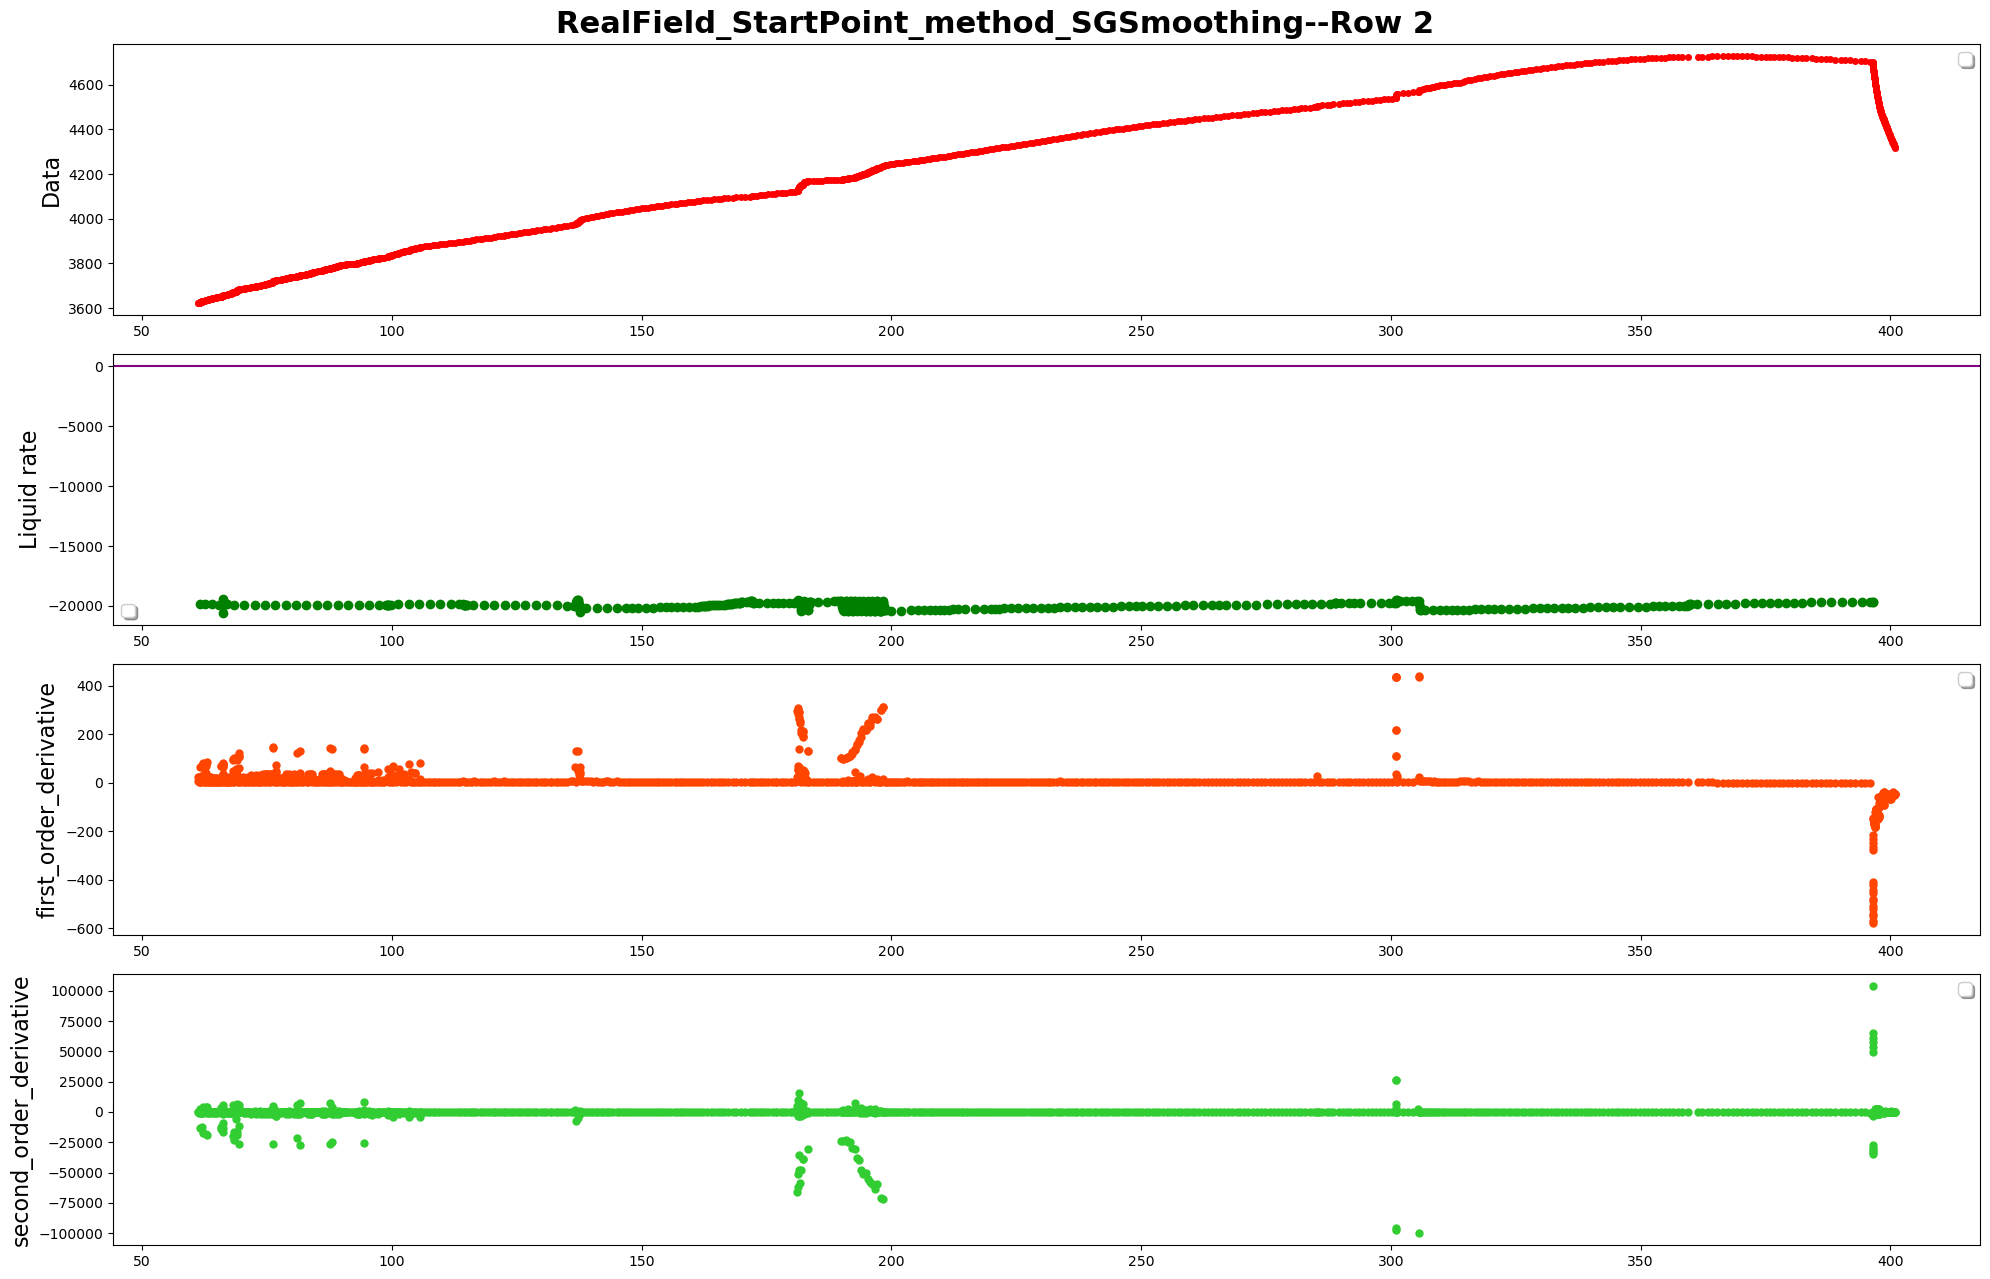

------row 3-----detected points:[]


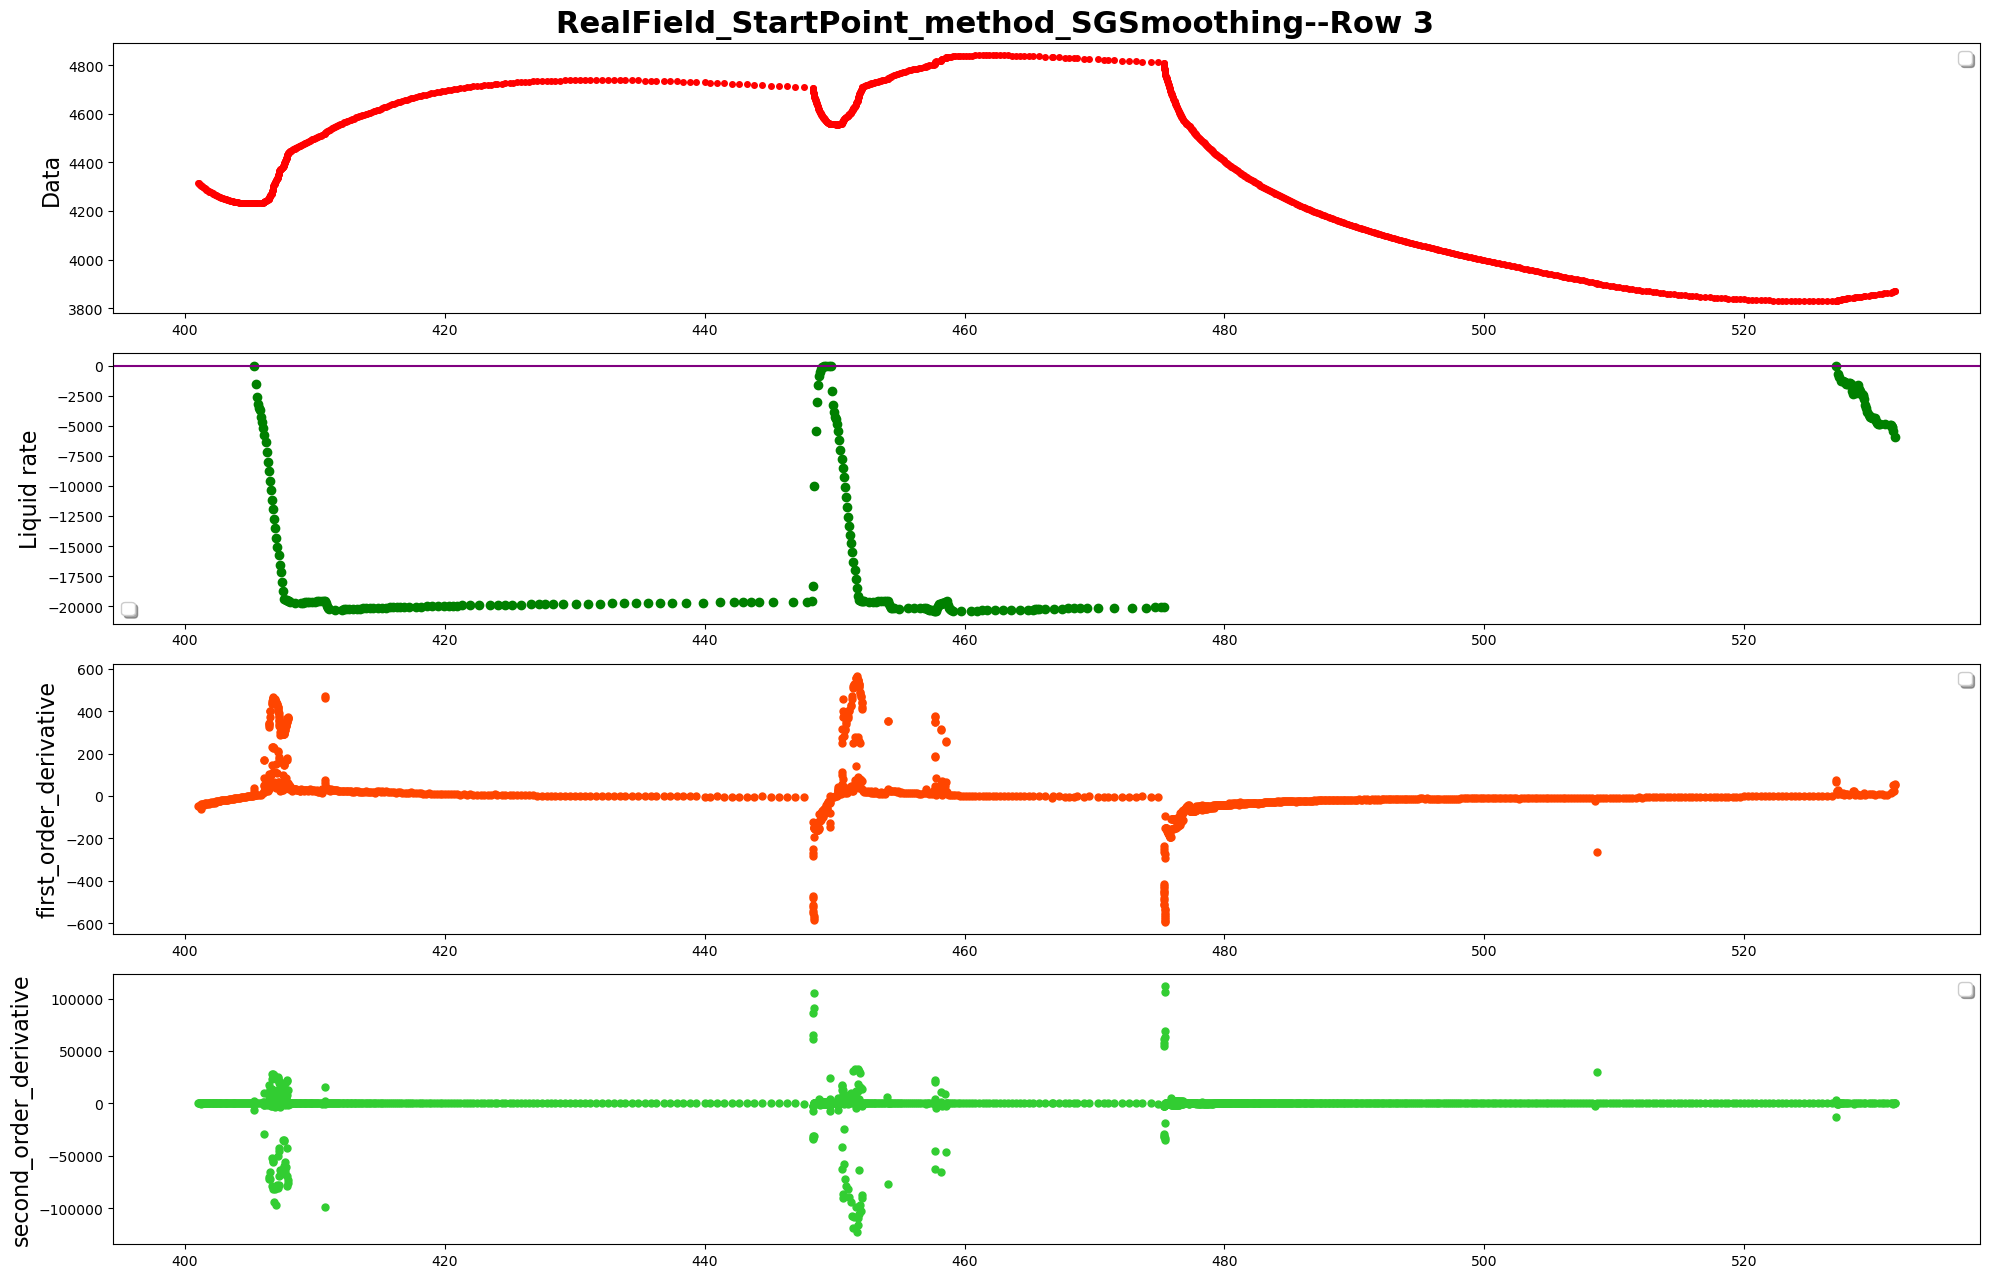

------row 4-----detected points:[4035]


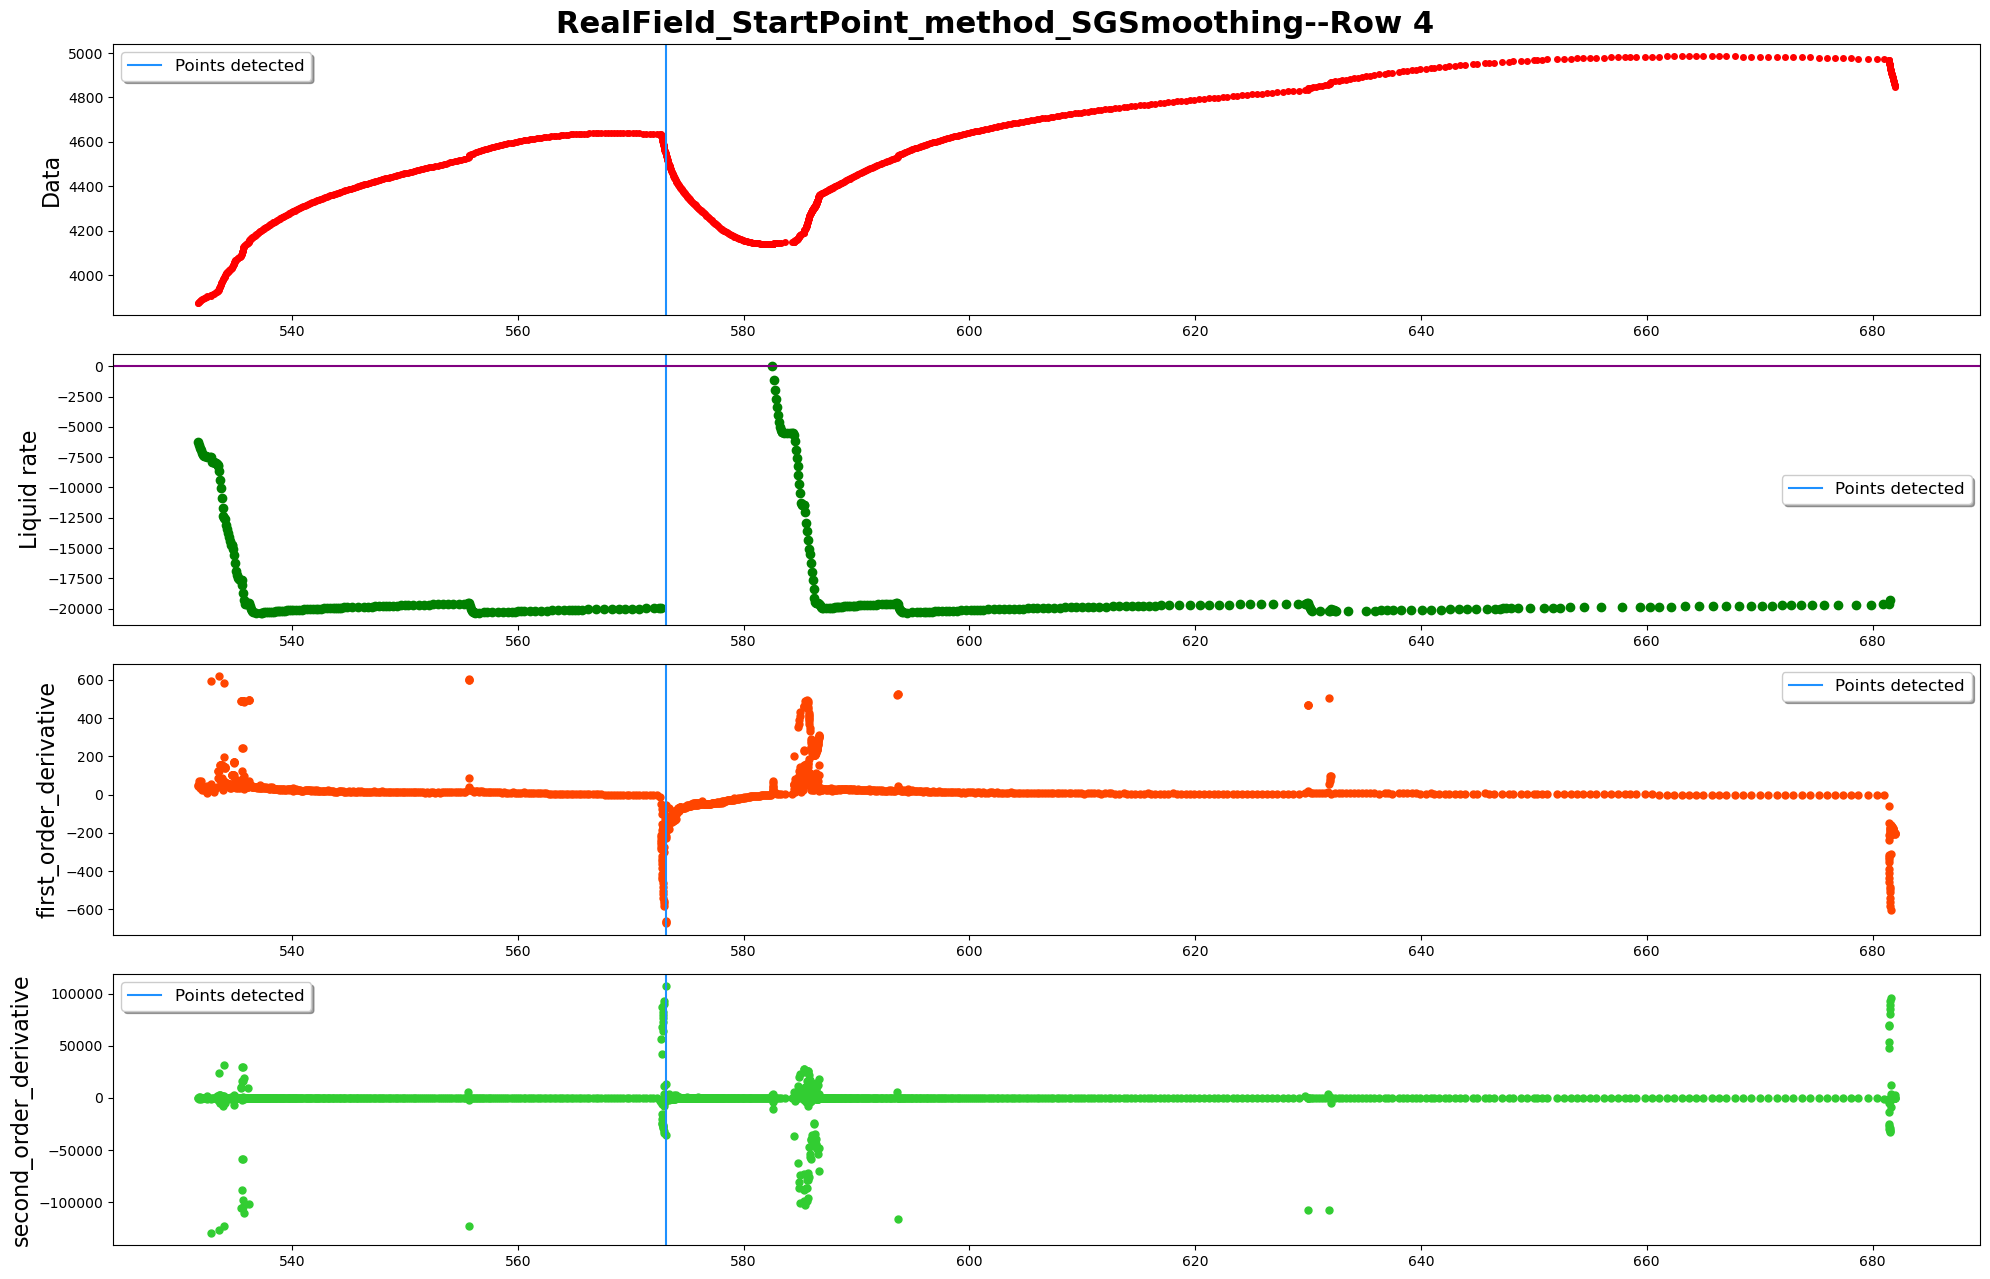

------row 5-----detected points:[]


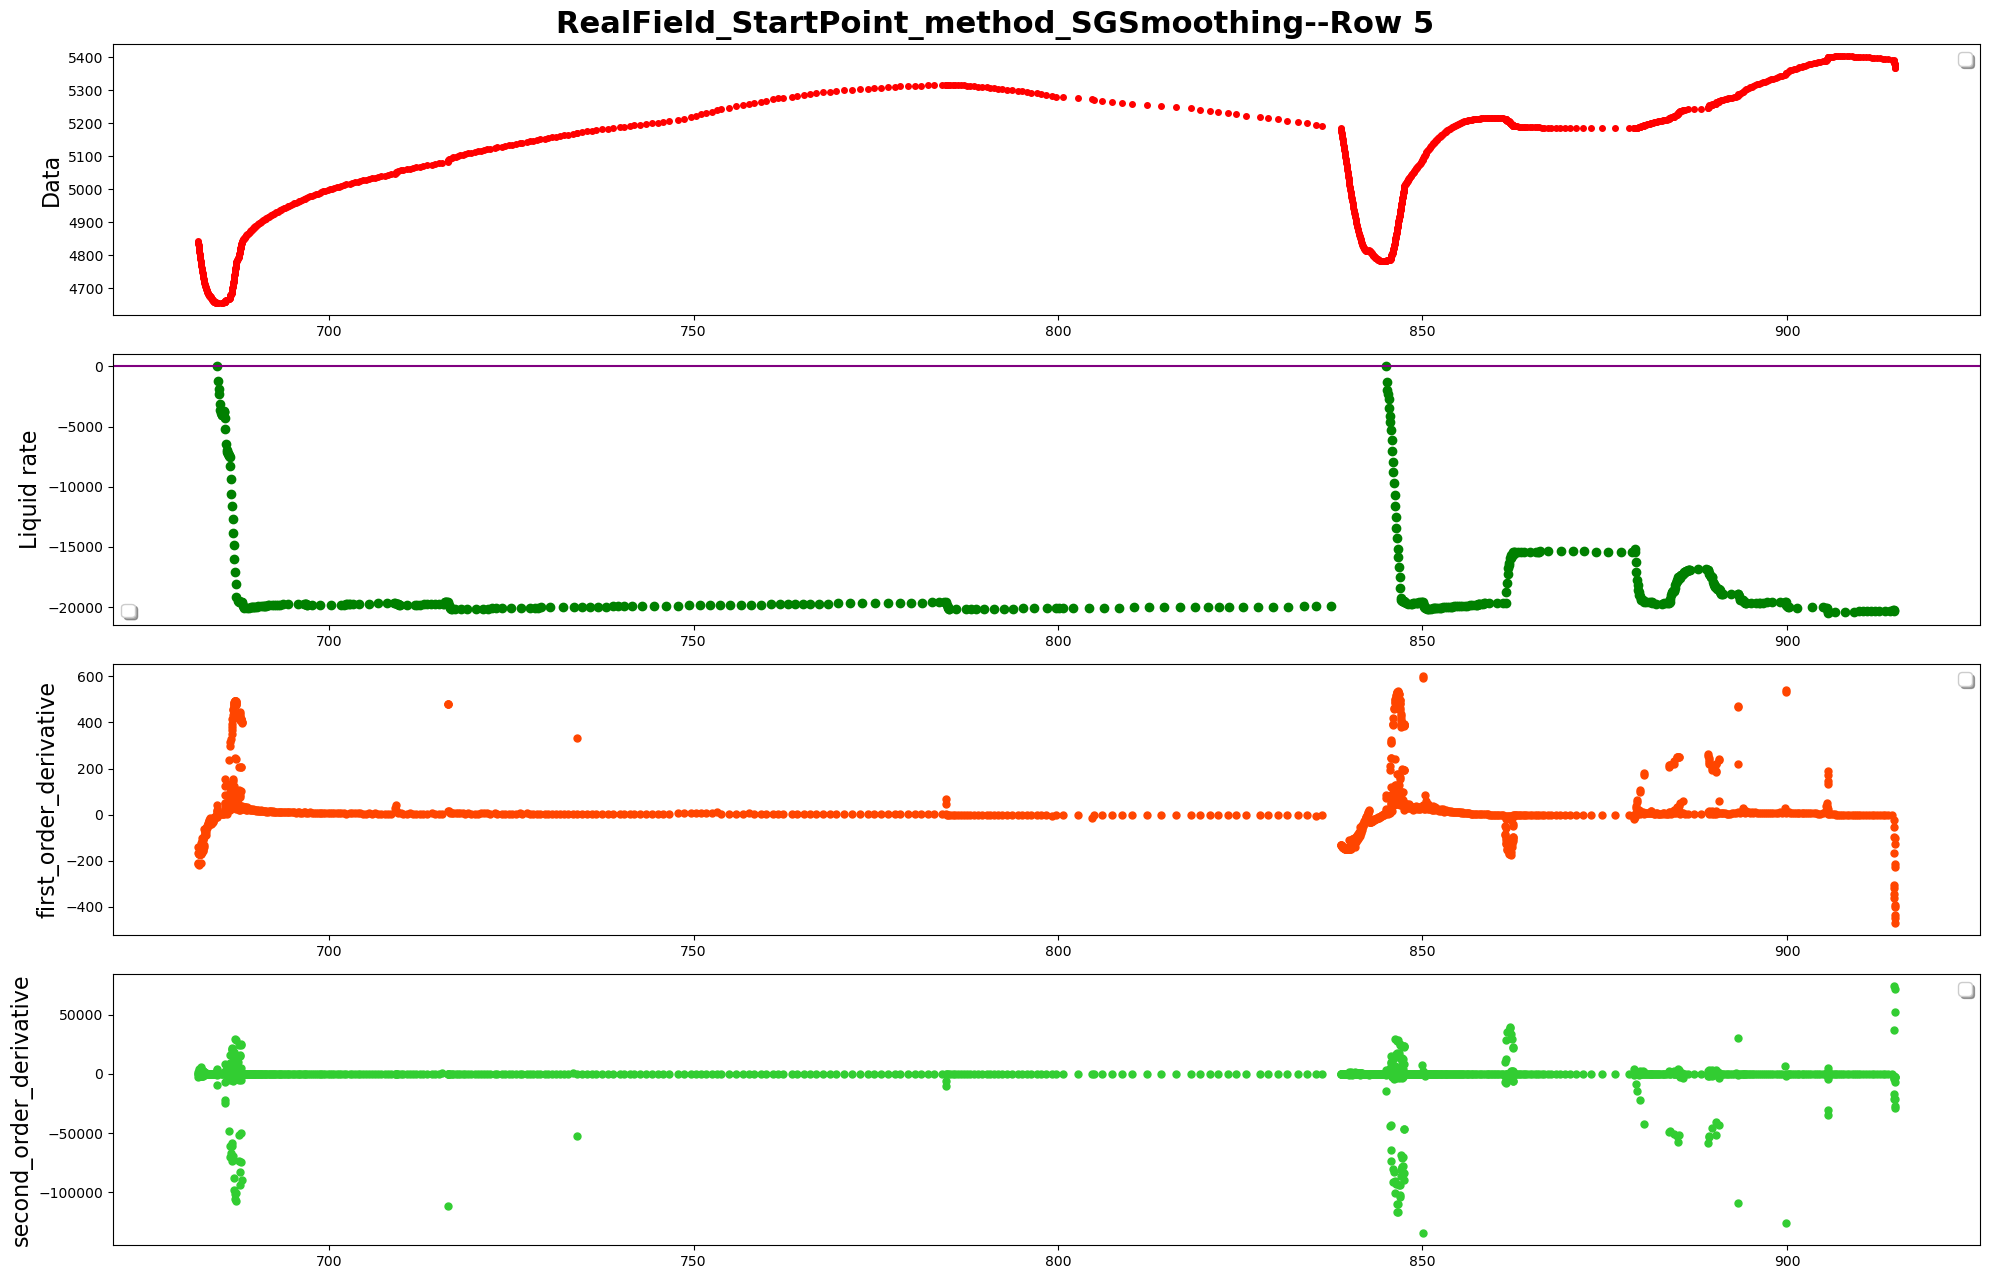

------row 6-----detected points:[6020, 6023, 6026, 6034, 6037]


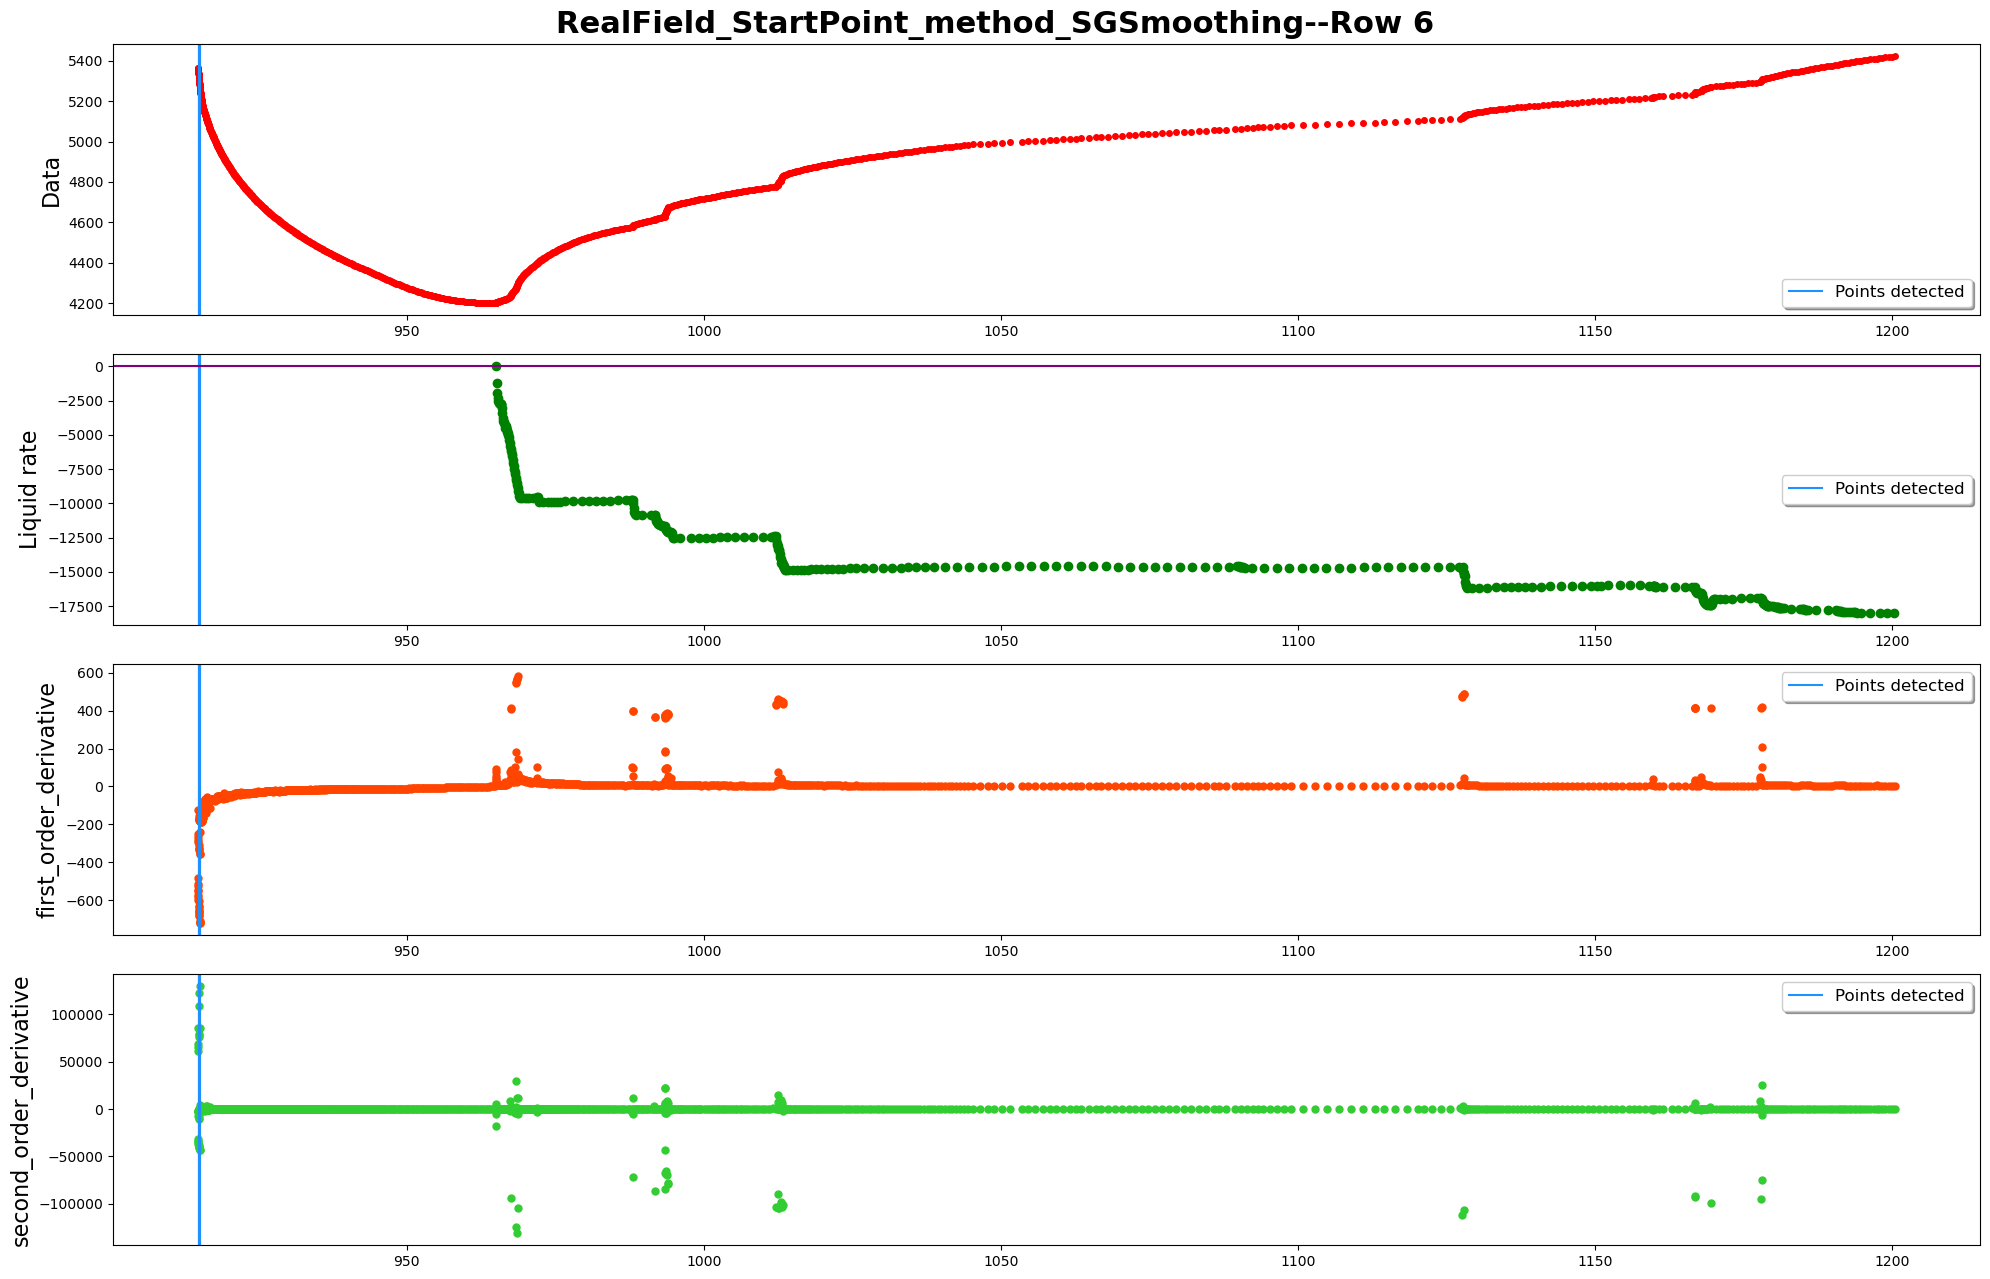

------row 7-----detected points:[7289, 7292, 7295, 7990, 7993]


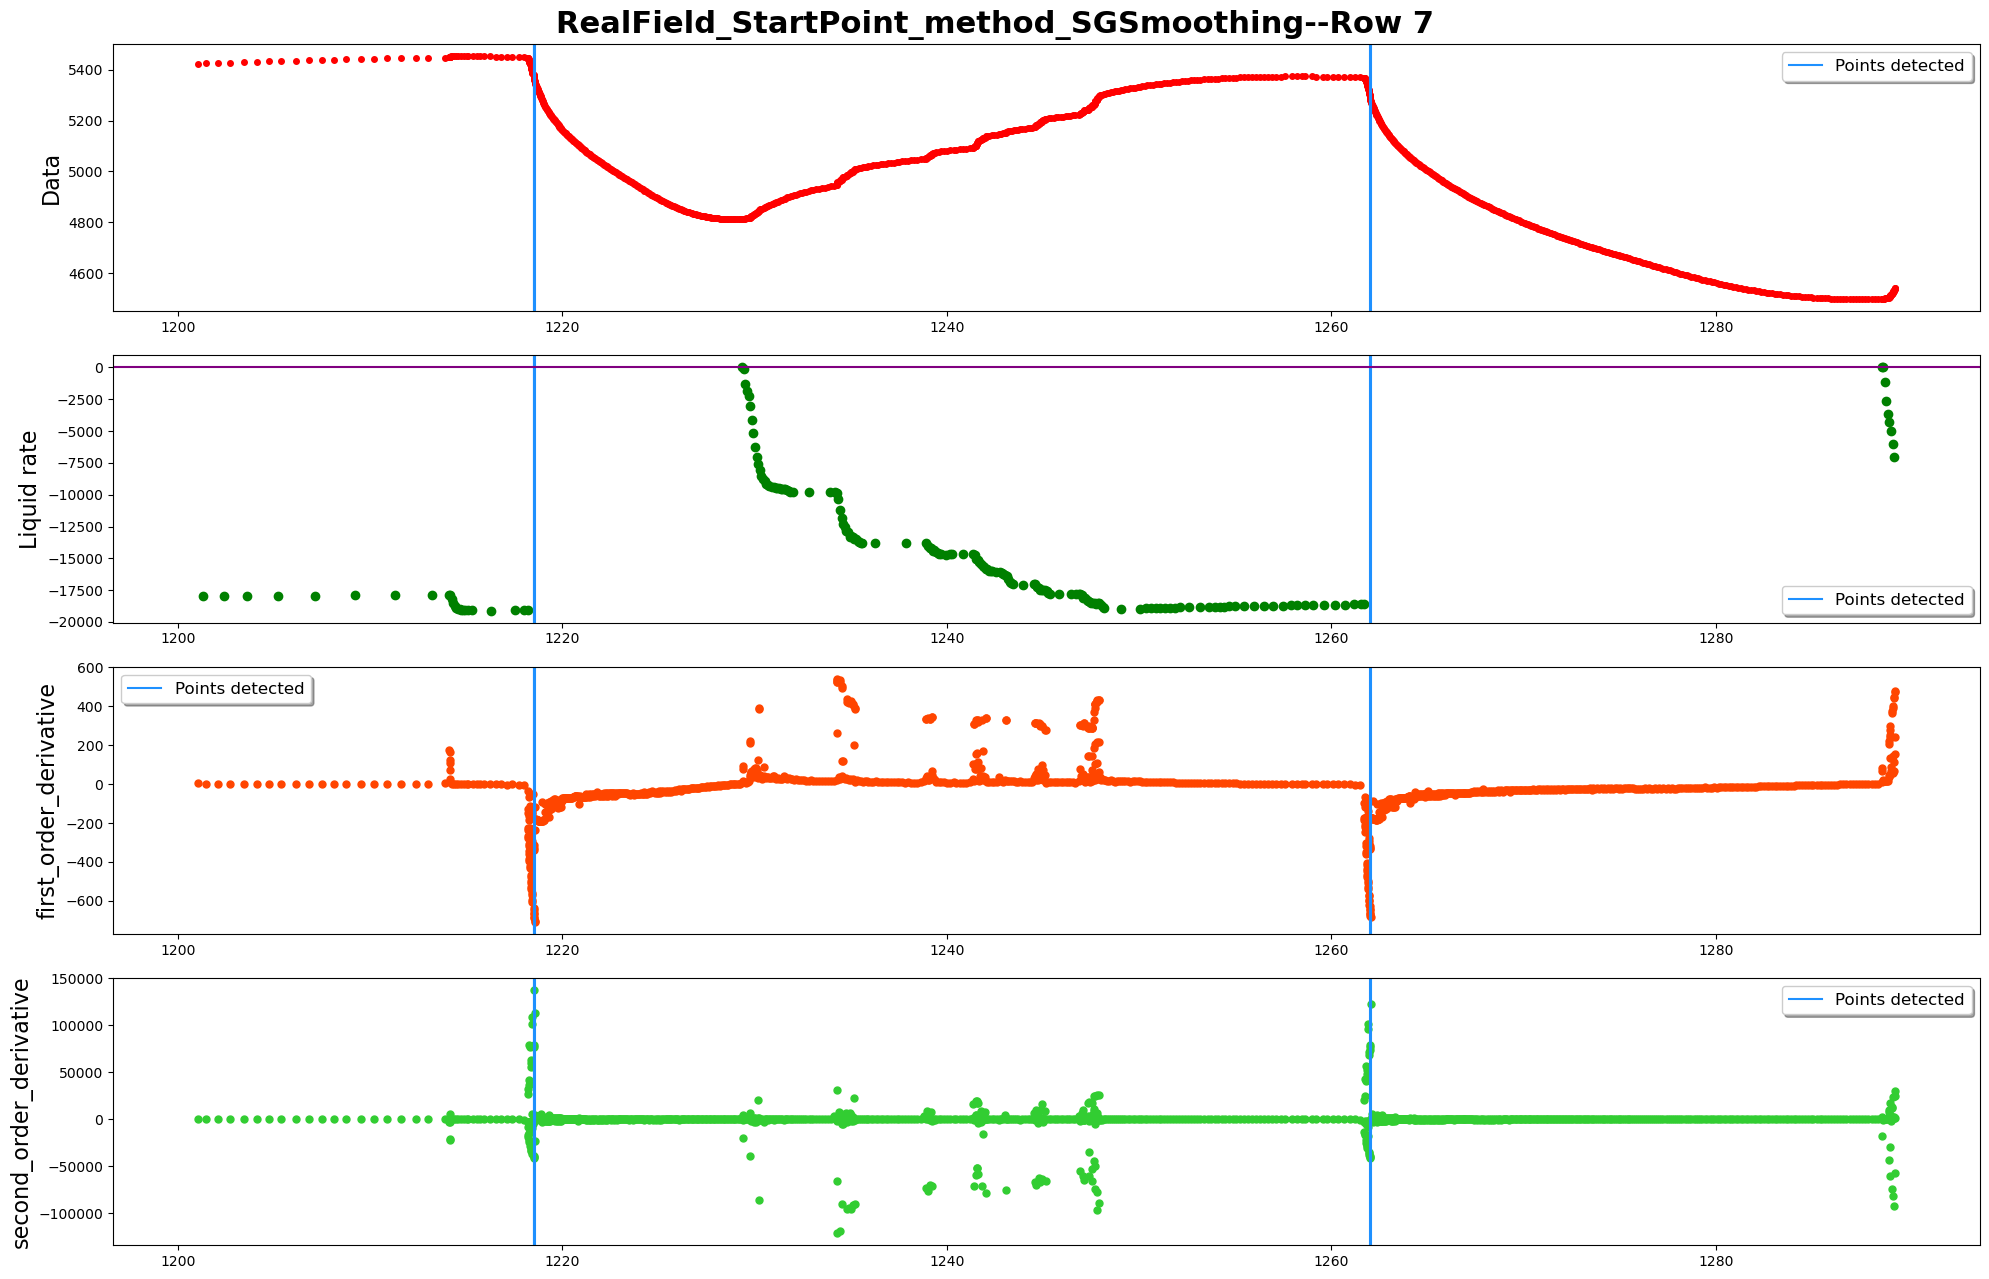

------row 8-----detected points:[9043, 9046, 9048]


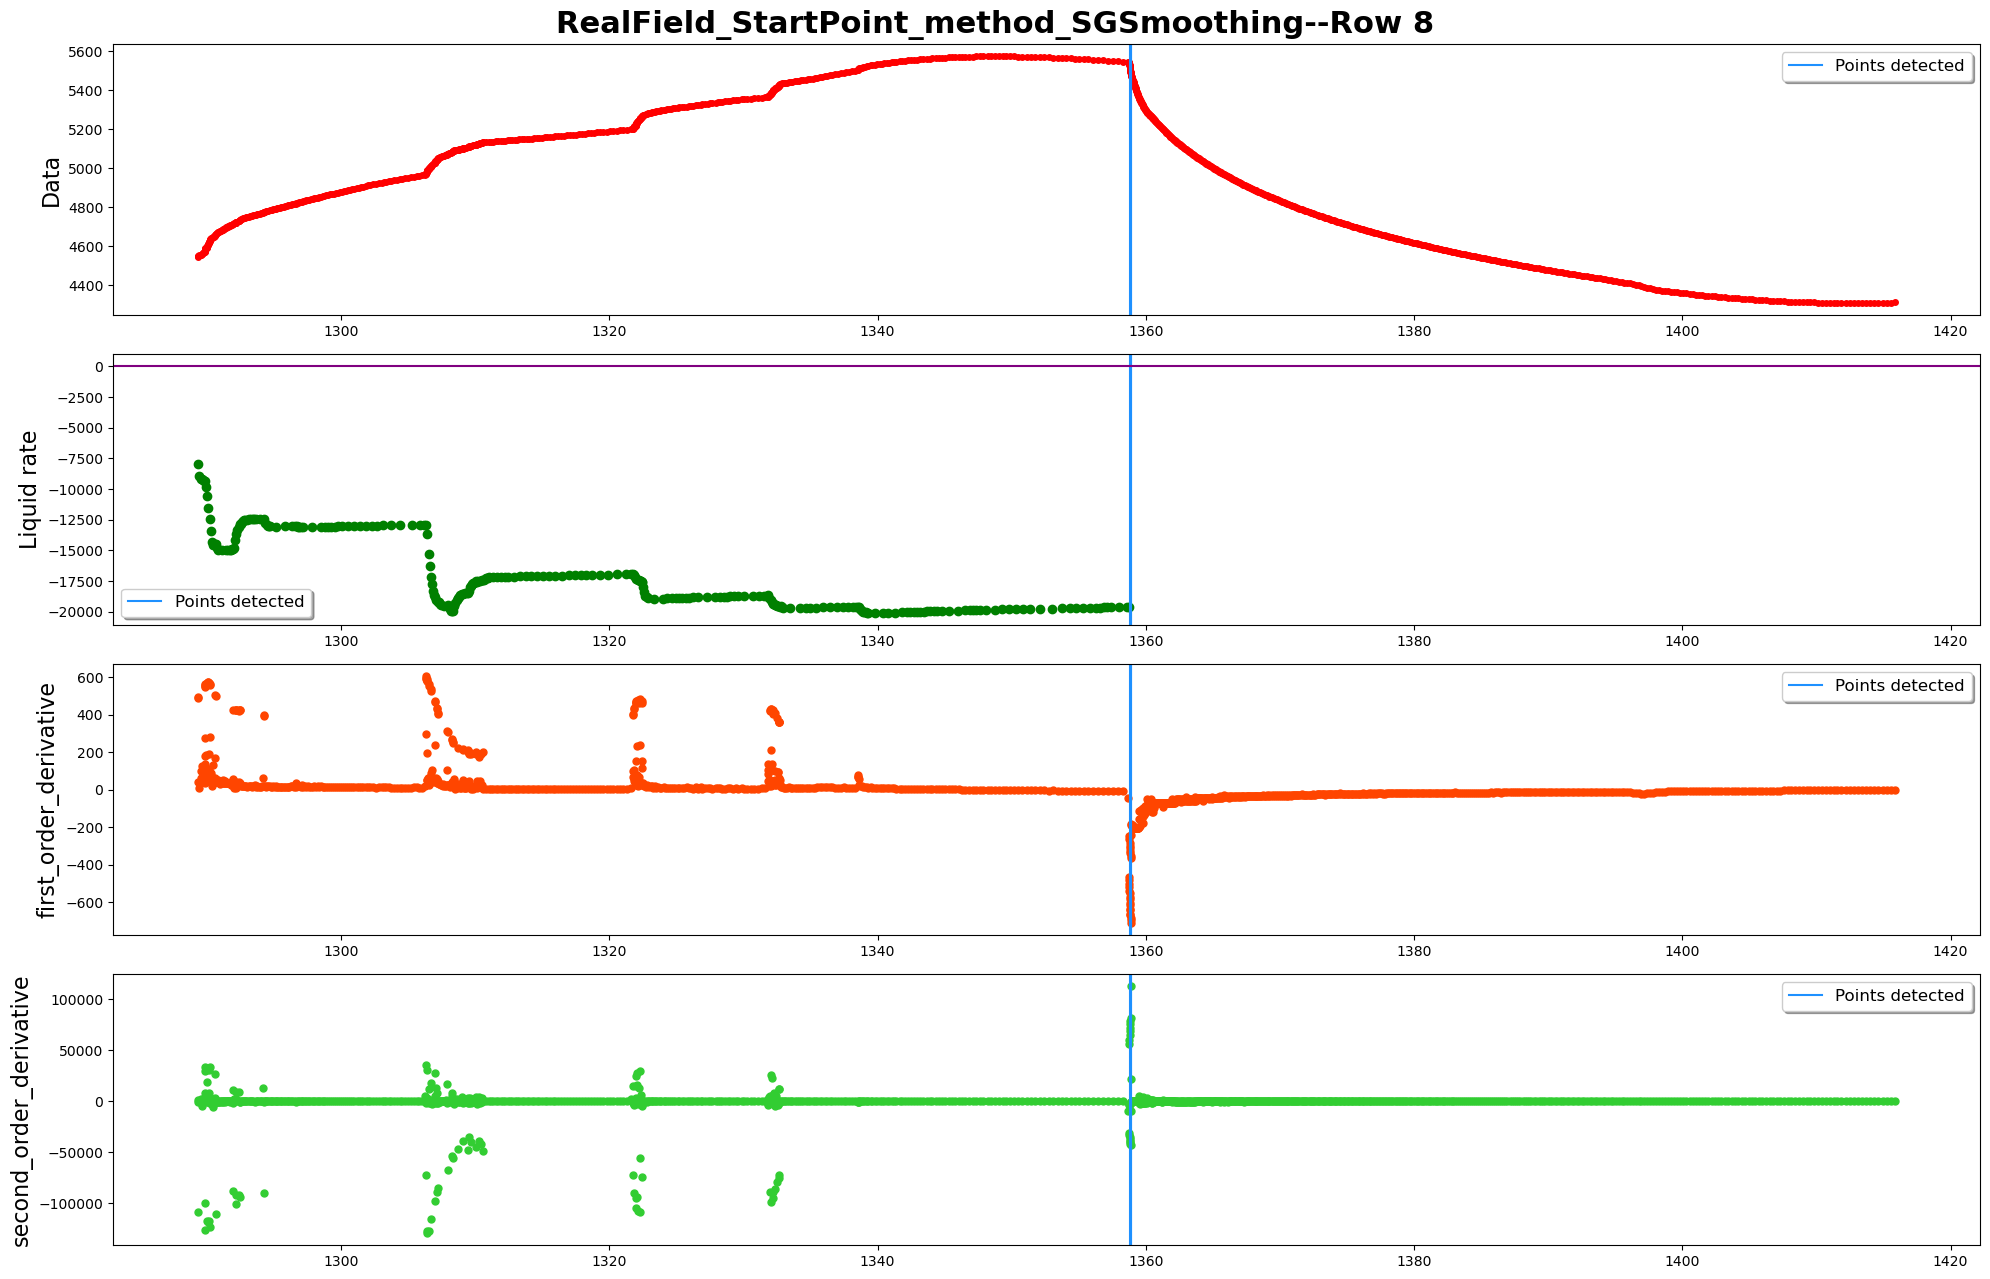

------row 9-----detected points:[9726, 10568]


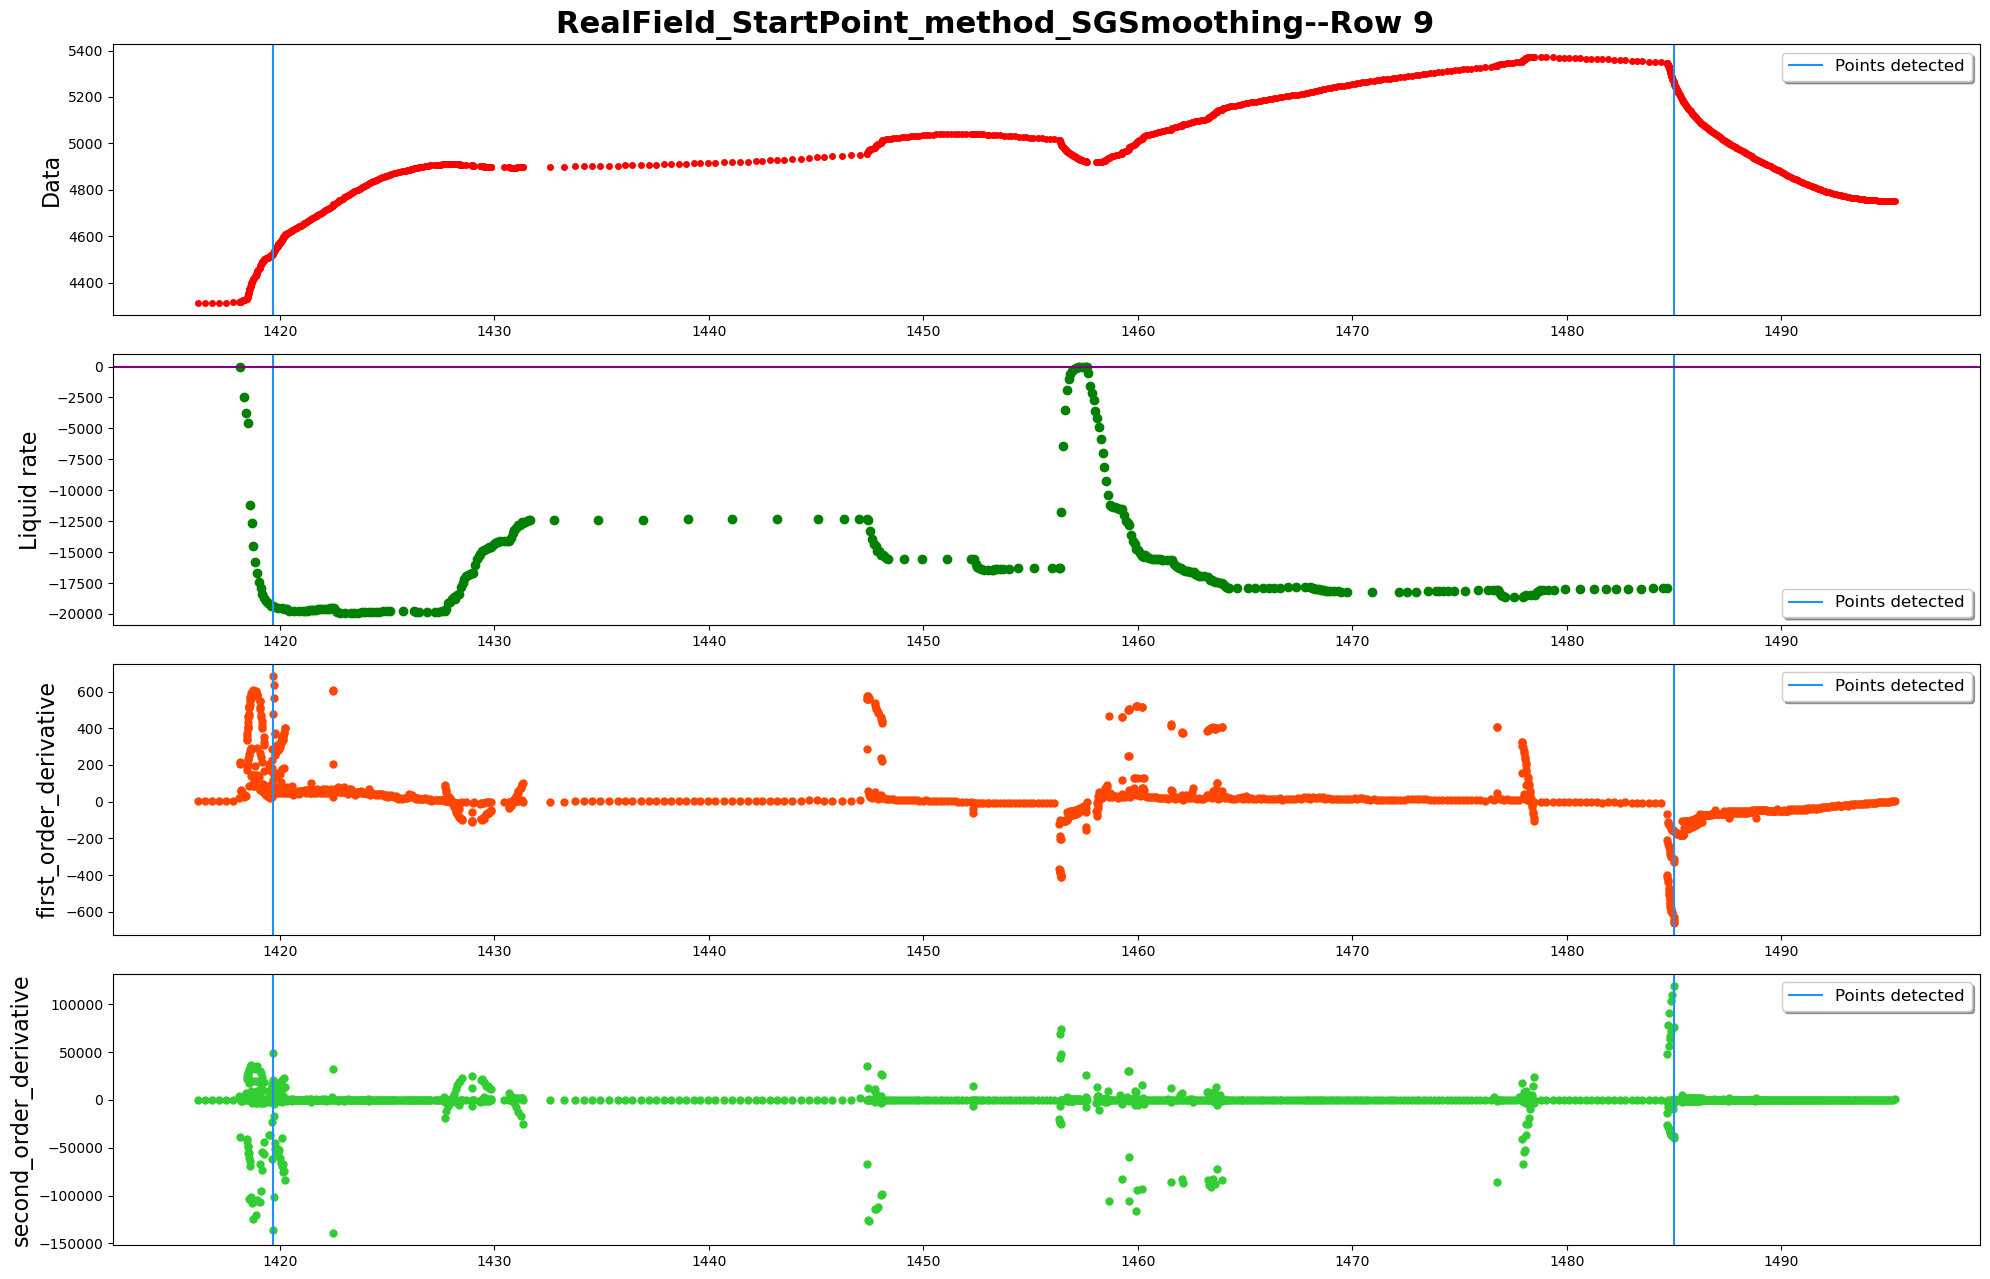

------row 10-----detected points:[11359, 11362, 11365, 11368, 11379]


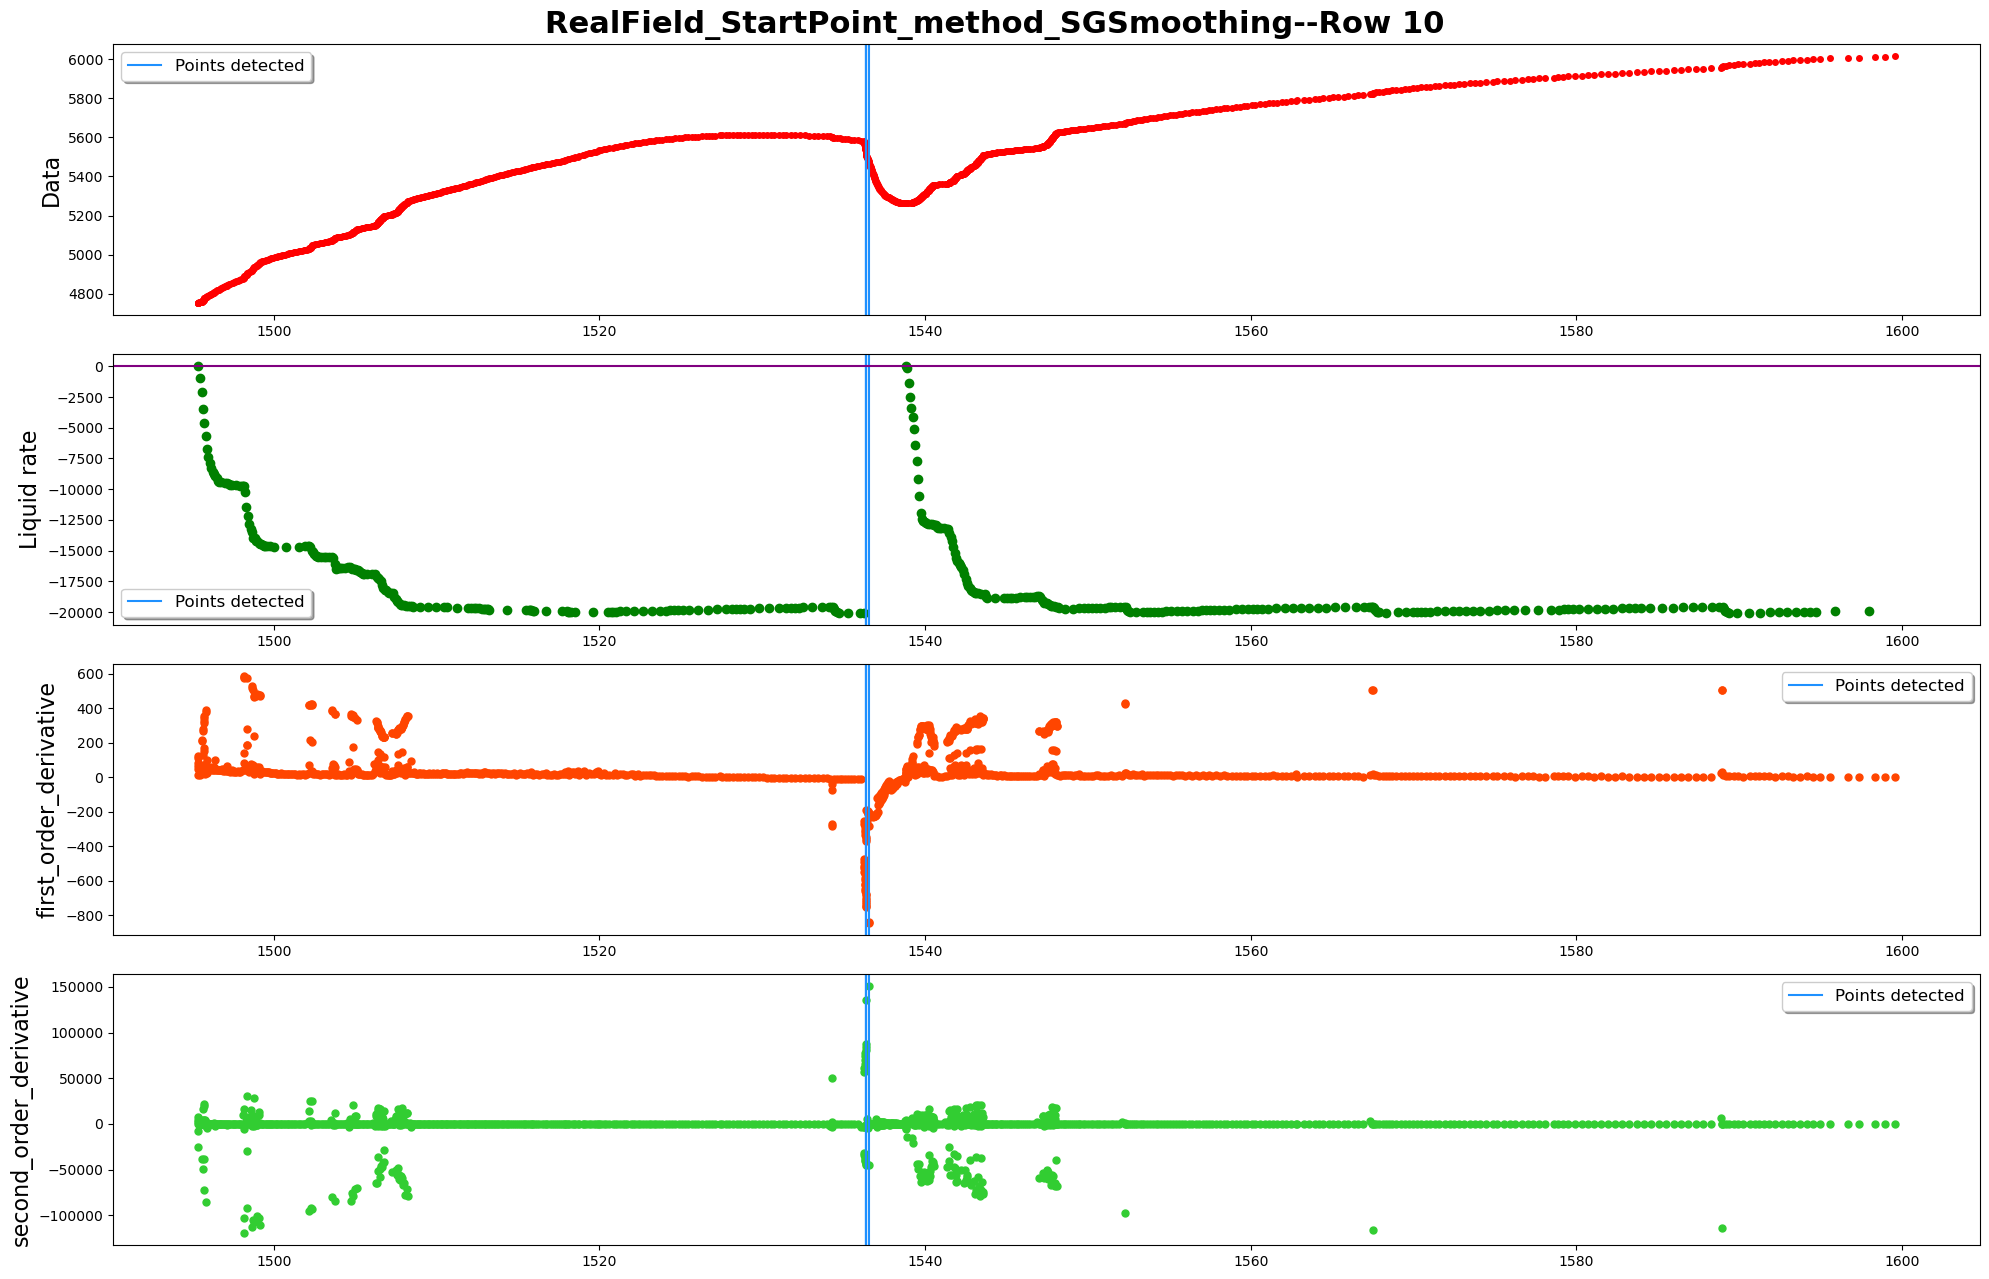

------row 11-----detected points:[12364, 12367, 12370, 12373, 12376, 12379, 12382, 12385, 12388, 12391, 12394, 12397, 12400, 13076, 13081, 13086, 13092, 13097, 13105, 13109, 13114, 13121, 13129]


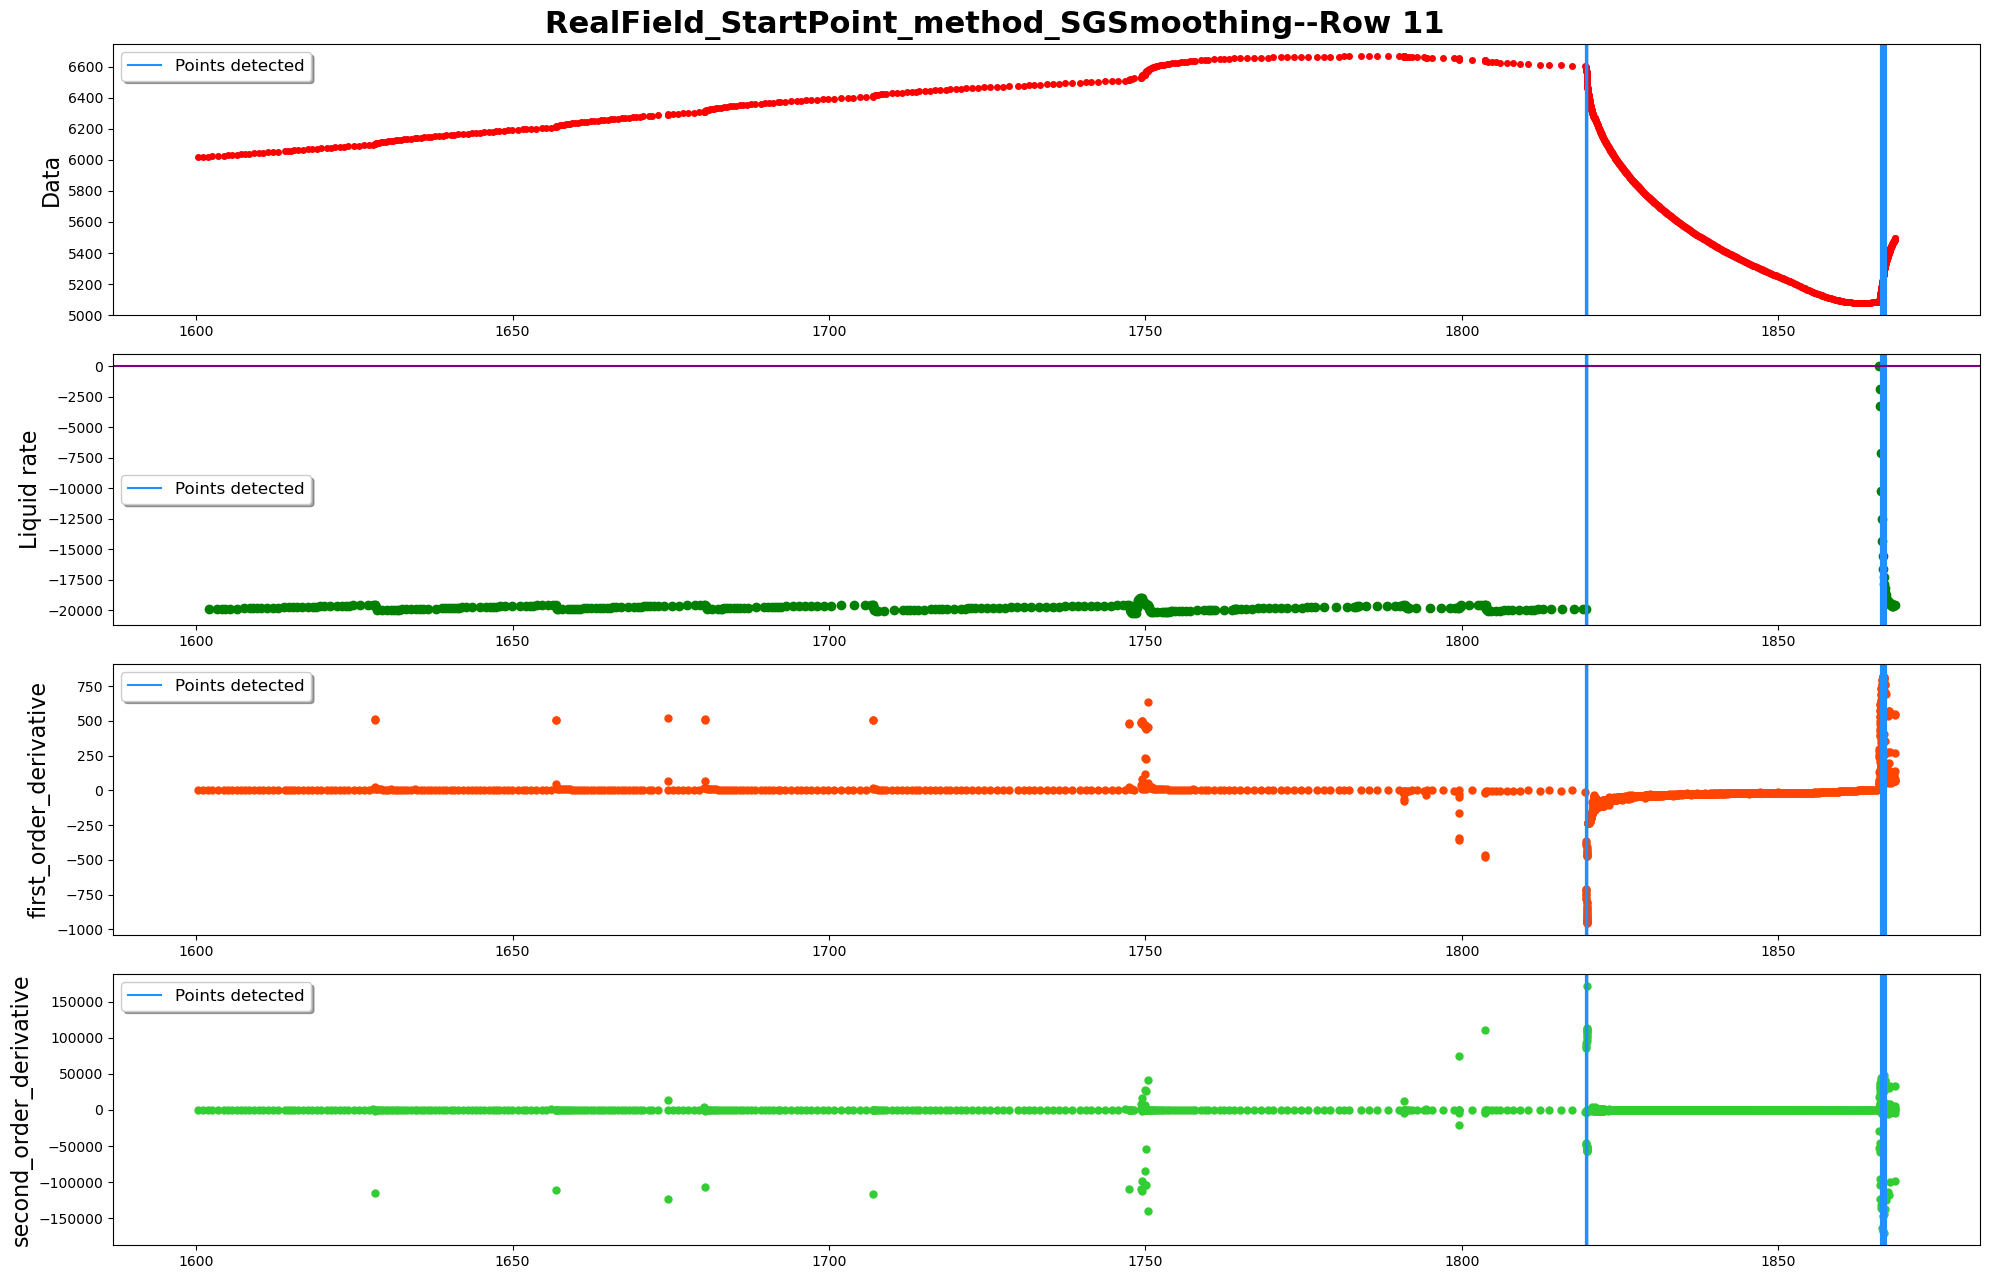

------row 12-----detected points:[13868, 13871, 13874, 13877, 13880, 13883, 13886, 13889, 13892, 13895, 13898, 13901, 13907, 13910, 13913, 13915, 13917, 13919, 14123, 14127, 14130, 14134, 14137, 14141, 14144, 14148, 14152, 14156, 14159, 14163, 14167, 14171]


KeyboardInterrupt: 

In [21]:
#S-G filter startPoint2
noise_threshold=3
breakpoints_detected_startPoint2=detect_breakpoints_startPoint2(first_order_derivative_denoised,second_order_derivative_denoised,noise_threshold)
print("len(breakpoints_detected)",len(breakpoints_detected_startPoint2))
#plot & save
ground_truth=[]
filename_toSave="../data_output/RealField_StartPoint_method_SGSmoothing.pdf"
plot_name="RealField_StartPoint_method_SGSmoothing"
plot_whole=True
plot_details=True
plot_statistics=True
PlotNSave(pressure_df_denoised,
          rate_df_denoised,
          breakpoints_detected_startPoint2,
          ground_truth,
          data_inOneRow,
          plot_name,
          filename_toSave,
          plot_statistics,
          plot_whole,
          plot_details,
          colum_names)

## Baseline method

In [20]:
#S-G filter baseline
noise_threshold=0.1
breakpoints_detected_3SG=detect_breakpoints_3(first_order_derivative_denoised,second_order_derivative_denoised,noise_threshold)
print(len(breakpoints_detected_3SG))
#plot & save
ground_truth=[]
filename_toSave="../data_output/RealField_baseline_method_SGSmoothing.pdf"
plot_name="RealField_baseline_method_SGSmoothing"
plot_whole=True
plot_details=True
plot_statistics=True
PlotNSave(pressure_df_denoised,
          rate_df_denoised,
          breakpoints_detected_3SG,
          ground_truth,
          data_inOneRow,
          plot_name,
          filename_toSave,
          plot_statistics,
          plot_whole,
          plot_details,
          colum_names)

217.076859984311 26067.263415502584
80
---initializing...
---plotting...


ValueError: list.remove(x): x not in list

In [ ]:
#S-G filter detect algorithm 4
# noise_threshold=0.3
# close_zero_threshold=0.5
# window_time_duration=8
# breakpoints_detected_4SG=detect_breakpoints_4(pressure_df_denoised,colum_names, noise_threshold,window_time_duration,close_zero_threshold)
# print(len(breakpoints_detected_4SG))


In [ ]:
# notin3=[point for point in breakpoints_detected_4SG if point not in breakpoints_detected_3SG]
# print(len(breakpoints_detected_3SG),len(breakpoints_detected_4SG),len(notin3))

In [ ]:
len(breakpoints_detected_3),len(breakpoints_detected_3SG)
index_zero_rate=[index for index, rate in enumerate(rate_df["Liquid rate"]) if rate==0]
print(index_zero_rate)
indexo_rate=[rate_df.iloc[index]["Elapsed time"] for index, rate in enumerate(rate_df["Liquid rate"]) if rate==0]
time_zero_rate=[rate_df.iloc[index]["Elapsed time"] for index, rate in enumerate(rate_df["Liquid rate"]) if rate==0]
len(time_zero_rate),time_zero_rate

In [ ]:
breakpoints_zero_rate=[]
for time_rate in time_zero_rate:
    for index, time_pressure in enumerate(pressure_df["Elapsed time"]):
        if time_pressure>=time_rate:
            breakpoints_zero_rate. append(index)
            break
len(breakpoints_zero_rate) 
breakpoints_zero_rate
zero_rate={"index_zero_rate":index_zero_rate,"breakpoints_zero_rate":breakpoints_zero_rate}
zero_rate_df=pd.DataFrame(data=zero_rate)
zero_rate_df

In [ ]:
rate_df.iloc[1489]["Elapsed time"]
for index, time_pressure in enumerate(pressure_df["Elapsed time"]):
        if time_pressure>=rate_df.iloc[2893]["Elapsed time"]:
            print(index)
            break

In [ ]:
print(len(breakpoints_detected_3+breakpoints_detected_3SG+breakpoints_zero_rate+[5297]))
breakpoints_union=set(breakpoints_detected_3+breakpoints_detected_3SG+breakpoints_zero_rate+[5297]+[10216]+[10528]+[14774]+[16616]+[19764]+[20021]+[21030]+[25717]+[28322])
print(len(breakpoints_union))
# breakpoints_union

In [ ]:
rate_df.iloc[1490], rate_df.iloc[1489]["Elapsed time"]

In [ ]:
a=pressure_df.iloc[10150:10245]["Data"]
min(a)
pressure_df.loc[pressure_df["Data"]==min(a)]
pd.set_option('display.max_rows', pressure_df.shape[0]+1)
display(pressure_df.iloc[10150:10245])
delta=pressure_df.iloc[10151]["Elapsed time"]-pressure_df.iloc[10150]["Elapsed time"]
for i in range(10150,10223):
    t=pressure_df.iloc[i+1]["Elapsed time"]-pressure_df.iloc[i]["Elapsed time"]
    print(i,t,delta)
    if t>delta:
        delta=t
        pointer=i
i

In [ ]:
# data_inOneRow=700
# plot_4_metrics_details(data_inOneRow,
#                        pressure_df,
#                        rate_df,
#                        breakpoints_zero_rate,
#                        ground_truth,
#                        colum_names)

In [ ]:
# data_inOneRow=500
# plot_4_metrics_details(data_inOneRow,
#                        pressure_df,
#                        rate_df,
#                        list(breakpoints_union),
#                        ground_truth,
#                        colum_names)

In [ ]:
bp=28310
pressure_df.iloc[bp-30:bp+30]

In [ ]:
a=[10245, 10499, 10021, 10149, 10150]
b=a.sort()
a,b

In [ ]:
breakpoints_union=set(breakpoints_detected_3SG+breakpoints_zero_rate+[5297]+[10216]+[10528]+[11340]+[12363]+[13868]+[14774]+[16616]+[16098]+[19764]+[20021]+[21030]+[25717]+[28322])
print(len(breakpoints_union))
# breakpoints_union